In [42]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
import statsmodels.api as sm
from jax import grad, jit, vmap, jvp, vjp, jacrev, jacfwd
key = random.PRNGKey(0)

In [43]:
class AdamOptim:
    def __init__(self, eta, beta1, beta2, epsilon, params):
        self.m = jax.tree_map(lambda m: 0.0, params)
        self.v = jax.tree_map(lambda m: 0.0, params)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, params, grads, t):
        self.m = jax.tree_map(lambda m, grads: self.beta1*m + (1-self.beta1)*grads, self.m, grads)
        self.v = jax.tree_map(lambda v, grads: self.beta2*v + (1-self.beta2)*(grads**2), self.v, grads)
        m_hat = jax.tree_map(lambda m: m/(1 - self.beta1**t), self.m)
        v_hat = jax.tree_map(lambda v: v/(1 - self.beta2**t), self.v)
        params = jax.tree_map(lambda p, m, v: p -  self.eta* m/(jnp.sqrt(v) + self.epsilon), params, m_hat, v_hat)
        return(params)



#### Triangular map

In [44]:
## The functional intializes both FICNN and PICNN 

def init_icnn_params(x_layer_widths, y_layer_widths, picnn = True):
  params = []
  for n_in_x, n_out_x, n_in_y, n_out_y in zip(x_layer_widths[:-1], x_layer_widths[1:], y_layer_widths[:-1], y_layer_widths[1:]):
    if(picnn):
      params.append(
          dict(weights_x=jnp.zeros(shape = (n_out_x, n_in_x)),
          biases_x=random.uniform(key, shape=(n_out_x,1)),
          weights_z=random.uniform(key, shape = (n_out_y, n_in_y)),
          biases_z=random.uniform(key, shape = (n_in_y,1)),
          weights_zu=random.normal(key, shape = (n_in_y, n_in_x)),
          weights_y=jnp.zeros(shape = (n_out_y, 1)),
          biases_y=random.normal(key, shape = (1,1)),
          weights_yu=random.normal(key, shape = (1, n_in_x)),
          weights_u=random.normal(key, shape = (n_out_y, n_in_x)),
          biases=random.normal(key, shape = (n_out_y,1))
          ))
    else:
      params.append(
          dict(weights_z=random.uniform(key, shape = (n_out_y, n_in_y)),
          weights_y=random.normal(key, shape = (n_out_y, 1)),
          biases=random.normal(key, shape = (n_out_y,1))
          ))
  return(params)


In [45]:

def picnn_forward(params, x, y):
  p_x = x.size
  p_z = params[0]['weights_z'].shape[1]
  u = jnp.reshape(x, (p_x,1))
  z = jnp.zeros(shape=(p_z,1))
  y = jnp.reshape(y, (1,1))
  *hidden, last = params
  for layer in hidden:
    z = jax.nn.swish(layer['weights_z'] @ jnp.multiply(z,(layer['weights_zu'] @ u + layer['biases_z'])) + \
    layer['weights_y'] @ jnp.multiply(y, (layer['weights_yu'] @ u + layer['biases_y'])) + layer['weights_u'] @ u + layer['biases'])
    u = jax.nn.swish((layer['weights_x']) @ u + (layer['biases_x']))

  z = (last['weights_z'] @ (z*(last['weights_zu'] @ u + last['biases_z'])) + \
    last['weights_y'] @ (y*(last['weights_yu'] @ u + last['biases_y'])) + last['weights_u'] @ u + last['biases'])
  u = (last['weights_x']) @ u + (last['biases_x'])
  z = jnp.reshape(z, ())
  return z


def ficnn_forward(params, y):
  p_z = params[0]['weights_z'].shape[1]
  z = jnp.zeros(shape=(p_z,1))
  y = jnp.reshape(y, (1,1))
  *hidden, last = params
  for layer in hidden:
    z = jax.nn.swish((layer['weights_z'] @ z) + (layer['weights_y'] @ y) + layer['biases'])
    
  z = (last['weights_z'] @ z) + (last['weights_y'] @ y) + last['biases']
  z = jnp.reshape(z, ())
  return z

vec_picnn = jax.vmap(picnn_forward, in_axes=[None, None, 0], out_axes = 0)
vec_ficnn = jax.vmap(ficnn_forward, in_axes=[None, 0], out_axes = 0)

In [46]:
def flow_forward(params, z):
  d = z.shape[0]
  f_x = z[0] + jnp.array([grad(ficnn_forward, argnums=1)(params[0], z[0])])
  for i in jnp.arange(1,d):
    f_x = jnp.append(f_x, z[i] + grad(picnn_forward, argnums=2)(params[i], z[:i], z[i]))
  return f_x

vec_flow = jax.vmap(flow_forward, in_axes=[None, 0], out_axes=0)
dflow = jax.jacrev(flow_forward, argnums = 1)

In [47]:
TUNING_PARAM = 1

def jac_det(params, z):
    d = z.shape[0]
    foo = grad(ficnn_forward, argnums=1)
    j = 1 + abs(grad(foo, argnums=1)(params[0], z[0]))
    for i in jnp.arange(1,d):
        foo = grad(picnn_forward, argnums=2)
        j *= 1 + abs(grad(foo, argnums=2)(params[i], z[:i], z[i]))
    return(j)

vec_jac_det = jax.vmap(jac_det, in_axes=[None, 0], out_axes = 0)

def KL_loss(params, samps):
    n = samps.shape[0]
    d = samps.shape[1]
    loss = 0
    samp_flow = vec_flow(params, samps)
    loss = jnp.sum(jnp.log(scipy.stats.multivariate_normal.pdf(samp_flow, mean = jnp.zeros((d,)), cov = jnp.identity(d))))

    loss += jnp.sum(jnp.log(vec_jac_det(params, samps)))

    loss = -loss/n
    for i in range(d):
        for layers in params[i]:
            loss += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
    return(loss )



In [48]:
LEARNING_RATE = 0.01
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

### Butterfly Distribution

$$P_i \sim N(0,1)$$
$$Q_i = W_iP_i \quad \text{ with} \quad W_i \sim N(0,1), \quad W_i \perp P_i, \, i = 1, \dots, r$$
Here we take $r = 5$ and the variables are ordered as $P_1, Q_1, \dots, P_5, Q_5$.

Text(0, 0.5, 'Y')

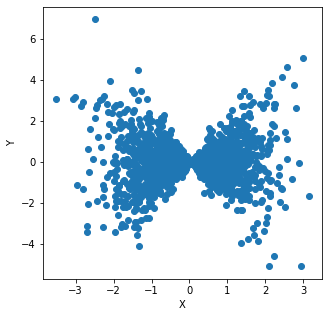

In [49]:
n = 2000
r = 2
d = 2*r
key, subkey = random.split(key)
ps = random.normal(key, shape = (n,1))
ws = random.normal(subkey, shape = (n,1))
samps = jnp.concatenate([ps, ps*ws], axis = 1)
for i in range(r-1):
    key, subkey = random.split(key)
    ps = random.normal(key, shape = (n,1))
    ws = random.normal(subkey, shape = (n,1))
    qs = ps*ws
    samps = jnp.concatenate([samps, ps, qs], axis = 1)

samps = (samps - jnp.average(samps, axis = 0))/jnp.std(samps, axis = 0)
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")



In [50]:
params = [init_icnn_params(x_layer_widths = [1, 2, 1], y_layer_widths=[1, 3, 1], picnn=False)]
for i in jnp.arange(1,d):
    params.append(init_icnn_params(x_layer_widths = [i, i, 1], y_layer_widths=[1, 3, 1], picnn=True))
z0 = jnp.zeros(shape = (d,))
print(flow_forward(params, z0), KL_loss(params, samps))

[3.089699 0.       0.       0.      ] 9.780915


In [117]:
adam = AdamOptim(eta=LEARNING_RATE, beta1=BETA1, beta2=BETA2, epsilon=EPSILON, params=params)
kl = jnp.array([KL_loss(params, samps)])
diff = 1
itr = 0
print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", 0)

while (diff > 1e-6):
    itr += 1
    grads = grad(KL_loss, argnums=0)(params, samps)
    params = adam.update(params, grads, t=itr)
    kl = jnp.hstack((kl, KL_loss(params, samps)))
    diff = jnp.abs((kl[-1] - kl[-2])/kl[-2])
    if(itr % 10 ==0):
        reg = 0
        for i in range(d):
            for layers in params[i]:
                reg += jnp.sum(layers['weights_z'][layers['weights_z'] < 0]**2)
        print("Iter: ", itr, "KL loss: ", kl[itr], "Non-monotonicity metric: ", reg)


Iter:  0 KL loss:  0.6742975 Non-monotonicity metric:  0
Iter:  10 KL loss:  1.2178813 Non-monotonicity metric:  0.07044766
Iter:  20 KL loss:  0.7925042 Non-monotonicity metric:  0.06909987
Iter:  30 KL loss:  0.67997676 Non-monotonicity metric:  0.06788228
Iter:  40 KL loss:  0.6973494 Non-monotonicity metric:  0.0675682
Iter:  50 KL loss:  0.6783756 Non-monotonicity metric:  0.06722519
Iter:  60 KL loss:  0.67495215 Non-monotonicity metric:  0.06694135
Iter:  70 KL loss:  0.67342645 Non-monotonicity metric:  0.0663908
Iter:  80 KL loss:  0.6723143 Non-monotonicity metric:  0.065909736
Iter:  90 KL loss:  0.671262 Non-monotonicity metric:  0.06593759
Iter:  100 KL loss:  0.6705919 Non-monotonicity metric:  0.066537224
Iter:  110 KL loss:  0.67007166 Non-monotonicity metric:  0.06632121
Iter:  120 KL loss:  0.66964954 Non-monotonicity metric:  0.0654674
Iter:  130 KL loss:  0.6693297 Non-monotonicity metric:  0.06476964
Iter:  140 KL loss:  0.6690661 Non-monotonicity metric:  0.064143

In [124]:
import pickle
with open('butterfly/params.pickle', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)


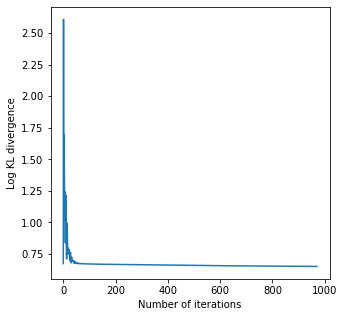

In [118]:
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Number of iterations")
plt.ylabel("Log KL divergence")
plt.plot(jnp.arange(0, jnp.size(kl)), kl)
plt.savefig('butterfly/butterfly-optim_curve.png')

In [119]:
z = vec_flow(params, samps)
jnp.std(z, axis = 0)

DeviceArray([0.8806885 , 0.5532398 , 0.45532665, 0.5863117 ], dtype=float32)

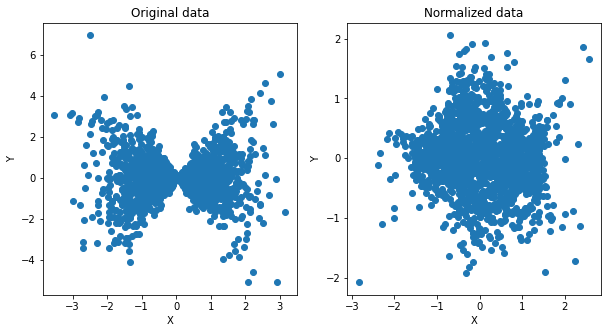

In [120]:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,2,1)
plt.scatter(samps[:,0], samps[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Original data")
plt.subplot(1,2,2)
plt.scatter(z[:,0],z[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Normalized data")
plt.savefig('butterfly/butterfly-scatter.png')

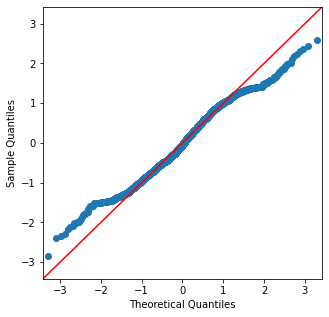

<Figure size 360x360 with 0 Axes>

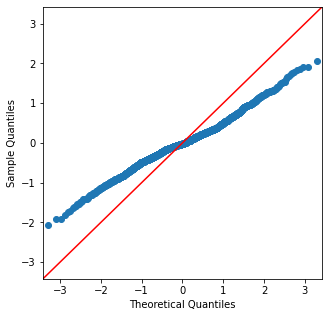

<Figure size 360x360 with 0 Axes>

In [121]:
plt.rcParams["figure.figsize"] = (5,5)
fig1 = sm.qqplot(z[:,0], line='45')
plt.show()
plt.savefig('butterfly/butterfly-qq1.png')
fig2 = sm.qqplot(z[:,1], line='45')
plt.show()
plt.savefig('butterfly/butterfly-qq2.png')

In [125]:
def log_pullback(params, z):
    samp_flow = flow_forward(params, z)
    log_like = jnp.log(scipy.stats.multivariate_normal.pdf(samp_flow, mean = jnp.zeros((d,)), cov = jnp.identity(d)))
    log_like += jnp.log(jac_det(params, z))
    return(log_like)

omega = jacfwd(jacrev(log_pullback, argnums = 1), argnums = 1)  
vec_omega = vmap(omega, in_axes=[None, 0], out_axes=0)


In [126]:
omega_hat = sum(abs(vec_omega(params, samps))**2)/n
omega_hat

DeviceArray([[5.2504844e+04, 1.5249213e+00, 5.2567620e+00, 1.1611511e-02],
             [1.5249214e+00, 3.2188504e+00, 1.7809100e+00, 5.2203662e-03],
             [5.2567611e+00, 1.7809097e+00, 8.9230965e+01, 1.9438114e+01],
             [1.1611513e-02, 5.2203662e-03, 1.9438114e+01, 2.6914146e+01]],            dtype=float32)

0
1


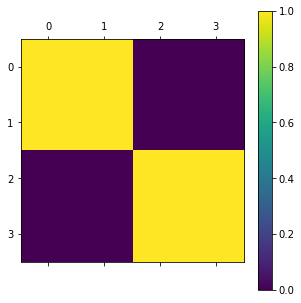

In [127]:
graph = jnp.identity(d)
for i in range(r):
    print(i)
    graph = graph.at[2*i,(2*i+1)].set(1)
    graph = graph.at[(2*i+1),2*i].set(1)
plt.matshow(graph);
plt.colorbar()
plt.show()

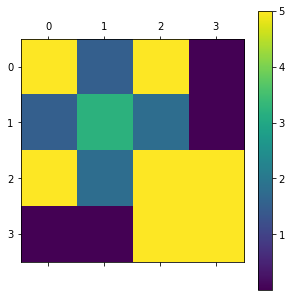

In [128]:
omega_tilda = jnp.where(omega_hat < 0.1, 0, omega_hat)
omega_tilda = jnp.where(omega_hat > 5, 5, omega_hat)
plt.matshow(omega_tilda)
plt.colorbar()
plt.show()

In [102]:
omega_alpha = jacrev(omega, argnums=0)
fisher = jacfwd(jacrev(log_pullback, argnums = 0), argnums = 0)
vec_fisher = vmap(fisher, in_axes = [None, 0], out_axes=0)

In [105]:
vec_fisher_samps = vec_fisher(params, samps)

In [112]:
gamma = vec_fisher_samps[0]
for i in range(1,3):
    gamma = jax.tree_map(lambda x,y: x+y, gamma, vec_fisher_samps[i])


ValueError: Dict key mismatch; expected keys: ['biases', 'weights_y', 'weights_z']; dict: {'biases': [[{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32)}]], 'biases_x': [[{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32)}]], 'biases_y': [[{'biases': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-5.3341381e-10],
                [ 1.6669182e-11],
                [ 1.3335345e-10]]]],



             [[[[ 5.3535792e-10],
                [ 1.0707158e-09],
                [-2.1414317e-09]]]],



             ...,



             [[[[-5.1927707e-10],
                [ 3.9617696e-15],
                [-0.0000000e+00]]]],



             [[[[ 3.3079478e-10],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-4.8261356e-10],
                [ 5.7532020e-17],
                [-0.0000000e+00]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [-1.0707158e-09]]]],



             ...,



             [[[[-5.1927707e-10],
                [ 3.9617696e-15],
                [-2.0771083e-09]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-9.6522712e-10],
                [-0.0000000e+00],
                [-3.8609085e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             ...,



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-1.7069242e-08]]]],



             [[[[-1.7131454e-08]]]],



             ...,



             [[[[-0.0000000e+00]]]],



             [[[[-0.0000000e+00]]]],



             [[[[-3.0887268e-08]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00, -3.1668601e-09]]]],



             [[[[ 6.8276968e-08,  2.7310787e-07, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[-2.0771083e-09, -7.9235392e-15, -1.3293493e-07]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[-3.8609085e-09, -2.3012808e-16, -2.4709814e-07]]]]],            dtype=float32)}], [{'biases': DeviceArray([[[[[-9.0760666e-01],
                [ 2.9104793e+00],
                [-1.7384766e-03]]]],



             [[[[-2.0437695e-01],
                [ 2.4589655e+00],
                [ 3.3284079e-03]]]],



             [[[[-1.4390305e-01],
                [ 2.7464602e+00],
                [ 5.9332065e-03]]]],



             ...,



             [[[[ 1.8744024e-02],
                [ 6.4149725e-01],
                [ 8.7380054e-04]]]],



             [[[[-5.9393965e-02],
                [ 2.5307348e+00],
                [ 5.5172807e-03]]]],



             [[[[-2.2154771e-01],
                [ 2.7327415e-02],
                [ 8.1693329e-04]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[-0.12694974]]]],



             [[[[ 0.18390743]]]],



             [[[[ 0.06347243]]]],



             ...,



             [[[[ 0.08288606]]]],



             [[[[ 0.02571303]]]],



             [[[[ 0.07385877]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.10585967]]]],



             [[[[ 2.6779296 ]]]],



             [[[[ 0.9933899 ]]]],



             ...,



             [[[[ 0.4840852 ]]]],



             [[[[ 0.49774072]]]],



             [[[[-0.23009673]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 1.1562064e+00],
                [-3.7076793e+00],
                [ 2.2146597e-03]]]],



             [[[[ 1.9285844e-01],
                [-2.3203807e+00],
                [-3.1408234e-03]]]],



             [[[[ 4.5539279e-02],
                [-8.6913919e-01],
                [-1.8776106e-03]]]],



             ...,



             [[[[ 3.2522842e-02],
                [ 1.1130648e+00],
                [ 1.5161356e-03]]]],



             [[[[-3.4071747e-03],
                [ 1.4517722e-01],
                [ 3.1650232e-04]]]],



             [[[[-4.8088789e-01],
                [ 5.9316464e-02],
                [ 1.7732221e-03]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.16172208]]]],



             [[[[-0.17354262]]]],



             [[[[-0.02008635]]]],



             ...,



             [[[[ 0.14381601]]]],



             [[[[ 0.00147505]]]],



             [[[[ 0.16031666]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[  1.1853182],
                [ -3.1612196],
                [ 19.922981 ]]]],



             [[[[  7.255761 ],
                [-28.963068 ],
                [ 19.5623   ]]]],



             [[[[  6.601033 ],
                [-17.54788  ],
                [ 17.434444 ]]]],



             ...,



             [[[[  3.3585987],
                [-10.455055 ],
                [  4.2470303]]]],



             [[[[  6.1853123],
                [-13.230128 ],
                [ 15.300474 ]]]],



             [[[[  1.1480128],
                [  1.2589539],
                [  4.563204 ]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-0.1348555 ]]]],



             [[[[-2.527004  ]]]],



             [[[[-0.31436616]]]],



             ...,



             [[[[ 0.8399385 ]]]],



             [[[[ 0.02855322]]]],



             [[[[-0.49944434]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             ...,



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-0.17831185]]]],



             [[[[-0.17831185]]]],



             [[[[-0.17831185]]]],



             ...,



             [[[[-0.17831185]]]],



             [[[[-0.17831185]]]],



             [[[[-0.17831185]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-0.12831709],
                [-0.09015357],
                [-0.01286068]]]],



             [[[[-0.31162697],
                [-0.24904859],
                [-0.01414295]]]],



             [[[[-0.37082613],
                [-0.22375956],
                [-0.01639679]]]],



             ...,



             [[[[-0.52472633],
                [-0.4869798 ],
                [-0.02314593]]]],



             [[[[-0.40962029],
                [-0.2220374 ],
                [-0.01766408]]]],



             [[[[-0.5482141 ],
                [ 0.0568692 ],
                [-0.02465576]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 4.660824  ]]]],



             [[[[ 2.3168182 ]]]],



             [[[[ 2.3961618 ]]]],



             ...,



             [[[[-0.16682751]]]],



             [[[[ 2.1332219 ]]]],



             [[[[-0.44713363]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-1.132995  ]]]],



             [[[[-0.99011916]]]],



             [[[[-0.7138156 ]]]],



             ...,



             [[[[ 0.04522864]]]],



             [[[[-0.5436186 ]]]],



             [[[[ 0.04428979]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[-0.5603007 ,  0.93320096, -0.10948688]]]],



             [[[[-1.241246  ,  2.317346  , -0.10753304]]]],



             [[[[-1.2020823 ,  1.6292186 , -0.09581385]]]],



             ...,



             [[[[-0.6321287 ,  0.838468  , -0.02335251]]]],



             [[[[-1.1407503 ,  1.3398995 , -0.08407093]]]],



             [[[[-0.6618052 , -0.09830684, -0.02502326]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-0.81532794],
                [-0.5728365 ],
                [-0.08171687]]]],



             [[[[-1.7303833 ],
                [-1.3829019 ],
                [-0.07853214]]]],



             [[[[-1.4844862 ],
                [-0.8957513 ],
                [-0.06563939]]]],



             ...,



             [[[[ 0.13309635],
                [ 0.12352201],
                [ 0.00587094]]]],



             [[[[-1.2488077 ],
                [-0.6769246 ],
                [-0.0538524 ]]]],



             [[[[ 0.13616754],
                [-0.01412539],
                [ 0.0061241 ]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 6.3337202e-09],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [ 2.6670691e-10],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-6.6919741e-11],
                [-0.0000000e+00]]]],



             ...,



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [ 1.2981927e-10]]]],



             [[[[-0.0000000e+00],
                [ 2.0674674e-11],
                [-8.2698695e-11]]]],



             [[[[ 3.8609085e-09],
                [ 1.5081674e-11],
                [-4.8261356e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [ 4.2673105e-09]]]],



             [[[[-0.0000000e+00],
                [-2.1414317e-09]]]],



             ...,



             [[[[-3.2454817e-11],
                [ 1.2981927e-10]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-9.6522712e-10],
                [-3.8609085e-09]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[ 3.4138484e-08]]]],



             [[[[ 8.5657268e-09]]]],



             ...,



             [[[[-1.2981927e-10]]]],



             [[[[-0.0000000e+00]]]],



             [[[[-3.8609085e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-0.0000000e+00, -4.2673105e-09],
                [-0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -4.2673105e-09]]]],



             [[[[-0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -0.0000000e+00],
                [ 5.3535792e-10, -0.0000000e+00]]]],



             ...,



             [[[[-5.1927707e-10,  5.1927707e-10],
                [-4.0568521e-12, -0.0000000e+00],
                [ 2.5963853e-10, -2.5963853e-10]]]],



             [[[[-0.0000000e+00,  4.1349348e-11],
                [-0.0000000e+00, -1.2921671e-12],
                [ 5.1686684e-12, -0.0000000e+00]]]],



             [[[[ 7.7218170e-09, -0.0000000e+00],
                [ 3.0163348e-11,  6.0326695e-11],
                [-1.9304542e-09, -1.9304542e-09]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[-7.9171503e-10,  1.5834301e-09],
                [-3.1668601e-09,  0.0000000e+00]]]],



             [[[[-8.5346210e-09, -0.0000000e+00],
                [-0.0000000e+00, -8.5346210e-09]]]],



             [[[[-0.0000000e+00, -0.0000000e+00],
                [ 1.0707158e-09, -1.0707158e-09]]]],



             ...,



             [[[[-0.0000000e+00,  3.2454817e-11],
                [-0.0000000e+00, -0.0000000e+00]]]],



             [[[[-0.0000000e+00,  5.1686684e-12],
                [-0.0000000e+00, -0.0000000e+00]]]],



             [[[[-1.9304542e-09, -0.0000000e+00],
                [-0.0000000e+00, -7.7218170e-09]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [-1.0133952e-07],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [ 1.7069242e-08],
                [-0.0000000e+00]]]],



             [[[[-5.4820651e-07],
                [-0.0000000e+00],
                [-5.4820651e-07]]]],



             ...,



             [[[[-0.0000000e+00],
                [-2.5963853e-10],
                [ 3.3233732e-08]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [ 8.4683464e-08]]]],



             [[[[-4.9419629e-07],
                [-6.1774536e-08],
                [-0.0000000e+00]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 6.3337202e-09, -1.2667440e-08]]]],



             [[[[-0.0000000e+00, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[-2.5963853e-10, -0.0000000e+00]]]],



             [[[[ 8.2698695e-11, -0.0000000e+00]]]],



             [[[[-7.7218170e-09, -7.7218170e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             ...,



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.,  0.]]]],



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]],



             ...,



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-7.9171503e-10]]]],



             [[[[-4.2673105e-09]]]],



             [[[[-0.0000000e+00]]]],



             ...,



             [[[[ 6.4909633e-11]]]],



             [[[[-8.2698695e-11]]]],



             [[[[-4.8261356e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-1.2667440e-08],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [ 3.3338363e-11],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [ 1.6729935e-11],
                [ 1.7131454e-08]]]],



             ...,



             [[[[ 1.0385541e-09],
                [-5.0710651e-13],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [-0.0000000e+00]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.,  0.]]]],



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]],



             ...,



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.,  0.]]]],



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]],



             ...,



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]],



             [[[[-0., -0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-0.0000000e+00]]]],



             [[[[-0.0000000e+00]]]],



             ...,



             [[[[-0.0000000e+00]]]],



             [[[[-0.0000000e+00]]]],



             [[[[-6.1774536e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-0.0000000e+00, -3.4138484e-08]]]],



             [[[[ 1.3383948e-10, -8.5657268e-09]]]],



             ...,



             [[[[-3.2454817e-11,  5.1927707e-10]]]],



             [[[[-0.0000000e+00, -0.0000000e+00]]]],



             [[[[ 2.4130678e-10, -7.7218170e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 2.0267905e-07, -6.3337202e-09,  2.0267905e-07]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[ 8.3084331e-09, -0.0000000e+00, -8.3084331e-09]]]],



             [[[[-2.1170866e-08, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[-1.2354907e-07, -3.8609085e-09,  1.2354907e-07]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -1.5834301e-09],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00],
                [-2.0836477e-12, -0.0000000e+00],
                [-8.5346210e-09, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00,  1.3383948e-10],
                [-0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[-2.5963853e-10,  8.3084331e-09],
                [ 1.2677663e-13, -4.0568521e-12],
                [-0.0000000e+00, -8.3084331e-09]]]],



             [[[[-3.3079478e-10,  2.1170866e-08],
                [-0.0000000e+00, -5.1686684e-12],
                [-0.0000000e+00, -0.0000000e+00]]]],



             [[[[ 3.8609085e-09, -1.2354907e-07],
                [-0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00,  1.2354907e-07]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 0.0000000e+00],
                [-1.2667440e-08],
                [ 9.8964378e-11]]]],



             [[[[-0.0000000e+00],
                [-3.4138484e-08],
                [ 1.3022798e-13]]]],



             [[[[ 4.2828634e-09],
                [-8.5657268e-09],
                [-0.0000000e+00]]]],



             ...,



             [[[[-0.0000000e+00],
                [-0.0000000e+00],
                [-5.1927707e-10]]]],



             [[[[-3.3079478e-10],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-3.0887268e-08],
                [-0.0000000e+00],
                [-9.6522712e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-4.2673105e-09],
                [-0.0000000e+00]]]],



             [[[[-2.1414317e-09],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             ...,



             [[[[-5.1927707e-10],
                [-1.0385541e-09],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-1.6539739e-10],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-7.7218170e-09],
                [ 1.9304542e-09]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-1.5834301e-09]]]],



             [[[[-0.0000000e+00]]]],



             [[[[-0.0000000e+00]]]],



             ...,



             [[[[-1.0385541e-09]]]],



             [[[[-3.3079478e-10]]]],



             [[[[ 1.5443634e-08]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -1.2667440e-08,  0.0000000e+00],
                [-1.9792876e-10,  0.0000000e+00, -1.9792876e-10]]]],



             [[[[-8.5346210e-09, -0.0000000e+00,  1.7069242e-08],
                [ 3.4138484e-08,  6.8276968e-08, -0.0000000e+00],
                [-0.0000000e+00, -0.0000000e+00,  5.2091193e-13]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00,  4.2828634e-09, -0.0000000e+00],
                [-8.3649676e-12, -8.3649676e-12, -0.0000000e+00]]]],



             ...,



             [[[[ 1.2981927e-10, -0.0000000e+00, -0.0000000e+00],
                [-8.3084331e-09,  4.1542165e-09, -1.2981927e-10],
                [-1.0385541e-09,  1.0385541e-09, -3.2454817e-11]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -0.0000000e+00,  1.0337337e-11]]]],



             [[[[-6.1774536e-08, -0.0000000e+00,  6.1774536e-08],
                [ 2.4709814e-07,  4.9419629e-07, -0.0000000e+00],
                [-1.9304542e-09, -3.8609085e-09,  9.6522712e-10]]]]],            dtype=float32), 'weights_x': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00, -3.1668601e-09],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-6.8276968e-08, -1.3655394e-07,  1.3655394e-07],
                [-0.0000000e+00, -8.5346210e-09, -8.5346210e-09],
                [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -1.0707158e-09, -4.2828634e-09],
                [ 5.3535792e-10, -0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[-1.0385541e-09, -0.0000000e+00, -0.0000000e+00],
                [-2.0771083e-09, -0.0000000e+00, -6.4909633e-11],
                [ 2.0771083e-09, -1.0385541e-09,  3.2454817e-11]]]],



             [[[[-0.0000000e+00, -5.1686684e-12,  3.3079478e-10],
                [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -2.5843342e-12, -0.0000000e+00]]]],



             [[[[ 3.0887268e-08,  6.1774536e-08, -1.5443634e-08],
                [-0.0000000e+00, -1.5443634e-08,  7.7218170e-09],
                [ 3.8609085e-09,  3.8609085e-09, -1.9304542e-09]]]]],            dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-2.7310787e-07],
                [-5.4621574e-07],
                [-0.0000000e+00]]]],



             [[[[ 8.5657268e-09],
                [-0.0000000e+00],
                [ 8.5657268e-09]]]],



             ...,



             [[[[-0.0000000e+00],
                [ 3.3233732e-08],
                [-0.0000000e+00]]]],



             [[[[-4.1349348e-11],
                [-0.0000000e+00],
                [-0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-4.9419629e-07],
                [-3.0887268e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-3.4138484e-08, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[-0.0000000e+00,  5.3535792e-10, -0.0000000e+00]]]],



             ...,



             [[[[-2.0771083e-09,  1.0385541e-09, -0.0000000e+00]]]],



             [[[[ 2.0674674e-11, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[ 3.0887268e-08,  1.2354907e-07, -1.5443634e-08]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             ...,



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]],



             [[[[-0.],
                [-0.],
                [-0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.,  0.,  0.]]]],



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]],



             ...,



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]],



             ...,



             [[[[-0.]]]],



             [[[[-0.]]]],



             [[[[-0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[ 1.7069242e-08]]]],



             [[[[-0.0000000e+00]]]],



             ...,



             [[[[-0.0000000e+00]]]],



             [[[[-0.0000000e+00]]]],



             [[[[-3.8609085e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-0.0000000e+00],
                [-5.3341381e-10],
                [-2.6045596e-13]]]],



             [[[[ 2.6767896e-10],
                [ 2.6767896e-10],
                [-0.0000000e+00]]]],



             ...,



             [[[[-0.0000000e+00],
                [ 5.1927707e-10],
                [ 1.0385541e-09]]]],



             [[[[-0.0000000e+00],
                [-2.0674674e-11],
                [-1.6539739e-10]]]],



             [[[[-7.7218170e-09],
                [-3.8609085e-09],
                [-0.0000000e+00]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.,  0.,  0.]]]],



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]],



             ...,



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.,  0.,  0.]]]],



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]],



             ...,



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]],



             [[[[-0., -0., -0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-1.3655394e-07]]]],



             [[[[-0.0000000e+00]]]],



             ...,



             [[[[-8.3084331e-09]]]],



             [[[[-0.0000000e+00]]]],



             [[[[ 1.2354907e-07]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  1.5834301e-09,  0.0000000e+00]]]],



             [[[[-0.0000000e+00, -4.2673105e-09, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[ 5.1927707e-10, -0.0000000e+00,  5.1927707e-10]]]],



             [[[[-0.0000000e+00, -1.6539739e-10, -0.0000000e+00]]]],



             [[[[-7.7218170e-09, -0.0000000e+00, -1.5443634e-08]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 1.5834301e-09,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-0.0000000e+00,  1.0668276e-09,  2.6045596e-13]]]],



             [[[[-0.0000000e+00, -2.1414317e-09, -4.2828634e-09]]]],



             ...,



             [[[[-0.0000000e+00, -0.0000000e+00, -5.1927707e-10]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             [[[[-6.1774536e-08,  6.1774536e-08,  3.0887268e-08]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[ 1.9792876e-10,  0.0000000e+00,  0.0000000e+00],
                [ 1.9792876e-10,  0.0000000e+00, -7.9171503e-10],
                [ 3.1668601e-09,  6.3337202e-09,  0.0000000e+00]]]],



             [[[[-0.0000000e+00, -1.7069242e-08, -0.0000000e+00],
                [-1.0668276e-09,  1.3335345e-10,  1.3335345e-10],
                [-2.6045596e-13,  6.5113991e-14, -0.0000000e+00]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00]]]],



             ...,



             [[[[ 1.0385541e-09,  1.0385541e-09,  2.0771083e-09],
                [ 1.0385541e-09, -0.0000000e+00,  1.0385541e-09],
                [ 1.0385541e-09, -0.0000000e+00,  1.0385541e-09]]]],



             [[[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
                [ 4.1349348e-11, -0.0000000e+00, -0.0000000e+00],
                [-0.0000000e+00,  6.6158956e-10, -0.0000000e+00]]]],



             [[[[-7.7218170e-09, -0.0000000e+00, -0.0000000e+00],
                [-7.7218170e-09, -1.5443634e-08, -1.5443634e-08],
                [-0.0000000e+00, -6.1774536e-08, -6.1774536e-08]]]]],            dtype=float32)}]], 'biases_z': [[{'biases': DeviceArray([[[[[-1.05884954e-10],
                [-2.79674157e-12],
                [-1.23861213e-10]]],


              [[[-7.96258406e-11],
                [-2.10315901e-12],
                [-9.31440550e-11]]],


              [[[-3.09717661e-15],
                [-8.18057538e-17],
                [-3.62298565e-15]]]],



             [[[[-9.63346292e-10],
                [ 4.36422634e-11],
                [ 3.53776231e-10]]],


              [[[-8.34135538e-10],
                [ 6.48272686e-11],
                [ 5.31897693e-10]]],


              [[[-4.23002536e-11],
                [ 1.31844427e-12],
                [ 1.05463763e-11]]]],



             [[[[ 1.42463552e-09],
                [ 1.96753702e-09],
                [-3.96757027e-09]]],


              [[[ 2.14218177e-09],
                [ 1.19358079e-10],
                [-3.92216037e-10]]],


              [[[ 4.90172243e-11],
                [ 9.86348989e-11],
                [-1.97247663e-10]]]],



             ...,



             [[[[-1.52605284e-09],
                [ 9.33168659e-15],
                [-1.71728459e-14]]],


              [[[-1.44542511e-09],
                [ 4.17936424e-14],
                [ 2.28601968e-13]]],


              [[[-6.74018202e-11],
                [ 5.10404902e-16],
                [-2.84594931e-17]]]],



             [[[[ 6.82271240e-10],
                [ 1.81780741e-12],
                [ 1.42407581e-12]]],


              [[[-4.36744585e-10],
                [ 1.98711707e-11],
                [ 1.55671500e-11]]],


              [[[ 3.28951068e-11],
                [-2.94175453e-15],
                [-2.30458056e-15]]]],



             [[[[-2.32921971e-09],
                [ 8.66211573e-16],
                [ 0.00000000e+00]]],


              [[[ 1.13435303e-10],
                [ 1.46609442e-17],
                [ 0.00000000e+00]]],


              [[[-6.66221522e-11],
                [ 7.86512360e-18],
                [ 0.00000000e+00]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 4.4854204e-11],
                [ 4.7188202e-14],
                [-1.2460026e-10]]],


              [[[ 3.3730511e-11],
                [ 3.5485686e-14],
                [-9.3699819e-11]]],


              [[[ 1.3120044e-15],
                [ 1.3802733e-18],
                [-3.6446104e-15]]]],



             [[[[-1.8981983e-11],
                [-1.3127306e-11],
                [ 2.2405948e-10]]],


              [[[-5.4348380e-11],
                [-3.7585522e-11],
                [ 6.4151728e-10]]],


              [[[ 4.8215796e-15],
                [ 3.3344432e-15],
                [-5.6912943e-14]]]],



             [[[[-5.5858057e-12],
                [ 1.3037627e-10],
                [-2.2416671e-09]]],


              [[[-2.6385408e-11],
                [ 6.1585215e-10],
                [-1.4142536e-09]]],


              [[[ 3.8038297e-15],
                [-8.8783812e-14],
                [-9.8448215e-11]]]],



             ...,



             [[[[-1.5140785e-09],
                [ 9.1876952e-15],
                [-6.1124741e-09]]],


              [[[-1.6048253e-09],
                [ 4.3710437e-14],
                [-5.6717093e-09]]],


              [[[-6.7381975e-11],
                [ 5.1016630e-16],
                [-2.6962096e-10]]]],



             [[[[-4.5900295e-13],
                [-5.4463347e-11],
                [-7.0758530e-13]]],


              [[[-5.0175454e-12],
                [-5.9536065e-10],
                [-7.7349047e-12]]],


              [[[ 7.4280390e-16],
                [ 8.8137946e-14],
                [ 1.1450849e-15]]]],



             [[[[-4.2868038e-09],
                [ 3.3277690e-16],
                [-1.1870239e-08]]],


              [[[ 2.4466687e-10],
                [ 1.5935517e-17],
                [ 1.2313640e-09]]],


              [[[-1.3329284e-10],
                [-4.3455908e-20],
                [-5.3386046e-10]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-2.9831085e-08]]],


              [[[-2.3840645e-08]]],


              [[[-1.3538611e-09]]]],



             [[[[-3.5627416e-08]]],


              [[[-2.1497881e-08]]],


              [[[-1.5753344e-09]]]],



             ...,



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-9.4961912e-08]]],


              [[[ 9.8509121e-09]]],


              [[[-4.2708836e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 2.9547376e-10,  4.6134076e-14,  8.2334735e-09]]],


              [[[ 2.2219727e-10,  3.4692975e-14,  6.3042229e-09]]],


              [[[ 8.6427134e-15,  1.3494382e-18, -2.2810120e-10]]]],



             [[[[ 1.1963439e-07,  4.7735404e-07,  7.7439460e-10]]],


              [[[ 9.6250318e-08,  3.8161258e-07,  2.2172122e-09]]],


              [[[ 5.4153659e-09,  2.1661764e-08, -1.9670256e-13]]]],



             [[[[-1.3034454e-10,  1.0039544e-09, -3.7586152e-09]]],


              [[[-6.1570249e-10,  4.7423332e-09, -1.7754394e-08]]],


              [[[ 8.8762243e-14, -6.8367469e-13,  2.5595470e-12]]]],



             ...,



             [[[[-5.8187926e-09, -2.2450461e-14, -3.9119345e-07]]],


              [[[-9.5811465e-09, -3.3174225e-14, -3.6305443e-07]]],


              [[[-2.6913427e-10, -1.0270860e-15, -1.7255735e-08]]]],



             [[[[-2.2368715e-10,  5.1278609e-10,  1.1966560e-10]]],


              [[[-2.4452158e-09,  5.6054699e-09,  1.3081122e-09]]],


              [[[ 3.6199266e-13, -8.2984081e-13, -1.9365462e-13]]]],



             [[[[-1.5187478e-08, -3.3359603e-15, -7.5969530e-07]]],


              [[[ 1.0725130e-09, -5.2471739e-17,  7.8807297e-08]]],


              [[[-5.3342725e-10, -3.1477326e-17, -3.4167069e-08]]]]],            dtype=float32)}], [{'biases': DeviceArray([[[[[-8.1385404e-01],
                [ 2.1134341e+00],
                [-1.2337660e-03]]],


              [[[-4.5942062e-01],
                [ 1.3149444e+00],
                [-8.6597056e-04]]],


              [[[-6.5460838e-02],
                [ 2.0991787e-01],
                [-2.3408714e-04]]]],



             [[[[-2.2483033e-01],
                [ 4.2914433e+00],
                [ 5.8187856e-03]]],


              [[[-2.7984813e-01],
                [ 3.8355341e+00],
                [ 4.6542026e-03]]],


              [[[-1.6210826e-02],
                [ 1.9503643e-01],
                [-4.6334890e-04]]]],



             [[[[-2.5051293e-01],
                [ 5.7097912e+00],
                [ 1.2339292e-02]]],


              [[[-1.7452927e-01],
                [ 3.5905068e+00],
                [ 7.4468791e-03]]],


              [[[-1.3233574e-02],
                [ 2.5255388e-01],
                [ 1.1886087e-04]]]],



             ...,



             [[[[ 4.1585397e-02],
                [ 1.8919045e+00],
                [ 2.5715467e-03]]],


              [[[ 4.9792558e-02],
                [ 1.9508250e+00],
                [ 2.3840740e-03]]],


              [[[ 2.4332590e-03],
                [ 8.3276987e-02],
                [-2.5147933e-04]]]],



             [[[[-1.1442911e-01],
                [ 5.8131351e+00],
                [ 1.2674354e-02]]],


              [[[-6.8831623e-02],
                [ 3.1653907e+00],
                [ 6.8700826e-03]]],


              [[[-5.8844942e-03],
                [ 2.5070256e-01],
                [ 5.0841441e-04]]]],



             [[[[-6.6538250e-01],
                [ 1.2624675e-01],
                [ 2.5071735e-03]]],


              [[[ 7.4002743e-02],
                [ 7.2895780e-02],
                [-2.6075915e-04]]],


              [[[-3.0643253e-02],
                [ 3.7731370e-03],
                [-4.8675452e-04]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[-0.0870324 ]]],


              [[[-0.06093392]]],


              [[[-0.00915608]]]],



             [[[[ 0.32255837]]],


              [[[ 0.26016307]]],


              [[[ 0.01458648]]]],



             [[[[ 0.13338064]]],


              [[[ 0.08616986]]],


              [[[ 0.00583571]]]],



             ...,



             [[[[ 0.24349456]]],


              [[[ 0.23193105]]],


              [[[ 0.01075841]]]],



             [[[[ 0.05994394]]],


              [[[ 0.04159043]]],


              [[[ 0.00254579]]]],



             [[[[ 0.22847562]]],


              [[[-0.02348886]]],


              [[[ 0.01021251]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-7.7641122e-03]]],


              [[[ 1.7873012e-04]]],


              [[[-3.4069070e-03]]]],



             [[[[ 5.3914137e+00]]],


              [[[ 4.3994398e+00]]],


              [[[ 2.4209967e-01]]]],



             [[[[ 2.2335002e+00]]],


              [[[ 1.3424728e+00]]],


              [[[ 9.8702893e-02]]]],



             ...,



             [[[[ 1.5776509e+00]]],


              [[[ 1.4738857e+00]]],


              [[[ 6.9609836e-02]]]],



             [[[[ 1.1551509e+00]]],


              [[[ 6.1048472e-01]]],


              [[[ 4.9872048e-02]]]],



             [[[[-3.9951494e-01]]],


              [[[-2.4678141e-02]]],


              [[[-1.9255541e-02]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 1.0367744e+00],
                [-2.6923182e+00],
                [ 1.5717047e-03]]],


              [[[ 5.8525908e-01],
                [-1.6751169e+00],
                [ 1.1031671e-03]]],


              [[[ 8.3391018e-02],
                [-2.6741582e-01],
                [ 2.9820536e-04]]]],



             [[[[ 2.1215910e-01],
                [-4.0495820e+00],
                [-5.4908479e-03]]],


              [[[ 2.6407614e-01],
                [-3.6193674e+00],
                [-4.3918984e-03]]],


              [[[ 1.5297199e-02],
                [-1.8404436e-01],
                [ 4.3723432e-04]]]],



             [[[[ 7.9276823e-02],
                [-1.8069087e+00],
                [-3.9048677e-03]]],


              [[[ 5.5231187e-02],
                [-1.1362444e+00],
                [-2.3566247e-03]]],


              [[[ 4.1878708e-03],
                [-7.9922676e-02],
                [-3.7614500e-05]]]],



             ...,



             [[[[ 7.2154999e-02],
                [ 3.2826521e+00],
                [ 4.4619036e-03]]],


              [[[ 8.6395293e-02],
                [ 3.3848853e+00],
                [ 4.1366182e-03]]],


              [[[ 4.2219586e-03],
                [ 1.4449430e-01],
                [-4.3634296e-04]]]],



             [[[[-6.5643028e-03],
                [ 3.3347425e-01],
                [ 7.2707236e-04]]],


              [[[-3.9485726e-03],
                [ 1.8158464e-01],
                [ 3.9410661e-04]]],


              [[[-3.3756797e-04],
                [ 1.4381713e-02],
                [ 2.9165507e-05]]]],



             [[[[-1.4442686e+00],
                [ 2.7402917e-01],
                [ 5.4420303e-03]]],


              [[[ 1.6062912e-01],
                [ 1.5822640e-01],
                [-5.6599959e-04]]],


              [[[-6.6513740e-02],
                [ 8.1899120e-03],
                [-1.0565417e-03]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 1.1087111e-01]]],


              [[[ 7.7624120e-02]]],


              [[[ 1.1663989e-02]]]],



             [[[[-3.0437934e-01]]],


              [[[-2.4550056e-01]]],


              [[[-1.3764401e-02]]]],



             [[[[-4.2209346e-02]]],


              [[[-2.7269125e-02]]],


              [[[-1.8467563e-03]]]],



             ...,



             [[[[ 4.2248857e-01]]],


              [[[ 4.0242469e-01]]],


              [[[ 1.8666966e-02]]]],



             [[[[ 3.4387317e-03]]],


              [[[ 2.3858668e-03]]],


              [[[ 1.4604120e-04]]]],



             [[[[ 4.9592549e-01]]],


              [[[-5.0984539e-02]]],


              [[[ 2.2167116e-02]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[  1.5903296 ],
                [ -2.7124968 ],
                [ 14.33733   ]]],


              [[[  0.7098949 ],
                [ -1.4078509 ],
                [ 10.073197  ]]],


              [[[  0.08549497],
                [ -0.22801468],
                [  2.9008462 ]]]],



             [[[[  8.968151  ],
                [-50.682438  ],
                [ 34.18797   ]]],


              [[[ 10.138779  ],
                [-45.022076  ],
                [ 27.322382  ]]],


              [[[  0.57549626],
                [ -2.2972136 ],
                [ -2.7854047 ]]]],



             [[[[ 12.739041  ],
                [-36.56259   ],
                [ 36.257378  ]]],


              [[[  8.297213  ],
                [-22.818436  ],
                [ 21.877377  ]]],


              [[[  0.60700047],
                [ -1.6135801 ],
                [  0.3401307 ]]]],



             ...,



             [[[[  8.449071  ],
                [-30.741726  ],
                [ 12.497982  ]]],


              [[[  9.162108  ],
                [-30.376776  ],
                [ 11.598174  ]]],


              [[[  0.43596724],
                [ -1.3570868 ],
                [ -1.1783267 ]]]],



             [[[[ 14.156055  ],
                [-30.427082  ],
                [ 35.148365  ]]],


              [[[  7.71063   ],
                [-16.4031    ],
                [ 19.051622  ]]],


              [[[  0.61273336],
                [ -1.310558  ],
                [  1.4090998 ]]]],



             [[[[  0.16344023],
                [  4.2916    ],
                [ 14.028066  ]]],


              [[[ -0.3123538 ],
                [  0.7972268 ],
                [ -1.455413  ]]],


              [[[  0.15859282],
                [  0.17402472],
                [ -2.792909  ]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 9.8906569e-03]]],


              [[[-2.2774562e-04]]],


              [[[ 4.3400736e-03]]]],



             [[[[-5.0875578e+00]]],


              [[[-4.1514912e+00]]],


              [[[-2.2845514e-01]]]],



             [[[[-7.0680892e-01]]],


              [[[-4.2483625e-01]]],


              [[[-3.1235319e-02]]]],



             ...,



             [[[[ 2.7373896e+00]]],


              [[[ 2.5573461e+00]]],


              [[[ 1.2078037e-01]]]],



             [[[[ 6.6265970e-02]]],


              [[[ 3.5020851e-02]]],


              [[[ 2.8609422e-03]]]],



             [[[[-8.6718082e-01]]],


              [[[-5.3565957e-02]]],


              [[[-4.1795775e-02]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-0.12831709]]],


              [[[-0.09015357]]],


              [[[-0.01286068]]]],



             [[[[-0.311627  ]]],


              [[[-0.24904855]]],


              [[[-0.01414295]]]],



             [[[[-0.3708261 ]]],


              [[[-0.22375958]]],


              [[[-0.01639679]]]],



             ...,



             [[[[-0.52472633]]],


              [[[-0.48697984]]],


              [[[-0.02314593]]]],



             [[[[-0.40962023]]],


              [[[-0.2220374 ]]],


              [[[-0.01766408]]]],



             [[[[-0.5482141 ]]],


              [[[ 0.05686919]]],


              [[[-0.02465577]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-9.5478758e-02],
                [-6.7237005e-02],
                [-9.2549175e-03]]],


              [[[-6.7236990e-02],
                [-4.7356315e-02],
                [-6.5023638e-03]]],


              [[[-9.2549175e-03],
                [-6.5023643e-03],
                [-9.2757214e-04]]]],



             [[[[-5.4477060e-01],
                [-4.3569434e-01],
                [-2.4716914e-02]]],


              [[[-4.3569434e-01],
                [-3.4911853e-01],
                [-1.9753382e-02]]],


              [[[-2.4716917e-02],
                [-1.9753383e-02],
                [-1.1217602e-03]]]],



             [[[[-7.7129316e-01],
                [-4.6583658e-01],
                [-3.4099497e-02]]],


              [[[-4.6583670e-01],
                [-2.8313020e-01],
                [-2.0575622e-02]]],


              [[[-3.4099493e-02],
                [-2.0575622e-02],
                [-1.5077774e-03]]]],



             ...,



             [[[[-1.5442245e+00],
                [-1.4318784e+00],
                [-6.8112724e-02]]],


              [[[-1.4318787e+00],
                [-1.3456640e+00],
                [-6.3210905e-02]]],


              [[[-6.8112724e-02],
                [-6.3210897e-02],
                [-3.0044785e-03]]]],



             [[[[-9.4101179e-01],
                [-5.1036203e-01],
                [-4.0578093e-02]]],


              [[[-5.1036209e-01],
                [-2.7970949e-01],
                [-2.1995177e-02]]],


              [[[-4.0578101e-02],
                [-2.1995179e-02],
                [-1.7498537e-03]]]],



             [[[[-1.7125703e+00],
                [ 1.7354463e-01],
                [-7.5799815e-02]]],


              [[[ 1.7354465e-01],
                [-1.8199513e-02],
                [ 7.8636613e-03]]],


              [[[-7.5799823e-02],
                [ 7.8636622e-03],
                [-3.4092341e-03]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 2.9918518 ]]],


              [[[ 2.1020277 ]]],


              [[[ 0.29986072]]]],



             [[[[ 6.4194303 ]]],


              [[[ 5.1303315 ]]],


              [[[ 0.29134095]]]],



             [[[[ 5.6909328 ]]],


              [[[ 3.4339564 ]]],


              [[[ 0.25163546]]]],



             ...,



             [[[[ 0.48047686]]],


              [[[ 0.4459135 ]]],


              [[[ 0.02119406]]]],



             [[[[ 4.960848  ]]],


              [[[ 2.6890612 ]]],


              [[[ 0.21392694]]]],



             [[[[ 0.5117691 ]]],


              [[[-0.05308858]]],


              [[[ 0.02301667]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-0.8153278 ]]],


              [[[-0.57283646]]],


              [[[-0.08171688]]]],



             [[[[-1.7303834 ]]],


              [[[-1.3829015 ]]],


              [[[-0.07853213]]]],



             [[[[-1.4844862 ]]],


              [[[-0.89575136]]],


              [[[-0.06563939]]]],



             ...,



             [[[[ 0.13309635]]],


              [[[ 0.123522  ]]],


              [[[ 0.00587094]]]],



             [[[[-1.2488075 ]]],


              [[[-0.6769245 ]]],


              [[[-0.05385241]]]],



             [[[[ 0.13616751]]],


              [[[-0.01412539]]],


              [[[ 0.00612409]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[-5.50294578e-01,  6.95986152e-01, -7.87899271e-02]]],


              [[[-2.93592513e-01,  4.20720518e-01, -5.53565957e-02]]],


              [[[-4.04118933e-02,  6.73075095e-02, -1.59405470e-02]]]],



             [[[[-1.53890884e+00,  4.05404663e+00, -1.87929988e-01]]],


              [[[-1.73542023e+00,  3.60346389e+00, -1.50190786e-01]]],


              [[[-9.84502956e-02,  1.83801204e-01,  1.53094260e-02]]]],



             [[[[-2.31601739e+00,  3.39180923e+00, -1.99258804e-01]]],


              [[[-1.51007164e+00,  2.12279820e+00, -1.20232694e-01]]],


              [[[-1.10538051e-01,  1.49813429e-01, -1.87291240e-03]]]],



             ...,



             [[[[-1.59246147e+00,  2.46536779e+00, -6.87206388e-02]]],


              [[[-1.72495961e+00,  2.43555522e+00, -6.37750700e-02]]],


              [[[-8.20542276e-02,  1.08834729e-01,  6.47108257e-03]]]],



             [[[[-2.60766125e+00,  3.07981396e+00, -1.93128586e-01]]],


              [[[-1.42130589e+00,  1.66797209e+00, -1.04684487e-01]]],


              [[[-1.13005847e-01,  1.32731378e-01, -7.74693675e-03]]]],



             [[[[-1.45385647e+00, -2.99997628e-01, -7.69296139e-02]]],


              [[[ 2.09503457e-01, -3.25882994e-03,  7.98086822e-03]]],


              [[[-9.15057138e-02, -1.35935042e-02,  1.53275663e-02]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-6.06672943e-01],
                [-4.27224517e-01],
                [-5.88058308e-02]]],


              [[[-4.27224487e-01],
                [-3.00902426e-01],
                [-4.13160771e-02]]],


              [[[-5.88058271e-02],
                [-4.13160771e-02],
                [-5.89380134e-03]]]],



             [[[[-3.02496839e+00],
                [-2.41929698e+00],
                [-1.37246579e-01]]],


              [[[-2.41929650e+00],
                [-1.93856394e+00],
                [-1.09685376e-01]]],


              [[[-1.37246564e-01],
                [-1.09685399e-01],
                [-6.22884138e-03]]]],



             [[[[-3.08763027e+00],
                [-1.86483097e+00],
                [-1.36506632e-01]]],


              [[[-1.86483109e+00],
                [-1.13342297e+00],
                [-8.23680684e-02]]],


              [[[-1.36506632e-01],
                [-8.23680609e-02],
                [-6.03591464e-03]]]],



             ...,



             [[[[ 3.91691148e-01],
                [ 3.63194704e-01],
                [ 1.72767285e-02]]],


              [[[ 3.63194704e-01],
                [ 3.41326535e-01],
                [ 1.60333868e-02]]],


              [[[ 1.72767304e-02],
                [ 1.60333887e-02],
                [ 7.62083160e-04]]]],



             [[[[-2.86885929e+00],
                [-1.55593884e+00],
                [-1.23710297e-01]]],


              [[[-1.55593908e+00],
                [-8.52749228e-01],
                [-6.70566112e-02]]],


              [[[-1.23710304e-01],
                [-6.70566037e-02],
                [-5.33477170e-03]]]],



             [[[[ 4.25374866e-01],
                [-4.31056917e-02],
                [ 1.88274570e-02]]],


              [[[-4.31056954e-02],
                [ 4.52046562e-03],
                [-1.95320719e-03]]],


              [[[ 1.88274570e-02],
                [-1.95320719e-03],
                [ 8.46798997e-04]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 4.65692063e-09],
                [ 6.63023065e-12],
                [ 1.78918019e-10]]],


              [[[ 3.27677352e-09],
                [ 4.98595609e-12],
                [ 1.34546957e-10]]],


              [[[ 4.56820276e-10],
                [ 1.93936942e-16],
                [ 5.23342440e-15]]]],



             [[[[ 3.10215222e-11],
                [ 4.65944838e-10],
                [-2.34958808e-09]]],


              [[[ 8.88194657e-11],
                [ 3.72035208e-10],
                [-6.72723832e-09]]],


              [[[-7.87971966e-15],
                [ 2.11541219e-11],
                [ 5.96814482e-13]]]],



             [[[[ 2.78685602e-10],
                [-1.37960712e-10],
                [ 7.02569738e-11]]],


              [[[ 1.31641442e-09],
                [-7.82657827e-11],
                [ 3.31869587e-10]]],


              [[[-1.89779805e-13],
                [-6.15447320e-12],
                [-4.78437209e-14]]]],



             ...,



             [[[[-3.74860060e-10],
                [ 6.12680344e-14],
                [ 2.63872285e-10]]],


              [[[ 4.99007102e-09],
                [-8.15589404e-13],
                [ 1.92737182e-09]]],


              [[[-6.21232232e-13],
                [ 1.01535706e-16],
                [ 1.66554964e-11]]]],



             [[[[ 4.76446248e-13],
                [ 4.72980162e-11],
                [-1.98672218e-10]]],


              [[[ 5.20822751e-12],
                [ 2.36007828e-11],
                [-1.98034519e-10]]],


              [[[-7.71032810e-16],
                [ 2.04840940e-12],
                [-8.17829571e-12]]]],



             [[[[ 1.07840217e-08],
                [ 4.73563862e-11],
                [-1.35158285e-09]]],


              [[[-1.28337918e-09],
                [-4.76269111e-12],
                [ 1.60250965e-10]]],


              [[[ 5.34002287e-10],
                [ 2.08526339e-12],
                [-6.67498209e-11]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 2.48472011e-12],
                [-8.68069297e-11]]],


              [[[ 1.86851793e-12],
                [-6.52791085e-11]]],


              [[[ 7.26790863e-17],
                [-2.53914029e-15]]]],



             [[[[ 4.69061693e-13],
                [ 7.45795870e-09]]],


              [[[ 1.34299679e-12],
                [ 5.96069905e-09]]],


              [[[-1.19145494e-16],
                [ 3.38465228e-10]]]],



             [[[[-5.48815854e-12],
                [-4.48311033e-09]]],


              [[[-2.59241534e-11],
                [-2.82744850e-09]]],


              [[[ 3.73733467e-15],
                [-1.96896582e-10]]]],



             ...,



             [[[[-9.26677693e-11],
                [ 4.97233588e-10]]],


              [[[-1.26421179e-10],
                [-1.17909349e-09]]],


              [[[-4.20812170e-12],
                [ 1.70422322e-11]]]],



             [[[[ 1.50448528e-13],
                [ 1.00891066e-11]]],


              [[[ 1.64461272e-12],
                [ 1.10288105e-10]]],


              [[[-2.43470568e-16],
                [-1.63271936e-14]]]],



             [[[[-2.94147529e-09],
                [-1.16463834e-08]]],


              [[[ 3.09090087e-10],
                [ 1.24208366e-09]]],


              [[[-1.33468514e-10],
                [-5.33889710e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 3.1367304e-09]]],


              [[[ 2.3588320e-09]]],


              [[[ 9.1750656e-14]]]],



             [[[[ 6.3079959e-08]]],


              [[[ 5.7466952e-08]]],


              [[[ 2.7068541e-09]]]],



             [[[[ 1.7155493e-08]]],


              [[[ 7.6397644e-09]]],


              [[[ 7.8811546e-10]]]],



             ...,



             [[[[-2.1613049e-10]]],


              [[[-2.5629023e-09]]],


              [[[-1.6576377e-11]]]],



             [[[[ 9.5011013e-11]]],


              [[[ 1.0386034e-09]]],


              [[[-1.5375613e-13]]]],



             [[[[-1.8827720e-08]]],


              [[[ 8.9819452e-10]]],


              [[[-5.3295190e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 5.2930188e-10,  1.4049905e-09],
                [-1.4200161e-12, -4.5330484e-12],
                [ 2.1563200e-10,  1.8864703e-10]]],


              [[[ 3.9803677e-10,  1.0565576e-09],
                [-1.0678568e-12, -3.4088676e-12],
                [ 1.6215600e-10,  1.4186320e-10]]],


              [[[ 1.5482277e-14,  4.1096473e-14],
                [-4.1535974e-17, -1.3259335e-16],
                [ 6.3073195e-15,  5.5179940e-15]]]],



             [[[[-2.1998165e-11, -7.5130195e-09],
                [-2.5452063e-14, -7.8759265e-14],
                [ 1.2007064e-09, -9.0114147e-09]]],


              [[[-6.2984187e-11, -6.1183449e-09],
                [-7.2873226e-14, -2.2550005e-13],
                [ 3.4378094e-09, -1.0408486e-08]]],


              [[[ 5.5877146e-15, -3.3845124e-10],
                [ 6.4650265e-18,  2.0005497e-17],
                [-3.0498911e-13, -3.3807065e-10]]]],



             [[[[-5.9326516e-11, -7.1329290e-11],
                [-3.7362989e-13, -3.4007286e-13],
                [ 1.0941094e-09, -2.6743236e-11]]],


              [[[-2.8023786e-10, -3.3693479e-10],
                [-1.7648977e-12, -1.6063858e-12],
                [ 5.8089067e-10, -1.2632574e-10]]],


              [[[ 4.0400287e-14,  4.8573924e-14],
                [ 2.5443501e-16,  2.3158333e-16],
                [ 4.9242308e-11,  1.8211649e-14]]]],



             ...,



             [[[[-2.1096460e-09,  1.7284081e-09],
                [-1.1826864e-11, -6.8242748e-14],
                [ 4.4387419e-10, -5.2843419e-10]]],


              [[[ 6.3232646e-09, -1.2482917e-09],
                [-1.2562639e-11,  9.0843565e-13],
                [ 4.9712119e-09, -3.8455625e-09]]],


              [[[-6.8368970e-11,  6.7737170e-11],
                [-5.2641859e-13, -1.1309446e-16],
                [ 3.3172000e-11, -3.3312134e-11]]]],



             [[[[-4.0244700e-14,  9.5045576e-11],
                [-9.5007739e-15, -2.9782715e-12],
                [ 1.2198299e-11,  2.5277260e-13]]],


              [[[-4.3993113e-13,  5.2115697e-11],
                [-1.0385672e-13, -1.7171303e-12],
                [ 9.9862965e-12,  2.7631593e-12]]],


              [[[ 6.5127973e-17,  4.0960911e-12],
                [ 1.5375081e-17, -1.2798974e-13],
                [ 5.1149742e-13, -4.0906157e-16]]]],



             [[[[ 2.8244107e-08,  1.3089065e-08],
                [ 9.3460732e-11,  1.8562531e-10],
                [-5.4290745e-09, -4.0644377e-10]]],


              [[[-2.2470650e-09,  6.2678984e-10],
                [-9.5853377e-12, -1.9232744e-11],
                [ 6.3991473e-10,  8.8043106e-10]]],


              [[[ 1.0671328e-09, -1.7092448e-12],
                [ 4.1706903e-12,  8.3415497e-12],
                [-2.6699631e-10, -2.6765221e-10]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[-5.85386628e-10,  1.14982257e-09],
                [-2.13959783e-09,  1.47959298e-10]]],


              [[[-4.12056944e-10,  8.08358880e-10],
                [-1.49636159e-09,  1.11265899e-10]]],


              [[[-5.71026317e-11,  1.14204653e-10],
                [-2.28404615e-10,  4.32786529e-15]]]],



             [[[[-1.49151091e-08,  8.09370637e-13],
                [ 3.05113291e-12, -1.49124499e-08]]],


              [[[-1.19190817e-08,  2.31735508e-12],
                [ 8.73586967e-12, -1.19114674e-08]]],


              [[[-6.76930678e-10, -2.05586715e-16],
                [-7.75012489e-16, -6.76931344e-10]]]],



             [[[[ 2.01598308e-12,  9.45527077e-13],
                [ 2.25521379e-09, -2.20774909e-09]]],


              [[[ 9.52280442e-12,  4.46634179e-12],
                [ 1.47824364e-09, -1.25403599e-09]]],


              [[[-1.37284739e-15, -6.43886389e-16],
                [ 9.84389931e-11, -9.84713144e-11]]]],



             ...,



             [[[[ 2.54278825e-12,  9.63419552e-11],
                [ 1.84518512e-10, -1.84373197e-10]]],


              [[[-3.38491492e-11,  7.75111017e-11],
                [-2.45627896e-09,  2.45434384e-09]]],


              [[[ 4.21400374e-15,  4.21421101e-12],
                [ 3.05791064e-13, -3.05550209e-13]]]],



             [[[[-5.67849329e-14,  1.17608544e-11],
                [-1.81900868e-13,  3.36185100e-13]]],


              [[[-6.20739029e-13,  5.20442110e-12],
                [-1.98843134e-12,  3.67497525e-12]]],


              [[[ 9.18950280e-17,  5.12205350e-13],
                [ 2.94369942e-16, -5.44047991e-16]]]],



             [[[[-5.99684125e-09,  1.27486841e-10],
                [-7.54862672e-10, -2.45969698e-08]]],


              [[[ 6.12726370e-10,  6.10490738e-12],
                [-3.61477757e-11,  2.42171372e-09]]],


              [[[-2.66922179e-10, -1.66479582e-14],
                [ 9.85742656e-14, -1.06760911e-09]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 1.65008949e-08],
                [-7.33557215e-08],
                [-4.17917284e-10]]],


              [[[ 1.24087283e-08],
                [-5.15598089e-08],
                [-3.14275217e-10]]],


              [[[ 4.82657534e-13],
                [-7.30909067e-09],
                [-1.22242321e-14]]]],



             [[[[-2.29174579e-12],
                [ 2.97826475e-08],
                [-5.62703395e-09]]],


              [[[-6.56162581e-12],
                [ 2.37019577e-08],
                [-1.61110769e-08]]],


              [[[ 5.82122017e-16],
                [ 1.35387346e-09],
                [ 1.42931272e-12]]]],



             [[[[-1.14314776e-06],
                [ 2.53086285e-11],
                [-1.13995929e-06]]],


              [[[-7.02436012e-07],
                [ 1.19549190e-10],
                [-6.87374722e-07]]],


              [[[-5.04086088e-08],
                [-1.72347132e-14],
                [-5.04107831e-08]]]],



             ...,



             [[[[ 2.01778705e-09],
                [-7.41748329e-10],
                [ 9.63886890e-08]]],


              [[[-2.68604321e-08],
                [-1.00596287e-09],
                [ 1.09528976e-07]]],


              [[[ 3.34395207e-12],
                [-3.36656467e-11],
                [ 4.31159730e-09]]]],



             [[[[ 1.80729973e-10],
                [-1.43091893e-11],
                [ 1.94545990e-07]]],


              [[[ 1.97563166e-09],
                [-1.56419419e-10],
                [ 1.05559486e-07]]],


              [[[-2.92475001e-13],
                [ 2.31565221e-14],
                [ 8.38896863e-09]]]],



             [[[[-1.56922363e-06],
                [-1.90172457e-07],
                [-3.41799644e-10]]],


              [[[ 1.55228264e-07],
                [ 1.96899173e-08],
                [-1.63676017e-11]]],


              [[[-6.83276298e-08],
                [-8.54173443e-09],
                [ 4.46341504e-14]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 3.4403089e-09, -1.0025738e-08]]],


              [[[ 2.3618774e-09, -7.0888957e-09]]],


              [[[ 4.5678469e-10, -9.1366137e-10]]]],



             [[[[ 2.5317999e-09,  2.7402280e-09]]],


              [[[ 7.2489375e-09,  7.8457019e-09]]],


              [[[-6.4309793e-13, -6.9604012e-13]]]],



             [[[[ 3.4296810e-10,  3.2421429e-10]]],


              [[[ 1.6200624e-09,  1.5314756e-09]]],


              [[[-2.3355498e-13, -2.2078398e-13]]]],



             ...,



             [[[[-3.9854925e-10, -6.4992856e-10]]],


              [[[-5.5745701e-09,  8.6517362e-09]]],


              [[[-3.3096886e-11, -1.0770860e-12]]]],



             [[[[ 2.0104529e-10,  4.4674315e-13]]],


              [[[ 2.2397550e-10,  4.8835289e-12]]],


              [[[ 8.1744550e-12, -7.2296385e-16]]]],



             [[[[-3.7218467e-08, -5.1992117e-08]]],


              [[[ 1.8173132e-09,  1.1098545e-09]]],


              [[[-1.0659609e-09, -1.0640316e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             ...,



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-5.6973531e-10]]],


              [[[-4.0028708e-10]]],


              [[[-5.7102174e-11]]]],



             [[[[-7.4577713e-09]]],


              [[[-5.9601613e-09]]],


              [[[-3.3846528e-10]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[ 1.9101248e-10]]],


              [[[ 1.7727189e-10]]],


              [[[ 8.4256517e-12]]]],



             [[[[-1.8997649e-10]]],


              [[[-1.0297804e-10]]],


              [[[-8.1923678e-12]]]],



             [[[[-1.4837799e-09]]],


              [[[ 1.5392050e-10]]],


              [[[-6.6732557e-11]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-9.20330923e-09],
                [-3.46888750e-13],
                [-1.45516531e-12]]],


              [[[-6.47042686e-09],
                [-2.60861509e-13],
                [-1.09428916e-12]]],


              [[[-9.13637332e-10],
                [-1.01466201e-17],
                [-4.25641600e-17]]]],



             [[[[ 2.71310210e-12],
                [ 5.82305176e-11],
                [-3.33494126e-12]]],


              [[[ 7.76803621e-12],
                [ 4.64683673e-11],
                [-9.54845751e-12]]],


              [[[-6.89150770e-16],
                [ 2.64426848e-12],
                [ 8.47102880e-16]]]],



             [[[[-1.43555775e-11],
                [ 3.48097697e-11],
                [ 3.56220795e-08]]],


              [[[-6.78107778e-11],
                [ 2.10760871e-11],
                [ 2.14726690e-08]]],


              [[[ 9.77588253e-15],
                [ 1.53840070e-12],
                [ 1.57533808e-09]]]],



             ...,



             [[[[ 3.07179948e-09],
                [-1.46630115e-12],
                [ 2.26294348e-11]]],


              [[[ 2.62869015e-09],
                [-1.73083011e-12],
                [-3.01239061e-10]]],


              [[[ 1.34836281e-10],
                [-6.57823405e-14],
                [ 3.75023499e-14]]]],



             [[[[ 1.67313004e-11],
                [ 1.27433854e-14],
                [ 5.08719477e-13]]],


              [[[ 1.82896517e-10],
                [ 1.39303079e-13],
                [ 5.56101476e-12]]],


              [[[-2.70762298e-14],
                [-2.06226020e-17],
                [-8.23259750e-16]]]],



             [[[[-7.23613780e-10],
                [-6.99662022e-14],
                [ 4.28441449e-11]]],


              [[[-3.46513616e-11],
                [-3.35044136e-15],
                [ 2.05165724e-12]]],


              [[[ 9.44936065e-14],
                [ 9.13658623e-18],
                [-5.59483431e-15]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             ...,



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             ...,



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-1.8992382e-07]]],


              [[[ 1.9701824e-08]]],


              [[[-8.5417673e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -5.9662170e-08]]],


              [[[ 0.0000000e+00, -4.7681290e-08]]],


              [[[ 0.0000000e+00, -2.7077223e-09]]]],



             [[[[ 2.7833919e-10, -1.7813708e-08]]],


              [[[ 1.6795219e-10, -1.0748940e-08]]],


              [[[ 1.2307300e-11, -7.8766721e-10]]]],



             ...,



             [[[[-9.5506242e-11,  1.5280999e-09]]],


              [[[-8.8635946e-11,  1.4181751e-09]]],


              [[[-4.2128258e-12,  6.7405213e-11]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 7.4188994e-10, -2.3740478e-08]]],


              [[[-7.6960251e-11,  2.4627280e-09]]],


              [[[ 3.3366278e-11, -1.0677209e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 1.4609383e-07, -4.5646540e-09,  1.4595066e-07]]],


              [[[ 1.0265517e-07, -3.2073890e-09,  1.0254751e-07]]],


              [[[ 1.4618164e-08, -4.5681758e-10,  1.4618159e-08]]]],



             [[[[ 5.1958670e-11, -6.3036474e-13, -2.5722120e-12]]],


              [[[ 1.4876579e-10, -1.8048327e-12, -7.3646436e-12]]],


              [[[-1.3197932e-14,  1.6011793e-16,  6.5336246e-16]]]],



             [[[[-4.2266990e-10,  7.0675882e-13, -9.9121850e-11]]],


              [[[-1.9965458e-09,  3.3384834e-12, -4.6821719e-10]]],


              [[[ 2.8783039e-13, -4.8128979e-16,  6.7500164e-14]]]],



             ...,



             [[[[ 2.4677593e-08,  1.9550335e-13, -2.4363391e-08]]],


              [[[ 1.9655763e-08, -2.6025070e-12, -2.3838361e-08]]],


              [[[ 1.0788612e-09,  3.2399550e-16, -1.0783405e-09]]]],



             [[[[-4.8753812e-08,  3.6623100e-13,  3.9034496e-12]]],


              [[[-2.7672275e-08,  4.0034191e-12,  4.2670190e-11]]],


              [[[-2.0970523e-09, -5.9267134e-16, -6.3169502e-15]]]],



             [[[[-3.8615337e-07, -1.1870235e-08,  3.7972455e-07]]],


              [[[ 3.9101689e-08,  1.2313642e-09, -3.9409542e-08]]],


              [[[-1.7082710e-08, -5.3386046e-10,  1.7083551e-08]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-8.25909566e-12, -8.06230985e-11],
                [-7.11143282e-15, -1.13650978e-09],
                [-1.16628278e-12, -1.57036828e-10]]],


              [[[-6.21086776e-12, -6.06288422e-11],
                [-5.34782129e-15, -7.98347610e-10],
                [-8.77048651e-13, -1.18092230e-10]]],


              [[[-2.41582055e-16, -2.35825513e-15],
                [-2.08012388e-19, -1.14204264e-10],
                [-3.41142255e-17, -4.59339318e-15]]]],



             [[[[ 6.72465081e-14, -6.04788372e-11],
                [-3.64108917e-12, -1.95138925e-14],
                [-1.49149333e-08,  1.11296701e-10]]],


              [[[ 1.92537230e-13, -1.73160361e-10],
                [-2.90908812e-12, -5.58713198e-14],
                [-1.19185790e-08,  3.18659849e-10]]],


              [[[-1.70811622e-17,  1.53621165e-14],
                [-1.65266360e-13,  4.95668874e-18],
                [-6.76930734e-10, -2.82702752e-14]]]],



             [[[[ 4.32154616e-12, -6.09494788e-10],
                [-2.21284287e-15,  2.78369106e-10],
                [ 6.45850723e-13, -1.08762853e-10]]],


              [[[ 2.04134851e-11, -2.87904145e-09],
                [-1.04527034e-14,  1.68093539e-10],
                [ 3.05077469e-12, -5.13757870e-10]]],


              [[[-2.94289294e-15,  4.15054709e-13],
                [ 1.50690542e-18,  1.23072802e-11],
                [-4.39812461e-16,  7.40654825e-14]]]],



             ...,



             [[[[-7.77124975e-10,  2.46850131e-08],
                [ 3.70988152e-13, -1.17917733e-11],
                [-8.54423997e-12, -2.44079423e-08]]],


              [[[-5.35035016e-10,  1.95569907e-08],
                [ 3.73964152e-13, -1.30297717e-11],
                [ 1.13739476e-10, -2.32453061e-08]]],


              [[[-3.37242768e-11,  1.07887355e-09],
                [ 1.64528984e-14, -5.26360422e-13],
                [-1.41598388e-14, -1.07841436e-09]]]],



             [[[[-7.59590946e-10,  4.84973626e-08],
                [-1.24349477e-15, -1.17235397e-11],
                [ 2.04535960e-13,  3.14778607e-12]]],


              [[[-4.08468592e-10,  2.48689496e-08],
                [-1.35931466e-14, -4.79651605e-12],
                [ 2.23586405e-12,  3.44097147e-11]]],


              [[[-3.27699812e-11,  2.09746731e-09],
                [ 2.01234659e-18, -5.12265740e-13],
                [-3.31000200e-16, -5.09405742e-15]]]],



             [[[[ 1.19047128e-08, -3.83521012e-07],
                [ 3.28476124e-14, -4.34861240e-13],
                [-4.38704758e-12,  3.78830151e-07]]],


              [[[-1.22971322e-09,  3.92277428e-08],
                [ 1.57295755e-15, -2.08239747e-14],
                [-2.10080353e-13, -3.94523738e-08]]],


              [[[ 5.33855959e-10, -1.70830550e-08],
                [-4.28942903e-18,  5.67866704e-17],
                [ 5.72885599e-16,  1.70836678e-08]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[-1.32779332e-09],
                [-6.94411106e-09],
                [ 5.08220271e-11]]],


              [[[-9.98504945e-10],
                [-4.77150230e-09],
                [ 3.46988618e-11]]],


              [[[-3.88384088e-14],
                [-9.13571274e-10],
                [ 7.13717497e-12]]]],



             [[[[-6.57813665e-11],
                [-5.96071246e-08],
                [ 2.24732667e-13]]],


              [[[-1.88342328e-10],
                [-4.75236881e-08],
                [ 1.73699786e-13]]],


              [[[ 1.67090039e-14],
                [-2.70773626e-09],
                [ 1.03298675e-14]]]],



             [[[[ 9.43550305e-09],
                [-1.94096295e-08],
                [ 1.30521774e-10]]],


              [[[ 7.87162691e-09],
                [-1.82875226e-08],
                [ 6.16539486e-10]]],


              [[[ 3.93473615e-10],
                [-7.86580412e-10],
                [-8.88829144e-14]]]],



             ...,



             [[[[ 3.69592967e-11],
                [-2.30121602e-10],
                [-1.50424773e-09]]],


              [[[-4.91995777e-10],
                [ 3.06333869e-09],
                [-1.73569137e-09]]],


              [[[ 6.12503483e-14],
                [-3.81366163e-13],
                [-6.73656825e-11]]]],



             [[[[-7.13469006e-10],
                [-1.11385484e-10],
                [-3.12168260e-12]]],


              [[[ 9.57089408e-11],
                [-1.21759991e-09],
                [-3.41243631e-11]]],


              [[[-3.28446194e-11],
                [ 1.80255008e-13],
                [ 5.05181292e-15]]]],



             [[[[-9.42434539e-08],
                [ 3.32443628e-10],
                [-2.96841751e-09]]],


              [[[ 9.88531657e-09],
                [ 1.59195625e-11],
                [ 3.07799924e-10]]],


              [[[-4.27097735e-09],
                [-4.34123799e-14],
                [-1.33465003e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 2.1755301e-11],
                [ 7.0944084e-10],
                [-5.0077553e-10]]],


              [[[ 1.6360057e-11],
                [ 5.3350191e-10],
                [-3.7658482e-10]]],


              [[[ 6.3635171e-16],
                [ 2.0751403e-14],
                [-1.4647868e-14]]]],



             [[[[ 1.3093437e-10],
                [-7.4584383e-09],
                [-3.1010903e-14]]],


              [[[ 3.7488554e-10],
                [-5.9620708e-09],
                [-8.8789056e-14]]],


              [[[-3.3258390e-14],
                [-3.3846512e-10],
                [ 7.8770292e-18]]]],



             [[[[-4.4703552e-09],
                [-2.9846953e-10],
                [ 3.6499494e-11]]],


              [[[-2.7671991e-09],
                [-1.4098668e-09],
                [ 1.7241095e-10]]],


              [[[-1.9690527e-10],
                [ 2.0325225e-13],
                [-2.4855479e-14]]]],



             ...,



             [[[[-6.7740391e-10],
                [-3.4656458e-09],
                [ 2.2752122e-10]]],


              [[[-1.2742490e-08],
                [ 2.6141236e-09],
                [-3.0287233e-09]]],


              [[[-6.5995411e-11],
                [-1.3548898e-10],
                [ 3.7705678e-13]]]],



             [[[[ 2.8444135e-12],
                [-4.4440257e-10],
                [-4.3270240e-12]]],


              [[[ 3.1093444e-11],
                [-9.1048047e-10],
                [-4.7300459e-11]]],


              [[[-4.6031133e-15],
                [-1.6280437e-11],
                [ 7.0024193e-15]]]],



             [[[[-3.2107131e-10],
                [-2.2557957e-08],
                [ 6.4282428e-09]]],


              [[[-1.5374984e-11],
                [ 2.5193547e-09],
                [-5.9206806e-10]]],


              [[[ 4.1927318e-14],
                [-1.0678753e-09],
                [ 2.6686583e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 1.8054714e-09]]],


              [[[ 1.4140321e-09]]],


              [[[-1.1411821e-10]]]],



             [[[[-9.2431375e-11]]],


              [[[-2.6464550e-10]]],


              [[[ 2.3478315e-14]]]],



             [[[[-4.6013832e-10]]],


              [[[-2.1735338e-09]]],


              [[[ 3.1334584e-13]]]],



             ...,



             [[[[-2.4667073e-09]]],


              [[[-1.0683571e-08]]],


              [[[-1.3383350e-10]]]],



             [[[[-6.6514805e-10]]],


              [[[ 6.2392513e-10]]],


              [[[-3.2922817e-11]]]],



             [[[[ 4.4965361e-08]]],


              [[[-5.0459188e-09]]],


              [[[ 2.1357702e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 2.05296069e-09, -7.63758154e-11,  6.88703228e-09],
                [-4.92180918e-09, -6.53505206e-09, -1.03872351e-08],
                [ 1.00072589e-11, -2.98452457e-10,  2.49577303e-10]]],


              [[[ 1.54383328e-09, -5.74348694e-11,  5.17907184e-09],
                [-3.70121689e-09, -4.46388881e-09, -7.81123610e-09],
                [ 1.45644330e-11, -2.24437233e-10,  1.94721864e-10]]],


              [[[ 6.00499400e-14, -2.23401785e-15,  2.01448450e-13],
                [-1.43964810e-13, -9.13559284e-10, -3.03830745e-13],
                [-1.42710843e-11, -8.72984512e-15, -1.42640769e-11]]]],



             [[[[-1.47135149e-08, -3.03514380e-10,  2.97161264e-08],
                [ 5.94505458e-08,  1.18627426e-07, -3.32502942e-10],
                [ 5.29791283e-15,  1.08439995e-15,  9.04041436e-13]]],


              [[[-1.13418865e-08, -8.69009253e-10,  2.35114985e-08],
                [ 4.70753783e-08,  9.33672055e-08, -9.52008028e-10],
                [ 1.51687507e-14,  3.10480689e-15,  7.09431971e-13]]],


              [[[-6.76981859e-10,  7.70951160e-14,  1.35389033e-09],
                [ 2.70777600e-09,  5.41562173e-09,  8.44584480e-14],
                [-1.34571305e-18, -2.75446698e-19,  4.13181723e-14]]]],



             [[[[-8.42613201e-11, -1.02024493e-10, -4.14535101e-10],
                [ 2.09493964e-10,  9.14239529e-09,  7.05494441e-10],
                [-6.27002616e-11, -4.15870671e-11, -1.95302940e-10]]],


              [[[-3.98021199e-10, -4.81928164e-10, -1.95812011e-09],
                [ 9.89576976e-10,  6.48708731e-09,  3.33251138e-09],
                [-2.24497670e-10, -1.24766281e-10, -9.22543320e-10]]],


              [[[ 5.73803971e-14,  6.94767662e-14,  2.82290792e-13],
                [-1.42661626e-13,  3.93673205e-10, -4.80428794e-13],
                [-7.38355015e-13, -7.52732729e-13,  1.32997712e-13]]]],



             ...,



             [[[[ 4.49853571e-10, -9.86456541e-11,  8.45708161e-13],
                [-2.48867398e-08,  1.25811885e-08, -3.86797594e-10],
                [-3.02586711e-09,  3.00707614e-09, -9.52154466e-11]]],


              [[[-5.48378731e-10,  1.31315414e-09, -1.12579199e-11],
                [-1.68716490e-08,  6.60120447e-09, -2.91011493e-10],
                [-3.24013172e-09,  3.49027518e-09, -9.25070021e-11]]],


              [[[ 1.69637117e-11, -1.63479324e-13,  1.40153947e-15],
                [-1.07920783e-09,  5.39832345e-10, -1.68592119e-11],
                [-1.34760161e-10,  1.34729020e-10, -4.21234402e-12]]]],



             [[[[ 4.01198996e-12,  4.21617775e-12, -3.18123750e-10],
                [ 5.22067545e-12, -1.10937483e-11, -2.14534418e-10],
                [-3.43795829e-15, -1.65185899e-13,  2.87114759e-11]]],


              [[[ 4.38566822e-11,  4.60887509e-11, -3.47753759e-09],
                [ 5.70693076e-11, -1.21270216e-10, -2.34516140e-09],
                [-3.75816999e-14, -1.80571443e-12,  6.71402656e-11]]],


              [[[-6.49259902e-15, -6.82303801e-15,  5.14819144e-13],
                [-8.44861409e-15,  1.79529938e-14,  3.47180699e-13],
                [ 5.56364244e-18,  2.67320263e-16,  1.01601204e-12]]]],



             [[[[-1.85230689e-07,  9.48496570e-09,  1.89716530e-07],
                [ 7.61082617e-07,  1.52571113e-06, -8.89133212e-10],
                [-5.69988856e-09, -1.15347607e-08,  3.06661985e-09]]],


              [[[ 1.99265617e-08,  4.54202453e-10, -1.97117505e-08],
                [-7.87408609e-08, -1.57311916e-07, -4.25774624e-11],
                [ 6.26946384e-10,  1.24742894e-09, -3.03097353e-10]]],


              [[[-8.54238014e-09, -1.23860102e-12,  8.54179394e-09],
                [ 3.41668880e-08,  6.83333141e-08,  1.16108078e-13],
                [-2.66960953e-10, -5.33904254e-10,  1.33452180e-10]]]]],            dtype=float32), 'weights_x': DeviceArray([[[[[-3.62332213e-11,  3.50529085e-11, -3.76834189e-11],
                [-7.95278510e-10,  5.84318316e-10, -4.81872764e-09],
                [ 3.10565379e-10, -6.97107316e-10,  1.94010821e-10]]],


              [[[-2.72475063e-11,  2.63599073e-11, -2.83380559e-11],
                [-5.98052052e-10,  4.39409370e-10, -3.51107654e-09],
                [ 2.33546210e-10, -5.24227106e-10,  1.45896795e-10]]],


              [[[-1.05983632e-15,  1.02531200e-15, -1.10225446e-15],
                [-2.32622217e-14,  1.70915087e-14, -2.28482983e-10],
                [ 9.08415731e-15, -2.03906851e-14,  5.67488824e-15]]]],



             [[[[-1.19296587e-07, -2.38609800e-07,  2.38346445e-07],
                [ 1.07644839e-11, -1.49314729e-08, -1.49228541e-08],
                [ 2.20623715e-12,  4.54627438e-12, -1.85160220e-11]]],


              [[[-9.52830987e-08, -1.90613818e-07,  1.89859804e-07],
                [ 3.08203983e-11, -1.19659322e-08, -1.19412551e-08],
                [ 6.31680125e-12,  1.30166936e-11, -5.30142631e-11]]],


              [[[-5.41545164e-09, -1.08308988e-08,  1.08309655e-08],
                [-2.73426809e-15, -6.76926515e-10, -6.76928735e-10],
                [-5.60402821e-16, -1.15478998e-15,  4.70321820e-15]]]],



             [[[[ 1.77578594e-11,  5.13163832e-14,  4.91733945e-11],
                [ 6.91895638e-11, -2.18245289e-09, -8.74324968e-09],
                [ 1.11206122e-09, -8.90070569e-12, -1.22486995e-11]]],


              [[[ 8.38819569e-11,  2.42400772e-13,  2.32278002e-10],
                [ 3.26827565e-10, -1.13454557e-09, -4.60165905e-09],
                [ 6.65689004e-10, -4.20438372e-11, -5.78586033e-11]]],


              [[[-1.20927726e-14, -3.49454957e-17, -3.34861702e-14],
                [-4.71168142e-14, -9.84885437e-11, -3.93945015e-10],
                [ 4.92300818e-11,  6.06121785e-15,  8.34113747e-15]]]],



             ...,



             [[[[-1.97318073e-09, -1.08198381e-10,  4.34233335e-12],
                [-6.63485311e-09,  3.98219846e-10, -2.06574313e-10],
                [ 7.16299153e-09, -3.53460372e-09,  1.26934213e-10]]],


              [[[-1.72533134e-08,  1.44031786e-09, -5.78043793e-11],
                [ 1.28211264e-09, -5.30103383e-09,  2.98844977e-11],
                [-8.31259861e-09,  3.53208218e-09, -3.29727856e-10]]],


              [[[-1.33015612e-10, -1.79310424e-13,  7.19627757e-15],
                [-2.70486689e-10,  6.59945080e-13, -8.45144094e-12],
                [ 2.71361933e-10, -1.35603251e-10,  4.26490961e-12]]]],



             [[[[ 2.37359340e-13, -1.22369059e-11,  7.60749019e-10],
                [ 1.55454924e-12, -2.47822422e-12, -1.71258341e-10],
                [ 8.07057763e-13, -5.65364205e-12,  2.19726993e-12]]],


              [[[ 2.59467014e-12, -1.04083322e-11,  4.21127772e-10],
                [ 1.69934032e-11, -2.70904757e-11, -1.87209359e-09],
                [ 8.82227624e-12, -1.23128287e-13,  2.40192519e-11]]],


              [[[-3.84118192e-16, -5.11434916e-13,  3.27681077e-11],
                [-2.51572449e-15,  4.01050831e-15,  2.77147147e-13],
                [-1.30606064e-15, -2.56469677e-13, -3.55583965e-15]]]],



             [[[[ 9.45029157e-08,  1.89986494e-07, -4.74311364e-08],
                [ 1.34877509e-09, -3.36533077e-08,  2.73281504e-08],
                [ 1.10737997e-08,  1.31156987e-08, -7.09009518e-09]]],


              [[[-9.87289184e-09, -1.96988221e-08,  4.92784169e-09],
                [ 6.45881959e-11,  5.58761393e-09, -2.29092656e-09],
                [-1.26950273e-09, -1.17172327e-09,  5.60374136e-10]]],


              [[[ 4.27094360e-09,  8.54175930e-09, -2.13544826e-09],
                [-1.76130744e-13, -2.13724749e-09,  1.06725240e-09],
                [ 5.33964484e-10,  5.33697808e-10, -2.66779404e-10]]]]],            dtype=float32), 'weights_y': DeviceArray([[[[[ 2.10101305e-08],
                [-3.81972995e-08],
                [ 6.38788397e-11]]],


              [[[ 1.57996869e-08],
                [-2.87244983e-08],
                [ 4.80371055e-11]]],


              [[[ 6.14555390e-13],
                [-1.11728628e-12],
                [ 1.86848290e-15]]]],



             [[[[-4.74393516e-07],
                [-9.54112238e-07],
                [ 4.98086273e-14]]],


              [[[-3.73136174e-07],
                [-7.61519118e-07],
                [ 1.42609869e-13]]],


              [[[-2.16625153e-08],
                [-4.33236771e-08],
                [-1.26518003e-17]]]],



             [[[[ 1.29510687e-08],
                [ 9.82667103e-09],
                [ 1.83518480e-08]]],


              [[[-1.22204815e-08],
                [ 4.64177958e-08],
                [ 1.32909266e-08]]],


              [[[ 7.90978560e-10],
                [-6.69178471e-12],
                [ 7.87300725e-10]]]],



             ...,



             [[[[ 2.38745707e-11],
                [ 9.14023559e-08],
                [-1.17965282e-09]]],


              [[[-3.17814136e-10],
                [ 1.75906109e-07],
                [ 1.57033355e-08]]],


              [[[ 3.95658305e-14],
                [ 4.30333369e-09],
                [-1.95496527e-12]]]],



             [[[[ 6.60028698e-10],
                [-1.32950262e-09],
                [-2.71139448e-11]]],


              [[[ 8.20190582e-09],
                [-1.45333239e-08],
                [-2.96393438e-10]]],


              [[[-5.31802640e-12],
                [ 2.15153156e-12],
                [ 4.38784649e-14]]]],



             [[[[-1.48943169e-08],
                [-1.39063025e-06],
                [-9.44358973e-08]]],


              [[[-7.13236470e-10],
                [ 1.63780484e-07],
                [ 9.87610083e-09]]],


              [[[ 1.94498454e-12],
                [-6.83509498e-08],
                [-4.27095248e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-2.5138154e-09,  2.8824849e-09, -3.0125396e-09]]],


              [[[-1.8903976e-09,  2.1676383e-09, -2.2654398e-09]]],


              [[[-7.3530036e-14,  8.4313863e-14, -8.8117956e-14]]]],



             [[[[-5.9532404e-08, -5.9147215e-10, -2.0591751e-09]]],


              [[[-4.7309751e-08, -1.6934772e-09, -5.8957395e-09]]],


              [[[-2.7077551e-09,  1.5023871e-13,  5.2304764e-13]]]],



             [[[[ 1.1767584e-10,  1.1885558e-09,  6.7115480e-10]]],


              [[[ 5.5585975e-10,  1.0270229e-09,  3.1703020e-09]]],


              [[[-8.0135090e-14,  4.9177992e-11, -4.5704407e-13]]]],



             ...,



             [[[[-5.3191833e-09,  2.9861087e-09,  9.4821139e-12]]],


              [[[-1.6231859e-08,  3.7693892e-09, -1.2622428e-10]]],


              [[[-2.6830629e-10,  1.3469427e-10,  1.5714120e-14]]]],



             [[[[ 5.7121776e-11,  1.8731694e-12, -4.5065764e-11]]],


              [[[ 1.3098828e-10,  2.0476365e-11, -4.9263210e-10]]],


              [[[ 2.0325115e-12, -3.0313475e-15,  7.2929876e-14]]]],



             [[[[ 9.5522431e-08,  3.6820242e-07, -4.7097910e-08]]],


              [[[-9.8240713e-09, -3.9961296e-08,  4.9437987e-09]]],


              [[[ 4.2708104e-09,  1.7085055e-08, -2.1354918e-09]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 2.9831085e-08]]],


              [[[ 2.3840645e-08]]],


              [[[ 1.3538611e-09]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-1.1870239e-08]]],


              [[[ 1.2313640e-09]]],


              [[[-5.3386046e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-5.4514709e-10],
                [-2.0870616e-11],
                [ 8.0444332e-11]]],


              [[[-4.0995241e-10],
                [-1.5694774e-11],
                [ 6.0494401e-11]]],


              [[[-1.5945792e-14],
                [-6.1047337e-16],
                [ 2.3530281e-15]]]],



             [[[[-5.3583086e-11],
                [-9.6238595e-10],
                [-4.5676256e-13]]],


              [[[-1.5341672e-10],
                [-8.3138596e-10],
                [-3.6829261e-13]]],


              [[[ 1.3610533e-14],
                [-4.2300500e-11],
                [-2.0657882e-14]]]],



             [[[[ 7.0043138e-10],
                [ 6.5064260e-10],
                [-1.1570930e-11]]],


              [[[ 1.0149437e-09],
                [ 7.7975870e-10],
                [-5.4657039e-11]]],


              [[[ 2.4516706e-11],
                [ 2.4550612e-11],
                [ 7.8795875e-15]]]],



             ...,



             [[[[-1.1164394e-12],
                [ 1.5258356e-09],
                [ 2.6464813e-09]]],


              [[[ 1.4861844e-11],
                [ 1.4483178e-09],
                [ 8.2904528e-09]]],


              [[[-1.8502054e-15],
                [ 6.7401459e-11],
                [ 1.3413143e-10]]]],



             [[[[-2.1665764e-12],
                [-3.5708578e-11],
                [-3.8719172e-10]]],


              [[[-2.3683708e-11],
                [ 1.0308806e-10],
                [-2.8508562e-10]]],


              [[[ 3.5061658e-15],
                [-2.0671646e-12],
                [-1.6373021e-11]]]],



             [[[[-2.3199062e-08],
                [-1.2314278e-08],
                [ 4.0575732e-10]]],


              [[[ 2.4886546e-09],
                [ 1.2101006e-09],
                [ 1.9430315e-11]]],


              [[[-1.0677916e-09],
                [-5.3380245e-10],
                [-5.2986102e-14]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-2.3864868e-07]]],


              [[[-1.9072516e-07]]],


              [[[-1.0830889e-08]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[-2.4449598e-08]]],


              [[[-2.2690802e-08]]],


              [[[-1.0784834e-09]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 3.7984765e-07]]],


              [[[-3.9403648e-08]]],


              [[[ 1.7083535e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  1.1394706e-09,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  8.0057416e-10,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  1.1420435e-10,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -7.4577713e-09,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -5.9601613e-09,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -3.3846528e-10,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 1.5280999e-09,  0.0000000e+00,  1.5280999e-09]]],


              [[[ 1.4181751e-09,  0.0000000e+00,  1.4181751e-09]]],


              [[[ 6.7405213e-11,  0.0000000e+00,  6.7405213e-11]]]],



             [[[[ 0.0000000e+00, -3.7995299e-10,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -2.0595609e-10,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -1.6384736e-11,  0.0000000e+00]]]],



             [[[[-2.3740478e-08,  0.0000000e+00, -4.7480956e-08]]],


              [[[ 2.4627280e-09,  0.0000000e+00,  4.9254560e-09]]],


              [[[-1.0677209e-09,  0.0000000e+00, -2.1354418e-09]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 1.06550502e-09,  3.94306898e-09, -2.05236217e-10]]],


              [[[ 7.44951822e-10,  2.96520097e-09, -1.54338334e-10]]],


              [[[ 1.14202182e-10,  1.15336329e-13, -6.00324310e-15]]]],



             [[[[-1.00665615e-10,  1.74639581e-09,  4.54909114e-13]]],


              [[[-2.88221308e-10,  1.15205334e-09,  3.62985927e-13]]],


              [[[ 2.55699020e-14,  8.46463039e-11,  2.06583526e-14]]]],



             [[[[ 3.07806114e-10, -4.92527663e-09, -8.89117047e-09]]],


              [[[ 1.45396939e-09, -4.91608887e-09, -5.30038591e-09]]],


              [[[-2.09610297e-13, -1.96595476e-10, -3.93844291e-10]]]],



             ...,



             [[[[-1.94675309e-12,  1.45701382e-10, -1.46726720e-09]]],


              [[[ 2.59148362e-11, -1.93955141e-09, -2.22796848e-09]]],


              [[[-3.22623288e-15,  2.41461798e-13, -6.73043982e-11]]]],



             [[[[-7.97351768e-12,  3.75923959e-10, -1.72591975e-12]]],


              [[[-8.71617431e-11,  4.10937595e-09, -1.88667172e-11]]],


              [[[ 1.29035364e-14, -6.08357115e-13,  2.79305282e-15]]]],



             [[[[-1.92475710e-07,  1.94604553e-07,  9.45911012e-08]]],


              [[[ 1.95796233e-08, -1.94776799e-08, -9.86866855e-09]]],


              [[[-8.54143423e-09,  8.54115623e-09,  4.27093205e-09]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-6.03956440e-10, -4.43513754e-10, -8.51524018e-10],
                [ 1.06887492e-10, -9.25580501e-10, -1.09172316e-09],
                [ 2.58284993e-09,  4.55261118e-09, -3.04335099e-11]]],


              [[[-4.61216176e-10, -3.33523820e-10, -6.40348941e-10],
                [ 7.33408057e-11, -6.96039726e-10, -7.92823696e-10],
                [ 1.82968873e-09,  3.19833271e-09, -2.28861062e-11]]],


              [[[ 1.42537111e-11, -1.29729550e-14, -2.49074324e-14],
                [ 1.42745035e-11, -2.70735735e-14, -5.71174427e-11],
                [ 2.28417590e-10,  4.56817223e-10, -8.90191288e-16]]]],



             [[[[ 1.38199632e-10, -2.98329361e-08,  1.19963189e-11],
                [-2.09717133e-09,  2.74714113e-10,  2.10874901e-10],
                [-4.46898052e-13,  1.15072136e-13, -1.55388946e-15]]],


              [[[ 3.95687122e-10, -2.38459439e-08,  3.43473409e-11],
                [-2.15637819e-09,  3.05530601e-10,  1.22748950e-10],
                [-3.40049034e-13,  9.45970393e-14, -4.44902954e-15]]],


              [[[-3.51038202e-14, -1.35386069e-09, -3.04716503e-15],
                [-8.45572085e-11,  1.05664583e-11,  1.05826745e-11],
                [-2.06603872e-14,  5.16424638e-15,  3.94700732e-19]]]],



             [[[[ 1.80265525e-10,  3.19768621e-11,  3.84340421e-10],
                [ 3.40005107e-11,  2.08738665e-10,  8.44410306e-11],
                [-1.58346669e-11, -4.93855269e-11, -2.01536426e-11]]],


              [[[ 8.51511694e-10,  1.51047605e-10,  1.81549142e-09],
                [ 1.60606570e-10,  9.86008941e-10,  3.98870159e-10],
                [-7.47974807e-11, -2.33280062e-10, -9.51988280e-11]]],


              [[[-1.22757490e-13, -2.17756518e-14, -2.61728790e-13],
                [-2.31537168e-14, -1.42147172e-13, -5.75028103e-14],
                [ 1.07831182e-14,  3.36306266e-14,  1.37242648e-14]]]],



             ...,



             [[[[ 3.05694781e-09,  3.05452885e-09,  6.10995698e-09],
                [ 2.99676506e-09, -2.82220046e-11,  2.96408498e-09],
                [ 2.18794516e-09, -3.19234084e-10,  2.29004393e-09]]],


              [[[ 2.82639312e-09,  2.85859358e-09,  5.70521497e-09],
                [ 3.62753583e-09,  3.75686399e-10,  4.06256584e-09],
                [ 1.43944039e-08,  4.24958824e-09,  1.30352831e-08]]],


              [[[ 1.34811662e-10,  1.34807651e-10,  2.69616801e-10],
                [ 1.34711936e-10, -4.67705674e-14,  1.34657771e-10],
                [ 1.33371522e-10, -5.29046696e-13,  1.33540720e-10]]]],



             [[[[ 1.26863502e-11, -4.60716534e-11,  1.35069012e-10],
                [ 7.44424383e-11, -3.02850696e-11,  5.55854043e-11],
                [-2.71986860e-12,  1.52298141e-09,  2.84339358e-11]]],


              [[[ 1.38679637e-10, -5.03627584e-10,  1.47649315e-09],
                [-1.73105516e-10, -3.31058264e-10,  6.07626449e-10],
                [-2.97319877e-11,  8.58470961e-10,  3.10822895e-10]]],


              [[[-2.05303117e-14,  7.45576899e-14, -2.18581907e-13],
                [ 4.12943334e-12,  4.90102750e-14, -8.99538080e-14],
                [ 4.40156097e-15,  6.55338145e-11, -4.60146176e-14]]]],



             [[[[-2.46936729e-08,  5.33862510e-10,  3.20225180e-09],
                [-2.45575009e-08, -4.86708664e-08, -4.74028425e-08],
                [ 2.28864191e-10, -1.90025460e-07, -1.91095268e-07]]],


              [[[ 2.41708276e-09,  2.55648402e-11,  1.53344643e-10],
                [ 2.42360354e-09,  4.86847540e-09,  4.92919661e-09],
                [ 1.09595171e-11,  1.96969570e-08,  1.96457286e-08]]],


              [[[-1.06759646e-09, -6.97148096e-14, -4.18168240e-13],
                [-1.06761422e-09, -2.13528639e-09, -2.13545204e-09],
                [-2.98863954e-14, -8.54175397e-09, -8.54161453e-09]]]]],            dtype=float32)}]], 'weights_u': [[{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32)}]], 'weights_x': [[{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]],



             [[[[0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             ...,



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]],



             [[[[0., 0.],
                [0., 0.],
                [0., 0.]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]],



             [[[[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]]]], dtype=float32)}]], 'weights_y': [[{'biases': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 1.0988177e-08],
                [-3.4338052e-10],
                [-2.7470441e-09]]]],



             [[[[-8.2159426e-09],
                [-1.6431885e-08],
                [ 3.2863770e-08]]]],



             ...,



             [[[[ 4.7548709e-10],
                [-3.6276786e-15],
                [ 0.0000000e+00]]]],



             [[[[-4.0062047e-09],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 4.5052975e-10],
                [-5.3707332e-17],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 1.6431885e-08]]]],



             ...,



             [[[[ 4.7548709e-10],
                [-3.6276786e-15],
                [ 1.9019484e-09]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 9.0105950e-10],
                [ 0.0000000e+00],
                [ 3.6042380e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.0000000e+00]]]],



             [[[[3.5162165e-07]]]],



             [[[[2.6291016e-07]]]],



             ...,



             [[[[0.0000000e+00]]]],



             [[[[0.0000000e+00]]]],



             [[[[2.8833904e-08]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  7.3838770e-08]]]],



             [[[[-1.4064866e-06, -5.6259464e-06,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 1.9019484e-09,  7.2553573e-15,  1.2172470e-07]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 3.6042380e-09,  2.1482933e-16,  2.3067123e-07]]]]],            dtype=float32)}], [{'biases': DeviceArray([[[[[ 2.1161831e+01],
                [-6.7860970e+01],
                [ 4.0534463e-02]]]],



             [[[[ 4.2101088e+00],
                [-5.0654007e+01],
                [-6.8564281e-02]]]],



             [[[[ 2.2084274e+00],
                [-4.2148922e+01],
                [-9.1054752e-02]]]],



             ...,



             [[[[-1.7163366e-02],
                [-5.8740062e-01],
                [-8.0011413e-04]]]],



             [[[[ 7.1931118e-01],
                [-3.0649340e+01],
                [-6.6818938e-02]]]],



             [[[[ 2.0681937e-01],
                [-2.5510708e-02],
                [-7.6262408e-04]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 3.6870689e+00]]]],



             [[[[-5.7635283e+00]]]],



             [[[[-1.4858032e+00]]]],



             ...,



             [[[[-1.3430569e-01]]]],



             [[[[-3.5212472e-01]]]],



             [[[[ 4.8151426e-03]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ -2.4682329 ]]]],



             [[[[-55.16461   ]]]],



             [[[[-15.245192  ]]]],



             ...,



             [[[[ -0.44326293]]]],



             [[[[ -6.0280614 ]]]],



             [[[[  0.21480004]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[-2.6958204e+01],
                [ 8.6448555e+01],
                [-5.1637188e-02]]]],



             [[[[-3.9728305e+00],
                [ 4.7799202e+01],
                [ 6.4700097e-02]]]],



             [[[[-6.9887465e-01],
                [ 1.3338362e+01],
                [ 2.8815005e-02]]]],



             ...,



             [[[[-2.9780233e-02],
                [-1.0192015e+00],
                [-1.3882819e-03]]]],



             [[[[ 4.1263767e-02],
                [-1.7582190e+00],
                [-3.8331109e-03]]]],



             [[[[ 4.4891879e-01],
                [-5.5373147e-02],
                [-1.6553396e-03]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[-4.696981  ]]]],



             [[[[ 5.438702  ]]]],



             [[[[ 0.4701941 ]]]],



             ...,



             [[[[-0.23303445]]]],



             [[[[-0.02019991]]]],



             [[[[ 0.01045167]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ -27.636978 ],
                [  73.70726  ],
                [-464.52588  ]]]],



             [[[[-149.46667  ],
                [ 596.63116  ],
                [-402.97797  ]]]],



             [[[[-101.30364  ],
                [ 269.3009   ],
                [-267.56006  ]]]],



             ...,



             [[[[  -3.0753727],
                [   9.573395 ],
                [  -3.888884 ]]]],



             [[[[ -74.90937  ],
                [ 160.22806  ],
                [-185.3017   ]]]],



             [[[[  -1.0716937],
                [  -1.1752596],
                [  -4.2598453]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 3.1443017 ]]]],



             [[[[52.055584  ]]]],



             [[[[ 4.8244624 ]]]],



             ...,



             [[[[-0.76910764]]]],



             [[[[-0.34580362]]]],



             [[[[ 0.46624163]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 4.6608243 ]]]],



             [[[[ 2.3168178 ]]]],



             [[[[ 2.3961618 ]]]],



             ...,



             [[[[-0.16682751]]]],



             [[[[ 2.1332219 ]]]],



             [[[[-0.44713363]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 2.9918516 ],
                [ 2.1020281 ],
                [ 0.2998607 ]]]],



             [[[[ 6.41943   ],
                [ 5.130332  ],
                [ 0.29134092]]]],



             [[[[ 5.690933  ],
                [ 3.4339561 ],
                [ 0.25163546]]]],



             ...,



             [[[[ 0.48047686],
                [ 0.44591346],
                [ 0.02119406]]]],



             [[[[ 4.9608483 ],
                [ 2.689061  ],
                [ 0.21392693]]]],



             [[[[ 0.5117692 ],
                [-0.05308858],
                [ 0.02301667]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[-96.9374    ]]]],



             [[[[-75.6664    ]]]],



             [[[[-41.995865  ]]]],



             ...,



             [[[[ -0.14950629]]]],



             [[[[-26.153463  ]]]],



             [[[[ -0.15539181]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[29.614918  ]]]],



             [[[[12.864685  ]]]],



             [[[[ 9.592282  ]]]],



             ...,



             [[[[ 0.04231565]]]],



             [[[[ 6.503545  ]]]],



             [[[[ 0.1110608 ]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 1.3064017e+01, -2.1758591e+01,  2.5528049e+00]]]],



             [[[[ 2.5569323e+01, -4.7736687e+01,  2.2151508e+00]]]],



             [[[[ 1.8447918e+01, -2.5003023e+01,  1.4704201e+00]]]],



             ...,



             [[[[ 5.7882220e-01, -7.6776117e-01,  2.1383226e-02]]]],



             [[[[ 1.3815452e+01, -1.6227318e+01,  1.0181701e+00]]]],



             [[[[ 6.1780882e-01,  9.1771469e-02,  2.3359729e-02]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[ 1.9010254e+01],
                [ 1.3356304e+01],
                [ 1.9053173e+00]]]],



             [[[[ 3.5645416e+01],
                [ 2.8487396e+01],
                [ 1.6177403e+00]]]],



             [[[[ 2.2781866e+01],
                [ 1.3746768e+01],
                [ 1.0073438e+00]]]],



             ...,



             [[[[-1.2187252e-01],
                [-1.1310556e-01],
                [-5.3758551e-03]]]],



             [[[[ 1.5124118e+01],
                [ 8.1981297e+00],
                [ 6.5219820e-01]]]],



             [[[[-1.2711522e-01],
                [ 1.3186349e-02],
                [-5.7169702e-03]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[-1.4767754e-07],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-5.4940883e-09],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 1.0269928e-09],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [-1.1887177e-10]]]],



             [[[[ 0.0000000e+00],
                [-2.5038779e-10],
                [ 1.0015512e-09]]]],



             [[[[-3.6042380e-09],
                [-1.4079055e-11],
                [ 4.5052975e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-8.7905413e-08]]]],



             [[[[ 0.0000000e+00],
                [ 3.2863770e-08]]]],



             ...,



             [[[[ 2.9717943e-11],
                [-1.1887177e-10]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 9.0105950e-10],
                [ 3.6042380e-09]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-7.0324330e-07]]]],



             [[[[-1.3145508e-07]]]],



             ...,



             [[[[ 1.1887177e-10]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[ 3.6042380e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  8.7905413e-08],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  8.7905413e-08]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00],
                [-8.2159426e-09,  0.0000000e+00]]]],



             ...,



             [[[[ 4.7548709e-10, -4.7548709e-10],
                [ 3.7147429e-12,  0.0000000e+00],
                [-2.3774355e-10,  2.3774355e-10]]]],



             [[[[ 0.0000000e+00, -5.0077559e-10],
                [ 0.0000000e+00,  1.5649237e-11],
                [-6.2596948e-11,  0.0000000e+00]]]],



             [[[[-7.2084760e-09,  0.0000000e+00],
                [-2.8158110e-11, -5.6316219e-11],
                [ 1.8021190e-09,  1.8021190e-09]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 1.8459692e-08, -3.6919385e-08],
                [ 7.3838770e-08,  0.0000000e+00]]]],



             [[[[ 1.7581083e-07,  0.0000000e+00],
                [ 0.0000000e+00,  1.7581083e-07]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00],
                [-1.6431885e-08,  1.6431885e-08]]]],



             ...,



             [[[[ 0.0000000e+00, -2.9717943e-11],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -6.2596948e-11],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 1.8021190e-09,  0.0000000e+00],
                [ 0.0000000e+00,  7.2084760e-09]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 2.3628406e-06],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-3.5162165e-07],
                [ 0.0000000e+00]]]],



             [[[[ 8.4131252e-06],
                [ 0.0000000e+00],
                [ 8.4131252e-06]]]],



             ...,



             [[[[ 0.0000000e+00],
                [ 2.3774355e-10],
                [-3.0431174e-08]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [-1.0255884e-06]]]],



             [[[[ 4.6134247e-07],
                [ 5.7667808e-08],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-1.4767754e-07,  2.9535508e-07]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 2.3774355e-10,  0.0000000e+00]]]],



             [[[[-1.0015512e-09,  0.0000000e+00]]]],



             [[[[ 7.2084760e-09,  7.2084760e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 1.8459692e-08]]]],



             [[[[ 8.7905413e-08]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[-5.9435887e-11]]]],



             [[[[ 1.0015512e-09]]]],



             [[[[ 4.5052975e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 2.9535508e-07],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-6.8676104e-10],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-2.5674821e-10],
                [-2.6291016e-07]]]],



             ...,



             [[[[-9.5097419e-10],
                [ 4.6434287e-13],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.000000e+00]]]],



             [[[[0.000000e+00]]]],



             [[[[0.000000e+00]]]],



             ...,



             [[[[0.000000e+00]]]],



             [[[[0.000000e+00]]]],



             [[[[5.766781e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  7.0324330e-07]]]],



             [[[[-2.0539856e-09,  1.3145508e-07]]]],



             ...,



             [[[[ 2.9717943e-11, -4.7548709e-10]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-2.2526488e-10,  7.2084760e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[-4.7256813e-06,  1.4767754e-07, -4.7256813e-06]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-7.6077935e-09,  0.0000000e+00,  7.6077935e-09]]]],



             [[[[ 2.5639710e-07,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 1.1533562e-07,  3.6042380e-09, -1.1533562e-07]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  3.6919385e-08],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00],
                [ 4.2922565e-11,  0.0000000e+00],
                [ 1.7581083e-07,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -2.0539856e-09],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 2.3774355e-10, -7.6077935e-09],
                [-1.1608572e-13,  3.7147429e-12],
                [ 0.0000000e+00,  7.6077935e-09]]]],



             [[[[ 4.0062047e-09, -2.5639710e-07],
                [ 0.0000000e+00,  6.2596948e-11],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-3.6042380e-09,  1.1533562e-07],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -1.1533562e-07]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 0.0000000e+00],
                [ 2.9535508e-07],
                [-2.3074616e-09]]]],



             [[[[ 0.0000000e+00],
                [ 7.0324330e-07],
                [-2.6826603e-12]]]],



             [[[[-6.5727541e-08],
                [ 1.3145508e-07],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 4.7548709e-10]]]],



             [[[[ 4.0062047e-09],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 2.8833904e-08],
                [ 0.0000000e+00],
                [ 9.0105950e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 8.7905413e-08],
                [ 0.0000000e+00]]]],



             [[[[ 3.2863770e-08],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 4.7548709e-10],
                [ 9.5097419e-10],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 2.0031024e-09],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 7.2084760e-09],
                [-1.8021190e-09]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 3.6919385e-08]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[ 9.5097419e-10]]]],



             [[[[ 4.0062047e-09]]]],



             [[[[-1.4416952e-08]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  2.9535508e-07,  0.0000000e+00],
                [ 4.6149231e-09,  0.0000000e+00,  4.6149231e-09]]]],



             [[[[ 1.7581083e-07,  0.0000000e+00, -3.5162165e-07],
                [-7.0324330e-07, -1.4064866e-06,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00, -1.0730641e-11]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -6.5727541e-08,  0.0000000e+00],
                [ 1.2837410e-10,  1.2837410e-10,  0.0000000e+00]]]],



             ...,



             [[[[-1.1887177e-10,  0.0000000e+00,  0.0000000e+00],
                [ 7.6077935e-09, -3.8038968e-09,  1.1887177e-10],
                [ 9.5097419e-10, -9.5097419e-10,  2.9717943e-11]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00, -1.2519390e-10]]]],



             [[[[ 5.7667808e-08,  0.0000000e+00, -5.7667808e-08],
                [-2.3067123e-07, -4.6134247e-07,  0.0000000e+00],
                [ 1.8021190e-09,  3.6042380e-09, -9.0105950e-10]]]]],            dtype=float32), 'weights_x': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  7.3838770e-08],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 1.4064866e-06,  2.8129732e-06, -2.8129732e-06],
                [ 0.0000000e+00,  1.7581083e-07,  1.7581083e-07],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  1.6431885e-08,  6.5727541e-08],
                [-8.2159426e-09,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 9.5097419e-10,  0.0000000e+00,  0.0000000e+00],
                [ 1.9019484e-09,  0.0000000e+00,  5.9435887e-11],
                [-1.9019484e-09,  9.5097419e-10, -2.9717943e-11]]]],



             [[[[ 0.0000000e+00,  6.2596948e-11, -4.0062047e-09],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  3.1298474e-11,  0.0000000e+00]]]],



             [[[[-2.8833904e-08, -5.7667808e-08,  1.4416952e-08],
                [ 0.0000000e+00,  1.4416952e-08, -7.2084760e-09],
                [-3.6042380e-09, -3.6042380e-09,  1.8021190e-09]]]]],            dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 5.6259464e-06],
                [ 1.1251893e-05],
                [ 0.0000000e+00]]]],



             [[[[-1.3145508e-07],
                [ 0.0000000e+00],
                [-1.3145508e-07]]]],



             ...,



             [[[[ 0.0000000e+00],
                [-3.0431174e-08],
                [ 0.0000000e+00]]]],



             [[[[ 5.0077559e-10],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 4.6134247e-07],
                [ 2.8833904e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 7.0324330e-07,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -8.2159426e-09,  0.0000000e+00]]]],



             ...,



             [[[[ 1.9019484e-09, -9.5097419e-10,  0.0000000e+00]]]],



             [[[[-2.5038779e-10,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-2.8833904e-08, -1.1533562e-07,  1.4416952e-08]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-3.5162165e-07]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[ 3.6042380e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 1.0988177e-08],
                [ 5.3653206e-12]]]],



             [[[[-4.1079713e-09],
                [-4.1079713e-09],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00],
                [-4.7548709e-10],
                [-9.5097419e-10]]]],



             [[[[ 0.0000000e+00],
                [ 2.5038779e-10],
                [ 2.0031024e-09]]]],



             [[[[ 7.2084760e-09],
                [ 3.6042380e-09],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[ 2.8129732e-06]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[ 7.6077935e-09]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[-1.1533562e-07]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00, -3.6919385e-08,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  8.7905413e-08,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-4.7548709e-10,  0.0000000e+00, -4.7548709e-10]]]],



             [[[[ 0.0000000e+00,  2.0031024e-09,  0.0000000e+00]]]],



             [[[[ 7.2084760e-09,  0.0000000e+00,  1.4416952e-08]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[-3.6919385e-08,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -2.1976353e-08, -5.3653206e-12]]]],



             [[[[ 0.0000000e+00,  3.2863770e-08,  6.5727541e-08]]]],



             ...,



             [[[[ 0.0000000e+00,  0.0000000e+00,  4.7548709e-10]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 5.7667808e-08, -5.7667808e-08, -2.8833904e-08]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-4.6149231e-09,  0.0000000e+00,  0.0000000e+00],
                [-4.6149231e-09,  0.0000000e+00,  1.8459692e-08],
                [-7.3838770e-08, -1.4767754e-07,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  3.5162165e-07,  0.0000000e+00],
                [ 2.1976353e-08, -2.7470441e-09, -2.7470441e-09],
                [ 5.3653206e-12, -1.3413302e-12,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-9.5097419e-10, -9.5097419e-10, -1.9019484e-09],
                [-9.5097419e-10,  0.0000000e+00, -9.5097419e-10],
                [-9.5097419e-10,  0.0000000e+00, -9.5097419e-10]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [-5.0077559e-10,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -8.0124094e-09,  0.0000000e+00]]]],



             [[[[ 7.2084760e-09,  0.0000000e+00,  0.0000000e+00],
                [ 7.2084760e-09,  1.4416952e-08,  1.4416952e-08],
                [ 0.0000000e+00,  5.7667808e-08,  5.7667808e-08]]]]],            dtype=float32)}]], 'weights_yu': [[{'biases': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-2.9619078e-09],
                [ 9.2559620e-11],
                [ 7.4047696e-10]]]],



             [[[[ 2.1431377e-09],
                [ 4.2862753e-09],
                [-8.5725507e-09]]]],



             ...,



             [[[[ 1.3171415e-10],
                [-1.0048992e-15],
                [ 0.0000000e+00]]]],



             [[[[ 1.0084927e-09],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 1.1987343e-10],
                [-1.4290027e-17],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [-4.2862753e-09]]]],



             ...,



             [[[[ 1.3171415e-10],
                [-1.0048992e-15],
                [ 5.2685661e-10]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 2.3974686e-10],
                [ 0.0000000e+00],
                [ 9.5898745e-10]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-9.4781051e-08]]]],



             [[[[-6.8580405e-08]]]],



             ...,



             [[[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[ 7.6718996e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00, -2.0122256e-08]]]],



             [[[[ 3.7912420e-07,  1.5164968e-06,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 5.2685661e-10,  2.0097985e-15,  3.3718823e-08]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 9.5898745e-10,  5.7160106e-17,  6.1375196e-08]]]]],            dtype=float32)}], [{'biases': DeviceArray([[[[[-5.7669406e+00],
                [ 1.8493210e+01],
                [-1.1046295e-02]]]],



             [[[[-1.1348519e+00],
                [ 1.3653995e+01],
                [ 1.8481780e-02]]]],



             [[[[-5.7607079e-01],
                [ 1.0994593e+01],
                [ 2.3751734e-02]]]],



             ...,



             [[[[-4.7544045e-03],
                [-1.6271520e-01],
                [-2.2163871e-04]]]],



             [[[[-1.8107414e-01],
                [ 7.7154412e+00],
                [ 1.6820511e-02]]]],



             [[[[ 5.5028882e-02],
                [-6.7876899e-03],
                [-2.0291307e-04]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[-1.0211188 ]]]],



             [[[[ 1.6037996 ]]]],



             [[[[ 0.4050373 ]]]],



             ...,



             [[[[-0.00379444]]]],



             [[[[ 0.09040224]]]],



             [[[[-0.04010414]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.6726333 ]]]],



             [[[[14.869844  ]]]],



             [[[[ 3.9767253 ]]]],



             ...,



             [[[[-0.12278777]]]],



             [[[[ 1.5174601 ]]]],



             [[[[ 0.05715232]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 7.34654522e+00],
                [-2.35586262e+01],
                [ 1.40719665e-02]]]],



             [[[[ 1.07089257e+00],
                [-1.28844690e+01],
                [-1.74401738e-02]]]],



             [[[[ 1.82302237e-01],
                [-3.47932649e+00],
                [-7.51642557e-03]]]],



             ...,



             [[[[-8.24938901e-03],
                [-2.82327861e-01],
                [-3.84566432e-04]]]],



             [[[[-1.03874402e-02],
                [ 4.42601204e-01],
                [ 9.64919396e-04]]]],



             [[[[ 1.19444810e-01],
                [-1.47332540e-02],
                [-4.40439821e-04]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 1.3008097 ]]]],



             [[[[-1.5134112 ]]]],



             [[[[-0.12817726]]]],



             ...,



             [[[[-0.00658375]]]],



             [[[[ 0.00518599]]]],



             [[[[-0.08704939]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[   7.5315223 ],
                [ -20.086416  ],
                [ 126.5908    ]]]],



             [[[[  40.28935   ],
                [-160.82436   ],
                [ 108.624344  ]]]],



             [[[[  26.425169  ],
                [ -70.247444  ],
                [  69.793335  ]]]],



             ...,



             [[[[  -0.85190547],
                [   2.6519153 ],
                [  -1.0772554 ]]]],



             [[[[  18.857138  ],
                [ -40.33464   ],
                [  46.646496  ]]]],



             [[[[  -0.28514788],
                [  -0.31270388],
                [  -1.1334263 ]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ -0.856873  ]]]],



             [[[[-14.031794  ]]]],



             [[[[ -1.2584665 ]]]],



             ...,



             [[[[ -0.21304964]]]],



             [[[[  0.08705008]]]],



             [[[[  0.12405393]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-1.1329951 ]]]],



             [[[[-0.9901192 ]]]],



             [[[[-0.7138156 ]]]],



             ...,



             [[[[ 0.04522864]]]],



             [[[[-0.5436186 ]]]],



             [[[[ 0.04428979]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-0.8153279 ],
                [-0.5728366 ],
                [-0.08171687]]]],



             [[[[-1.7303833 ],
                [-1.3829019 ],
                [-0.07853213]]]],



             [[[[-1.4844862 ],
                [-0.8957513 ],
                [-0.06563939]]]],



             ...,



             [[[[ 0.13309635],
                [ 0.12352198],
                [ 0.00587094]]]],



             [[[[-1.2488078 ],
                [-0.6769246 ],
                [-0.0538524 ]]]],



             [[[[ 0.13616754],
                [-0.01412539],
                [ 0.0061241 ]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[29.614916  ]]]],



             [[[[12.864687  ]]]],



             [[[[ 9.592283  ]]]],



             ...,



             [[[[ 0.04231565]]]],



             [[[[ 6.5035453 ]]]],



             [[[[ 0.11106079]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-7.19906   ]]]],



             [[[[-5.4978733 ]]]],



             [[[[-2.8575373 ]]]],



             ...,



             [[[[-0.0114722 ]]]],



             [[[[-1.6573279 ]]]],



             [[[[-0.01100087]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[-3.5601556e+00,  5.9295669e+00, -6.9568056e-01]]]],



             [[[[-6.8923154e+00,  1.2867619e+01, -5.9710288e-01]]]],



             [[[[-4.8121600e+00,  6.5220661e+00, -3.8356072e-01]]]],



             ...,



             [[[[ 1.6033886e-01, -2.1267664e-01,  5.9233438e-03]]]],



             [[[[-3.4778008e+00,  4.0849466e+00, -2.5630671e-01]]]],



             [[[[ 1.6438176e-01,  2.4417836e-02,  6.2153745e-03]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-5.1806006e+00],
                [-3.6398082e+00],
                [-5.1922971e-01]]]],



             [[[[-9.6083670e+00],
                [-7.6788936e+00],
                [-4.3606848e-01]]]],



             [[[[-5.9426756e+00],
                [-3.5858598e+00],
                [-2.6276675e-01]]]],



             ...,



             [[[[-3.3759769e-02],
                [-3.1331245e-02],
                [-1.4891595e-03]]]],



             [[[[-3.8072350e+00],
                [-2.0637374e+00],
                [-1.6417961e-01]]]],



             [[[[-3.3821825e-02],
                [ 3.5085205e-03],
                [-1.5211267e-03]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 4.0244512e-08],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 1.4809539e-09],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-2.6789221e-10],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [-3.2928538e-11]]]],



             [[[[ 0.0000000e+00],
                [ 6.3030796e-11],
                [-2.5212318e-10]]]],



             [[[[-9.5898745e-10],
                [-3.7460447e-12],
                [ 1.1987343e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 2.3695263e-08]]]],



             [[[[ 0.0000000e+00],
                [-8.5725507e-09]]]],



             ...,



             [[[[ 8.2321346e-12],
                [-3.2928538e-11]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 2.3974686e-10],
                [ 9.5898745e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.0000000e+00]]]],



             [[[[1.8956210e-07]]]],



             [[[[3.4290203e-08]]]],



             ...,



             [[[[3.2928538e-11]]]],



             [[[[0.0000000e+00]]]],



             [[[[9.5898745e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -2.3695263e-08],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -2.3695263e-08]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00],
                [ 2.1431377e-09,  0.0000000e+00]]]],



             ...,



             [[[[ 1.3171415e-10, -1.3171415e-10],
                [ 1.0290168e-12,  0.0000000e+00],
                [-6.5857077e-11,  6.5857077e-11]]]],



             [[[[ 0.0000000e+00,  1.2606159e-10],
                [ 0.0000000e+00, -3.9394247e-12],
                [ 1.5757699e-11,  0.0000000e+00]]]],



             [[[[-1.9179749e-09,  0.0000000e+00],
                [-7.4920894e-12, -1.4984179e-11],
                [ 4.7949372e-10,  4.7949372e-10]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[-5.0305640e-09,  1.0061128e-08],
                [-2.0122256e-08,  0.0000000e+00]]]],



             [[[[-4.7390525e-08,  0.0000000e+00],
                [ 0.0000000e+00, -4.7390525e-08]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00],
                [ 4.2862753e-09, -4.2862753e-09]]]],



             ...,



             [[[[ 0.0000000e+00, -8.2321346e-12],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  1.5757699e-11],
                [ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 4.7949372e-10,  0.0000000e+00],
                [ 0.0000000e+00,  1.9179749e-09]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [-6.4391219e-07],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 9.4781051e-08],
                [ 0.0000000e+00]]]],



             [[[[-2.1945730e-06],
                [ 0.0000000e+00],
                [-2.1945730e-06]]]],



             ...,



             [[[[ 0.0000000e+00],
                [ 6.5857077e-11],
                [-8.4297058e-09]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 2.5817414e-07]]]],



             [[[[ 1.2275039e-07],
                [ 1.5343799e-08],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 4.0244512e-08, -8.0489023e-08]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 6.5857077e-11,  0.0000000e+00]]]],



             [[[[ 2.5212318e-10,  0.0000000e+00]]]],



             [[[[ 1.9179749e-09,  1.9179749e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-5.0305640e-09]]]],



             [[[[-2.3695263e-08]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[-1.6464269e-11]]]],



             [[[[-2.5212318e-10]]]],



             [[[[ 1.1987343e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-8.0489023e-08],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 1.8511924e-10],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 6.6973052e-11],
                [ 6.8580405e-08]]]],



             ...,



             [[[[-2.6342831e-10],
                [ 1.2862710e-13],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             ...,



             [[[[0., 0.]]]],



             [[[[0., 0.]]]],



             [[[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[0.00000e+00]]]],



             [[[[0.00000e+00]]]],



             [[[[0.00000e+00]]]],



             ...,



             [[[[0.00000e+00]]]],



             [[[[0.00000e+00]]]],



             [[[[1.53438e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -1.8956210e-07]]]],



             [[[[ 5.3578442e-10, -3.4290203e-08]]]],



             ...,



             [[[[ 8.2321346e-12, -1.3171415e-10]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-5.9936715e-11,  1.9179749e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 1.2878244e-06, -4.0244512e-08,  1.2878244e-06]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-2.1074265e-09,  0.0000000e+00,  2.1074265e-09]]]],



             [[[[-6.4543535e-08,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 3.0687598e-08,  9.5898745e-10, -3.0687598e-08]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00, -1.00611279e-08],
                [ 0.00000000e+00,  0.00000000e+00]]]],



             [[[[ 0.00000000e+00,  0.00000000e+00],
                [-1.15699525e-11,  0.00000000e+00],
                [-4.73905253e-08,  0.00000000e+00]]]],



             [[[[ 0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00,  5.35784417e-10],
                [ 0.00000000e+00,  0.00000000e+00]]]],



             ...,



             [[[[ 6.58570767e-11, -2.10742646e-09],
                [-3.21567758e-14,  1.02901682e-12],
                [ 0.00000000e+00,  2.10742646e-09]]]],



             [[[[-1.00849273e-09,  6.45435350e-08],
                [ 0.00000000e+00, -1.57576990e-11],
                [ 0.00000000e+00,  0.00000000e+00]]]],



             [[[[-9.58987445e-10,  3.06875982e-08],
                [ 0.00000000e+00,  0.00000000e+00],
                [ 0.00000000e+00, -3.06875982e-08]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 0.0000000e+00],
                [-8.0489023e-08],
                [ 6.2882050e-10]]]],



             [[[[ 0.0000000e+00],
                [-1.8956210e-07],
                [ 7.2312203e-13]]]],



             [[[[ 1.7145101e-08],
                [-3.4290203e-08],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 1.3171415e-10]]]],



             [[[[-1.0084927e-09],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 7.6718996e-09],
                [ 0.0000000e+00],
                [ 2.3974686e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-2.3695263e-08],
                [ 0.0000000e+00]]]],



             [[[[-8.5725507e-09],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 1.3171415e-10],
                [ 2.6342831e-10],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-5.0424637e-10],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 1.9179749e-09],
                [-4.7949372e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-1.0061128e-08]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[ 2.6342831e-10]]]],



             [[[[-1.0084927e-09]]]],



             [[[[-3.8359498e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -8.0489023e-08,  0.0000000e+00],
                [-1.2576410e-09,  0.0000000e+00, -1.2576410e-09]]]],



             [[[[-4.7390525e-08,  0.0000000e+00,  9.4781051e-08],
                [ 1.8956210e-07,  3.7912420e-07,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  2.8924881e-12]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  1.7145101e-08,  0.0000000e+00],
                [-3.3486526e-11, -3.3486526e-11,  0.0000000e+00]]]],



             ...,



             [[[[-3.2928538e-11,  0.0000000e+00,  0.0000000e+00],
                [ 2.1074265e-09, -1.0537132e-09,  3.2928538e-11],
                [ 2.6342831e-10, -2.6342831e-10,  8.2321346e-12]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  3.1515398e-11]]]],



             [[[[ 1.5343799e-08,  0.0000000e+00, -1.5343799e-08],
                [-6.1375196e-08, -1.2275039e-07,  0.0000000e+00],
                [ 4.7949372e-10,  9.5898745e-10, -2.3974686e-10]]]]],            dtype=float32), 'weights_x': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00, -2.0122256e-08],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-3.7912420e-07, -7.5824840e-07,  7.5824840e-07],
                [ 0.0000000e+00, -4.7390525e-08, -4.7390525e-08],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -4.2862753e-09, -1.7145101e-08],
                [ 2.1431377e-09,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 2.6342831e-10,  0.0000000e+00,  0.0000000e+00],
                [ 5.2685661e-10,  0.0000000e+00,  1.6464269e-11],
                [-5.2685661e-10,  2.6342831e-10, -8.2321346e-12]]]],



             [[[[ 0.0000000e+00, -1.5757699e-11,  1.0084927e-09],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00, -7.8788495e-12,  0.0000000e+00]]]],



             [[[[-7.6718996e-09, -1.5343799e-08,  3.8359498e-09],
                [ 0.0000000e+00,  3.8359498e-09, -1.9179749e-09],
                [-9.5898745e-10, -9.5898745e-10,  4.7949372e-10]]]]],            dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[-1.5164968e-06],
                [-3.0329936e-06],
                [ 0.0000000e+00]]]],



             [[[[ 3.4290203e-08],
                [ 0.0000000e+00],
                [ 3.4290203e-08]]]],



             ...,



             [[[[ 0.0000000e+00],
                [-8.4297058e-09],
                [ 0.0000000e+00]]]],



             [[[[-1.2606159e-10],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [ 1.2275039e-07],
                [ 7.6718996e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-1.8956210e-07,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  2.1431377e-09,  0.0000000e+00]]]],



             ...,



             [[[[ 5.2685661e-10, -2.6342831e-10,  0.0000000e+00]]]],



             [[[[ 6.3030796e-11,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[-7.6718996e-09, -3.0687598e-08,  3.8359498e-09]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]],



             ...,



             [[[[0.]]]],



             [[[[0.]]]],



             [[[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[0.000000e+00]]]],



             [[[[9.478105e-08]]]],



             [[[[0.000000e+00]]]],



             ...,



             [[[[0.000000e+00]]]],



             [[[[0.000000e+00]]]],



             [[[[9.589874e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.0000000e+00],
                [ 0.0000000e+00],
                [ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00],
                [-2.9619078e-09],
                [-1.4462441e-12]]]],



             [[[[ 1.0715688e-09],
                [ 1.0715688e-09],
                [ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00],
                [-1.3171415e-10],
                [-2.6342831e-10]]]],



             [[[[ 0.0000000e+00],
                [-6.3030796e-11],
                [-5.0424637e-10]]]],



             [[[[ 1.9179749e-09],
                [ 9.5898745e-10],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]]],



             [[[[-7.5824840e-07]]]],



             [[[[ 0.0000000e+00]]]],



             ...,



             [[[[ 2.1074265e-09]]]],



             [[[[ 0.0000000e+00]]]],



             [[[[-3.0687598e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  1.0061128e-08,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -2.3695263e-08,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-1.3171415e-10,  0.0000000e+00, -1.3171415e-10]]]],



             [[[[ 0.0000000e+00, -5.0424637e-10,  0.0000000e+00]]]],



             [[[[ 1.9179749e-09,  0.0000000e+00,  3.8359498e-09]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 1.0061128e-08,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  5.9238157e-09,  1.4462441e-12]]]],



             [[[[ 0.0000000e+00, -8.5725507e-09, -1.7145101e-08]]]],



             ...,



             [[[[ 0.0000000e+00,  0.0000000e+00,  1.3171415e-10]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 1.5343799e-08, -1.5343799e-08, -7.6718996e-09]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[ 1.2576410e-09,  0.0000000e+00,  0.0000000e+00],
                [ 1.2576410e-09,  0.0000000e+00, -5.0305640e-09],
                [ 2.0122256e-08,  4.0244512e-08,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -9.4781051e-08,  0.0000000e+00],
                [-5.9238157e-09,  7.4047696e-10,  7.4047696e-10],
                [-1.4462441e-12,  3.6156101e-13,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-2.6342831e-10, -2.6342831e-10, -5.2685661e-10],
                [-2.6342831e-10,  0.0000000e+00, -2.6342831e-10],
                [-2.6342831e-10,  0.0000000e+00, -2.6342831e-10]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 1.2606159e-10,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  2.0169855e-09,  0.0000000e+00]]]],



             [[[[ 1.9179749e-09,  0.0000000e+00,  0.0000000e+00],
                [ 1.9179749e-09,  3.8359498e-09,  3.8359498e-09],
                [ 0.0000000e+00,  1.5343799e-08,  1.5343799e-08]]]]],            dtype=float32)}]], 'weights_z': [[{'biases': DeviceArray([[[[[-4.6235005e-10],
                [-1.2212061e-11],
                [-5.4084393e-10]],

               [[ 8.2422602e-10],
                [ 2.1770299e-11],
                [ 9.6415620e-10]],

               [[-2.6367202e-14],
                [-6.9643721e-16],
                [-3.0843577e-14]]]],



             [[[[-3.8371182e-09],
                [ 1.7383212e-10],
                [ 1.4091310e-09]],

               [[ 7.7614617e-09],
                [-6.0320449e-10],
                [-4.9491997e-09]],

               [[-3.2162126e-10],
                [ 1.0024519e-11],
                [ 8.0187197e-11]]]],



             [[[[ 4.6181463e-09],
                [ 6.3780337e-09],
                [-1.2861408e-08]],

               [[-1.5597465e-08],
                [-8.6905949e-10],
                [ 2.8557707e-09]],

               [[ 2.8642985e-10],
                [ 5.7636840e-10],
                [-1.1526075e-09]]]],



             ...,



             [[[[-1.8384095e-09],
                [ 1.1241722e-14],
                [-2.0687833e-14]],

               [[ 2.4886919e-09],
                [-7.1959108e-14],
                [-3.9360035e-13]],

               [[-6.8003402e-11],
                [ 5.1496040e-16],
                [-2.8713500e-17]]]],



             [[[[ 1.9000554e-09],
                [ 5.0624071e-12],
                [ 3.9659049e-12]],

               [[ 2.6355640e-09],
                [-1.1991390e-10],
                [-9.3940994e-11]],

               [[ 1.5656193e-10],
                [-1.4001072e-14],
                [-1.0968488e-14]]]],



             [[[[-2.8118392e-09],
                [ 1.0456926e-15],
                [ 0.0000000e+00]],

               [[-1.9608970e-10],
                [-2.5343606e-17],
                [ 0.0000000e+00]],

               [[-6.7615150e-11],
                [ 7.9823525e-18],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 1.95857316e-10],
                [ 2.06048801e-13],
                [-5.44071010e-10]],

               [[-3.49152540e-10],
                [-3.67320784e-13],
                [ 9.69909042e-10]],

               [[ 1.11694914e-14],
                [ 1.17506846e-17],
                [-3.10276741e-14]]]],



             [[[[-7.56074023e-11],
                [-5.22875597e-11],
                [ 8.92454499e-10]],

               [[ 5.05700593e-10],
                [ 3.49725637e-10],
                [-5.96918781e-09]],

               [[ 3.66598875e-14],
                [ 2.53527532e-14],
                [-4.32725850e-13]]]],



             [[[[-1.81071338e-11],
                [ 4.22632068e-10],
                [-7.26666327e-09]],

               [[ 1.92115115e-10],
                [-4.48408866e-09],
                [ 1.02973399e-08]],

               [[ 2.22274998e-14],
                [-5.18804021e-13],
                [-5.75277548e-10]]]],



             ...,



             [[[[-1.82398430e-09],
                [ 1.10682583e-14],
                [-7.36359196e-09]],

               [[ 2.76314260e-09],
                [-7.52593924e-14],
                [ 9.76538761e-09]],

               [[-6.79833759e-11],
                [ 5.14719687e-16],
                [-2.72027401e-10]]]],



             [[[[-1.27827610e-12],
                [-1.51674839e-10],
                [-1.97055241e-12]],

               [[ 3.02787101e-11],
                [ 3.59274344e-09],
                [ 4.66767944e-11]],

               [[ 3.53532261e-15],
                [ 4.19486304e-13],
                [ 5.44995017e-15]]]],



             [[[[-5.17503995e-09],
                [ 4.01729066e-16],
                [-1.43297800e-08]],

               [[-4.22942903e-10],
                [-2.75468978e-17],
                [-2.12859486e-09]],

               [[-1.35279551e-10],
                [-4.41036127e-20],
                [-5.41817591e-10]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]],

               [[-0.],
                [-0.],
                [-0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             ...,



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.00000000e+00]],

               [[-0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             [[[[-1.18820616e-07]],

               [[ 2.21832352e-07]],

               [[-1.02938040e-08]]]],



             [[[[-1.15491019e-07]],

               [[ 1.56528486e-07]],

               [[-9.20539289e-09]]]],



             ...,



             [[[[ 0.00000000e+00]],

               [[ 0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             [[[[ 0.00000000e+00]],

               [[ 0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             [[[[-1.14638240e-07]],

               [[-1.70287588e-08]],

               [[-4.33454073e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 1.2901956e-09,  2.0144592e-13,  3.5951729e-08]],

               [[-2.3000168e-09, -3.5911522e-13, -6.5256515e-08]],

               [[ 7.3578039e-14,  1.1488176e-17, -1.9418949e-09]]]],



             [[[[ 4.7651744e-07,  1.9013555e-06,  3.0845022e-09]],

               [[-8.9558961e-07, -3.5508274e-06, -2.0630708e-08]],

               [[ 4.1174616e-08,  1.6470075e-07, -1.4955874e-12]]]],



             [[[[-4.2252923e-10,  3.2544523e-09, -1.2184054e-08]],

               [[ 4.4829989e-09, -3.4529460e-08,  1.2927174e-07]],

               [[ 5.1867804e-13, -3.9950209e-12,  1.4956593e-11]]]],



             ...,



             [[[[-7.0097990e-09, -2.7045684e-14, -4.7126400e-07]],

               [[ 1.6496546e-08,  5.7118440e-14,  6.2509685e-07]],

               [[-2.7153638e-10, -1.0362529e-15, -1.7409747e-08]]]],



             [[[[-6.2294575e-10,  1.4280567e-09,  3.3325642e-10]],

               [[ 1.4755817e-08, -3.3826581e-08, -7.8938900e-09]],

               [[ 1.7228784e-12, -3.9495685e-12, -9.2168536e-13]]]],



             [[[[-1.8334358e-08, -4.0271792e-15, -9.1710592e-07]],

               [[-1.8539974e-09,  9.0705158e-17, -1.3623007e-07]],

               [[-5.4137794e-10, -3.1946493e-17, -3.4676326e-08]]]]],            dtype=float32)}], [{'biases': DeviceArray([[[[[-3.5537198e+00],
                [ 9.2283773e+00],
                [-5.3872787e-03]],

               [[ 4.7555718e+00],
                [-1.3611302e+01],
                [ 8.9638671e-03]],

               [[-5.5728793e-01],
                [ 1.7870945e+00],
                [-1.9928548e-03]]]],



             [[[[-8.9552486e-01],
                [ 1.7093309e+01],
                [ 2.3176888e-02]],

               [[ 2.6039298e+00],
                [-3.5688862e+01],
                [-4.3306403e-02]],

               [[-1.2325568e-01],
                [ 1.4829193e+00],
                [-3.5229779e-03]]]],



             [[[[-8.1207108e-01],
                [ 1.8509050e+01],
                [ 3.9999463e-02]],

               [[ 1.2707673e+00],
                [-2.6142883e+01],
                [-5.4221563e-02]],

               [[-7.7329770e-02],
                [ 1.4757868e+00],
                [ 6.9455791e-04]]]],



             ...,



             [[[[ 5.0097212e-02],
                [ 2.2791448e+00],
                [ 3.0978981e-03]],

               [[-8.5731409e-02],
                [-3.3588748e+00],
                [-4.1048308e-03]],

               [[ 2.4549761e-03],
                [ 8.4020250e-02],
                [-2.5372382e-04]]]],



             [[[[-3.1867331e-01],
                [ 1.6188984e+01],
                [ 3.5296775e-02]],

               [[ 4.1536900e-01],
                [-1.9101761e+01],
                [-4.1457970e-02]],

               [[-2.8006831e-02],
                [ 1.1932011e+00],
                [ 2.4197623e-03]]]],



             [[[[-8.0325127e-01],
                [ 1.5240535e-01],
                [ 3.0266654e-03]],

               [[-1.2792468e-01],
                [-1.2601113e-01],
                [ 4.5076071e-04]],

               [[-3.1099986e-02],
                [ 3.8293751e-03],
                [-4.9400952e-04]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[-0.48094127]],

               [[ 0.82789123]],

               [[-0.09551891]]]],



             [[[[ 1.765945  ]],

               [[-3.4361055 ]],

               [[ 0.16339026]]]],



             [[[[ 0.57743645]],

               [[-0.8084423 ]],

               [[ 0.04987298]]]],



             ...,



             [[[[ 0.31815192]],

               [[-0.44056195]],

               [[ 0.01339663]]]],



             [[[[ 0.17745112]],

               [[-0.19026783]],

               [[ 0.01347815]]]],



             [[[[ 0.23718965]],

               [[ 0.03240567]],

               [[ 0.00694981]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-3.3902228e-02]],

               [[-1.8500686e-03]],

               [[-2.9004032e-02]]]],



             [[[[ 2.1474615e+01]],

               [[-4.0935890e+01]],

               [[ 1.8407550e+00]]]],



             [[[[ 7.2401891e+00]],

               [[-9.7746954e+00]],

               [[ 5.7676566e-01]]]],



             ...,



             [[[[ 1.9005687e+00]],

               [[-2.5376945e+00]],

               [[ 7.0231110e-02]]]],



             [[[[ 3.2169766e+00]],

               [[-3.6840107e+00]],

               [[ 2.3736246e-01]]]],



             [[[[-4.8229536e-01]],

               [[ 4.2659812e-02]],

               [[-1.9542543e-02]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 4.5271087e+00],
                [-1.1756094e+01],
                [ 6.8628988e-03]],

               [[-6.0581555e+00],
                [ 1.7339533e+01],
                [-1.1419145e-02]],

               [[ 7.0993304e-01],
                [-2.2765918e+00],
                [ 2.5387125e-03]]]],



             [[[[ 8.4505397e-01],
                [-1.6129946e+01],
                [-2.1870673e-02]],

               [[-2.4571748e+00],
                [ 3.3677475e+01],
                [ 4.0865716e-02]],

               [[ 1.1630910e-01],
                [-1.3993434e+00],
                [ 3.3244211e-03]]]],



             [[[[ 2.5698638e-01],
                [-5.8573360e+00],
                [-1.2658150e-02]],

               [[-4.0214449e-01],
                [ 8.2731228e+00],
                [ 1.7158849e-02]],

               [[ 2.4471626e-02],
                [-4.6702448e-01],
                [-2.1979857e-04]]]],



             ...,



             [[[[ 8.6923890e-02],
                [ 3.9545546e+00],
                [ 5.3751785e-03]],

               [[-1.4875297e-01],
                [-5.8279996e+00],
                [-7.1223117e-03]],

               [[ 4.2596399e-03],
                [ 1.4578392e-01],
                [-4.4023740e-04]]]],



             [[[[-1.8280908e-02],
                [ 9.2869145e-01],
                [ 2.0248219e-03]],

               [[ 2.3827923e-02],
                [-1.0957845e+00],
                [-2.3782626e-03]],

               [[-1.6066307e-03],
                [ 6.8448745e-02],
                [ 1.3881117e-04]]]],



             [[[[-1.7435243e+00],
                [ 3.3080864e-01],
                [ 6.5696309e-03]],

               [[-2.7767122e-01],
                [-2.7351776e-01],
                [ 9.7841397e-04]],

               [[-6.7505114e-02],
                [ 8.3119823e-03],
                [-1.0722893e-03]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 6.1267418e-01]],

               [[-1.0546560e+00]],

               [[ 1.2168215e-01]]]],



             [[[[-1.6664182e+00]],

               [[ 3.2424502e+00]],

               [[-1.5418176e-01]]]],



             [[[[-1.8273428e-01]],

               [[ 2.5583789e-01]],

               [[-1.5782697e-02]]]],



             ...,



             [[[[ 5.5202699e-01]],

               [[-7.6442116e-01]],

               [[ 2.3244550e-02]]]],



             [[[[ 1.0179623e-02]],

               [[-1.0914867e-02]],

               [[ 7.7318464e-04]]]],



             [[[[ 5.1484001e-01]],

               [[ 7.0339225e-02]],

               [[ 1.5085156e-02]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 6.94422531e+00],
                [-1.18442039e+01],
                [ 6.26044083e+01]],

               [[-7.34829044e+00],
                [ 1.45729980e+01],
                [-1.04270058e+02]],

               [[ 7.27844656e-01],
                [-1.94115806e+00],
                [ 2.46957836e+01]]]],



             [[[[ 3.57211723e+01],
                [-2.01873947e+02],
                [ 1.36174591e+02]],

               [[-9.43392639e+01],
                [ 4.18921204e+02],
                [-2.54229187e+02]],

               [[ 4.37566710e+00],
                [-1.74663887e+01],
                [-2.11782513e+01]]]],



             [[[[ 4.12953033e+01],
                [-1.18522514e+02],
                [ 1.17533127e+02]],

               [[-6.04129410e+01],
                [ 1.66143585e+02],
                [-1.59291641e+02]],

               [[ 3.54697895e+00],
                [-9.42887878e+00],
                [ 1.98753762e+00]]]],



             ...,



             [[[[ 1.01784506e+01],
                [-3.70340271e+01],
                [ 1.50561028e+01]],

               [[-1.57750578e+01],
                [ 5.23018684e+01],
                [-1.99694080e+01]],

               [[ 4.39858317e-01],
                [-1.36919904e+00],
                [-1.18884349e+00]]]],



             [[[[ 3.94231606e+01],
                [-8.47362976e+01],
                [ 9.78845901e+01]],

               [[-4.65303078e+01],
                [ 9.89855881e+01],
                [-1.14968285e+02]],

               [[ 2.91626096e+00],
                [-6.23750782e+00],
                [ 6.70651054e+00]]]],



             [[[[ 1.97305441e-01],
                [ 5.18082952e+00],
                [ 1.69347134e+01]],

               [[ 5.39949715e-01],
                [-1.37812448e+00],
                [ 2.51589656e+00]],

               [[ 1.60956636e-01],
                [ 1.76618531e-01],
                [-2.83453679e+00]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 4.3187872e-02]],

               [[ 2.3574531e-03]],

               [[ 3.6948357e-02]]]],



             [[[[-2.0264324e+01]],

               [[ 3.8628777e+01]],

               [[-1.7370117e+00]]]],



             [[[[-2.2912154e+00]],

               [[ 3.0932806e+00]],

               [[-1.8252212e-01]]]],



             ...,



             [[[[ 3.2976861e+00]],

               [[-4.4031653e+00]],

               [[ 1.2185835e-01]]]],



             [[[[ 1.8454391e-01]],

               [[-2.1133566e-01]],

               [[ 1.3616451e-02]]]],



             [[[[-1.0468626e+00]],

               [[ 9.2596665e-02]],

               [[-4.2418737e-02]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]],

               [[-0.],
                [-0.],
                [-0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             ...,



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-0.56030065]],

               [[ 0.933201  ]],

               [[-0.10948688]]]],



             [[[[-1.241246  ]],

               [[ 2.3173459 ]],

               [[-0.10753303]]]],



             [[[[-1.2020823 ]],

               [[ 1.6292186 ]],

               [[-0.09581386]]]],



             ...,



             [[[[-0.6321288 ]],

               [[ 0.8384681 ]],

               [[-0.02335251]]]],



             [[[[-1.1407503 ]],

               [[ 1.3398994 ]],

               [[-0.08407093]]]],



             [[[[-0.6618053 ]],

               [[-0.09830681]],

               [[-0.02502326]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-5.50294578e-01],
                [-2.93592542e-01],
                [-4.04118933e-02]],

               [[ 6.95986092e-01],
                [ 4.20720577e-01],
                [ 6.73075095e-02]],

               [[-7.87899196e-02],
                [-5.53565994e-02],
                [-1.59405470e-02]]]],



             [[[[-1.53890896e+00],
                [-1.73542035e+00],
                [-9.84502882e-02]],

               [[ 4.05404663e+00],
                [ 3.60346389e+00],
                [ 1.83801204e-01]],

               [[-1.87929988e-01],
                [-1.50190786e-01],
                [ 1.53094269e-02]]]],



             [[[[-2.31601739e+00],
                [-1.51007152e+00],
                [-1.10538065e-01]],

               [[ 3.39180923e+00],
                [ 2.12279820e+00],
                [ 1.49813414e-01]],

               [[-1.99258789e-01],
                [-1.20232694e-01],
                [-1.87291251e-03]]]],



             ...,



             [[[[-1.59246171e+00],
                [-1.72495937e+00],
                [-8.20542276e-02]],

               [[ 2.46536803e+00],
                [ 2.43555498e+00],
                [ 1.08834736e-01]],

               [[-6.87206388e-02],
                [-6.37750626e-02],
                [ 6.47108257e-03]]]],



             [[[[-2.60766101e+00],
                [-1.42130589e+00],
                [-1.13005832e-01]],

               [[ 3.07981420e+00],
                [ 1.66797197e+00],
                [ 1.32731363e-01]],

               [[-1.93128601e-01],
                [-1.04684494e-01],
                [-7.74693629e-03]]]],



             [[[[-1.45385683e+00],
                [ 2.09503472e-01],
                [-9.15057138e-02]],

               [[-2.99997598e-01],
                [-3.25883646e-03],
                [-1.35935014e-02]],

               [[-7.69296139e-02],
                [ 7.98086915e-03],
                [ 1.53275663e-02]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 1.3064016e+01]],

               [[-2.1758589e+01]],

               [[ 2.5528049e+00]]]],



             [[[[ 2.5569323e+01]],

               [[-4.7736691e+01]],

               [[ 2.2151508e+00]]]],



             [[[[ 1.8447918e+01]],

               [[-2.5003023e+01]],

               [[ 1.4704201e+00]]]],



             ...,



             [[[[ 5.7882220e-01]],

               [[-7.6776117e-01]],

               [[ 2.1383224e-02]]]],



             [[[[ 1.3815453e+01]],

               [[-1.6227318e+01]],

               [[ 1.0181701e+00]]]],



             [[[[ 6.1780888e-01]],

               [[ 9.1771461e-02]],

               [[ 2.3359727e-02]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-3.5601552e+00]],

               [[ 5.9295664e+00]],

               [[-6.9568056e-01]]]],



             [[[[-6.8923144e+00]],

               [[ 1.2867617e+01]],

               [[-5.9710288e-01]]]],



             [[[[-4.8121600e+00]],

               [[ 6.5220666e+00]],

               [[-3.8356072e-01]]]],



             ...,



             [[[[ 1.6033888e-01]],

               [[-2.1267667e-01]],

               [[ 5.9233429e-03]]]],



             [[[[-3.4778008e+00]],

               [[ 4.0849462e+00]],

               [[-2.5630671e-01]]]],



             [[[[ 1.6438173e-01]],

               [[ 2.4417827e-02]],

               [[ 6.2153735e-03]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[-1.82045543e+00,  3.03904581e+00, -3.44038755e-01]],

               [[ 3.03904605e+00, -5.07413960e+00,  5.73009253e-01]],

               [[-3.44038725e-01,  5.73009253e-01, -6.72270283e-02]]]],



             [[[[-8.64289284e+00,  1.61477299e+01, -7.48546600e-01]],

               [[ 1.61477299e+01, -3.02264118e+01,  1.39749455e+00]],

               [[-7.48546541e-01,  1.39749455e+00, -6.48490563e-02]]]],



             [[[[-8.10489273e+00,  1.09950027e+01, -6.45923972e-01]],

               [[ 1.09950018e+01, -1.50100346e+01,  8.75427723e-01]],

               [[-6.45923913e-01,  8.75427783e-01, -5.14844842e-02]]]],



             ...,



             [[[[-2.24107194e+00,  2.96998620e+00, -8.27865750e-02]],

               [[ 2.96998620e+00, -3.98921824e+00,  1.09806105e-01]],

               [[-8.27865675e-02,  1.09806091e-01, -3.05834878e-03]]]],



             [[[[-7.29816103e+00,  8.57696629e+00, -5.37843287e-01]],

               [[ 8.57696533e+00, -1.01858997e+01,  6.31725490e-01]],

               [[-5.37843287e-01,  6.31725550e-01, -3.96379754e-02]]]],



             [[[[-2.49579239e+00, -3.62157822e-01, -9.28696021e-02]],

               [[-3.62157702e-01, -5.43842241e-02, -1.37961097e-02]],

               [[-9.28695872e-02, -1.37961125e-02, -3.51162022e-03]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-3.4965765e+00],
                [-1.8654896e+00],
                [-2.5677752e-01]],

               [[ 4.4223022e+00],
                [ 2.6732619e+00],
                [ 4.2767251e-01]],

               [[-5.0063181e-01],
                [-3.5173628e-01],
                [-1.0128637e-01]]]],



             [[[[-8.5451593e+00],
                [-9.6363373e+00],
                [-5.4666877e-01]],

               [[ 2.2511061e+01],
                [ 2.0009094e+01],
                [ 1.0206001e+00]],

               [[-1.0435261e+00],
                [-8.3397031e-01],
                [ 8.5009262e-02]]]],



             [[[[-9.2714500e+00],
                [-6.0450983e+00],
                [-4.4250450e-01]],

               [[ 1.3578045e+01],
                [ 8.4979572e+00],
                [ 5.9973115e-01]],

               [[-7.9767013e-01],
                [-4.8131388e-01],
                [-7.4976198e-03]]]],



             ...,



             [[[[ 4.0392643e-01],
                [ 4.3753442e-01],
                [ 2.0812977e-02]],

               [[-6.2533832e-01],
                [-6.1777639e-01],
                [-2.7605830e-02]],

               [[ 1.7430928e-02],
                [ 1.6176490e-02],
                [-1.6413843e-03]]]],



             [[[[-7.9499669e+00],
                [-4.3331299e+00],
                [-3.4452048e-01]],

               [[ 9.3894176e+00],
                [ 5.0851398e+00],
                [ 4.0465757e-01]],

               [[-5.8879042e-01],
                [-3.1915116e-01],
                [-2.3618052e-02]]]],



             [[[[ 3.6111459e-01],
                [-5.2037291e-02],
                [ 2.2728549e-02]],

               [[ 7.4514568e-02],
                [ 8.0944254e-04],
                [ 3.3764075e-03]],

               [[ 1.9108078e-02],
                [-1.9823194e-03],
                [-3.8071203e-03]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 2.03345927e-08],
                [ 2.89511141e-11],
                [ 7.81251286e-10]],

               [[-3.39186599e-08],
                [-5.16108163e-11],
                [-1.39272760e-09]],

               [[ 3.88904997e-09],
                [ 1.65104403e-15],
                [ 4.45537297e-14]]]],



             [[[[ 1.23562258e-10],
                [ 1.85591154e-09],
                [-9.35867739e-09]],

               [[-8.26447022e-10],
                [-3.46171181e-09],
                [ 6.25955821e-08]],

               [[-5.99118262e-14],
                [ 1.60841007e-10],
                [ 4.53775602e-12]]]],



             [[[[ 9.03396580e-10],
                [-4.47218068e-10],
                [ 2.27747363e-10]],

               [[-9.58496127e-09],
                [ 5.69861991e-10],
                [-2.41637976e-09]],

               [[-1.10896936e-12],
                [-3.59633781e-11],
                [-2.79572535e-13]]]],



             ...,



             [[[[-4.51587462e-10],
                [ 7.38085469e-14],
                [ 3.17882387e-10]],

               [[-8.59176286e-09],
                [ 1.40425865e-12],
                [-3.31849415e-09]],

               [[-6.26776788e-13],
                [ 1.02441925e-16],
                [ 1.68041501e-11]]]],



             [[[[ 1.32685388e-12],
                [ 1.31720135e-10],
                [-5.53281809e-10]],

               [[-3.14293938e-11],
                [-1.42420492e-10],
                [ 1.19505250e-09]],

               [[-3.66967580e-15],
                [ 9.74925869e-12],
                [-3.89240168e-11]]]],



             [[[[ 1.30184965e-08],
                [ 5.71687385e-11],
                [-1.63163394e-09]],

               [[ 2.21851071e-09],
                [ 8.23301583e-12],
                [-2.77017492e-10]],

               [[ 5.41961531e-10],
                [ 2.11634399e-12],
                [-6.77447196e-11]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 1.08496103e-11],
                [-3.79045240e-10]],

               [[-1.93414729e-11],
                [ 6.75719536e-10]],

               [[ 6.18739092e-16],
                [-2.16164705e-14]]]],



             [[[[ 1.86832624e-12],
                [ 2.97059017e-08]],

               [[-1.24963113e-11],
                [-5.54630901e-08]],

               [[-9.05898243e-16],
                [ 2.57345056e-09]]]],



             [[[[-1.77905989e-11],
                [-1.45326000e-08]],

               [[ 1.88756677e-10],
                [ 2.05869686e-08]],

               [[ 2.18389404e-14],
                [-1.15055598e-09]]]],



             ...,



             [[[[-1.11635264e-10],
                [ 5.99008732e-10]],

               [[ 2.17668411e-10],
                [ 2.03012940e-09]],

               [[-4.24568020e-12],
                [ 1.71943380e-11]]]],



             [[[[ 4.18983695e-13],
                [ 2.80971253e-11]],

               [[-9.92452474e-12],
                [-6.65540900e-10]],

               [[-1.15878088e-15],
                [-7.77081240e-14]]]],



             [[[[-3.55095575e-09],
                [-1.40595411e-08]],

               [[-5.34307931e-10],
                [-2.14712537e-09]],

               [[-1.35457853e-10],
                [-5.41847234e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 1.3696634e-08]],

               [[-2.4416829e-08]],

               [[ 7.8110115e-13]]]],



             [[[[ 2.5125468e-07]],

               [[-5.3471831e-07]],

               [[ 2.0581007e-08]]]],



             [[[[ 5.5611821e-08]],

               [[-5.5625982e-08]],

               [[ 4.6053157e-09]]]],



             ...,



             [[[[-2.6036867e-10]],

               [[ 4.4127324e-09]],

               [[-1.6724325e-11]]]],



             [[[[ 2.6459593e-10]],

               [[-6.2675212e-09]],

               [[-7.3179142e-13]]]],



             [[[[-2.2728866e-08]],

               [[-1.5526622e-09]],

               [[-5.4089550e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 2.31121344e-09,  6.13493567e-09],
                [-6.20054572e-12, -1.97937014e-11],
                [ 9.41564049e-10,  8.23733304e-10]],

               [[-4.12017309e-09, -1.09366791e-08],
                [ 1.10536398e-11,  3.52859998e-11],
                [-1.67851522e-09, -1.46845969e-09]],

               [[ 1.31805320e-13,  3.49866728e-13],
                [-3.53608330e-16, -1.12880735e-15],
                [ 5.36961223e-14,  4.69763558e-14]]]],



             [[[[-8.76212089e-11, -2.99252143e-08],
                [-1.01378466e-13, -3.13707149e-13],
                [ 4.78255080e-09, -3.58934926e-08]],

               [[ 5.86054982e-10,  5.69299523e-08],
                [ 6.78070555e-13,  2.09823196e-12],
                [-3.19881153e-08,  9.68488365e-08]],

               [[ 4.24850347e-14, -2.57334420e-09],
                [ 4.91554991e-17,  1.52107675e-16],
                [-2.31892175e-12, -2.57045052e-09]]]],



             [[[[-1.92314831e-10, -2.31223415e-10],
                [-1.21117125e-12, -1.10239151e-12],
                [ 3.54670138e-09, -8.66917649e-11]],

               [[ 2.04044337e-09,  2.45326004e-09],
                [ 1.28504186e-11,  1.16962759e-11],
                [-4.22953006e-09,  9.19791909e-10]],

               [[ 2.36077190e-13,  2.83839467e-13],
                [ 1.48677914e-15,  1.35324641e-15],
                [ 2.87745106e-10,  1.06418916e-13]]]],



             ...,



             [[[[-2.54145416e-09,  2.08218331e-09],
                [-1.42476196e-11, -8.22108698e-14],
                [ 5.34727596e-10, -6.36595554e-10]],

               [[-1.08872173e-08,  2.14927343e-09],
                [ 2.16299964e-11, -1.56411873e-12],
                [-8.55929105e-09,  6.62118049e-09]],

               [[-6.89791835e-11,  6.83417420e-11],
                [-5.31117034e-13, -1.14103848e-16],
                [ 3.34680686e-11, -3.36094555e-11]]]],



             [[[[-1.12077360e-13,  2.64692185e-10],
                [-2.64586801e-14, -8.29418131e-12],
                [ 3.39710135e-11,  7.03945745e-13]],

               [[ 2.65479370e-12, -3.14495652e-10],
                [ 6.26730276e-13,  1.03621374e-11],
                [-6.02629752e-11, -1.66744691e-11]],

               [[ 3.09971945e-16,  1.94950549e-11],
                [ 7.31765991e-17, -6.09158123e-13],
                [ 2.43443568e-12, -1.94689951e-15]]]],



             [[[[ 3.40963524e-08,  1.58011488e-08],
                [ 1.12826012e-10,  2.24087304e-10],
                [-6.55399157e-09, -4.90659957e-10]],

               [[ 3.88438437e-09, -1.08349885e-09],
                [ 1.65696745e-11,  3.32466450e-11],
                [-1.10618725e-09, -1.52195545e-09]],

               [[ 1.08303833e-09, -1.73472087e-12],
                [ 4.23285408e-12,  8.46587991e-12],
                [-2.70975853e-10, -2.71641515e-10]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[-2.55610955e-09,  5.02073716e-09],
                [-9.34262268e-09,  6.46068976e-10]],

               [[ 4.26529922e-09, -8.36751468e-09],
                [ 1.54891939e-08, -1.15173970e-09]],

               [[-4.86132024e-10,  9.72258829e-10],
                [-1.94447791e-09,  3.68444289e-14]]]],



             [[[[-5.94085812e-08,  3.22381575e-12],
                [ 1.21530112e-11, -5.93979905e-08]],

               [[ 1.10904629e-07, -2.15625157e-11],
                [-8.12854853e-11,  1.10833781e-07]],

               [[-5.14690290e-09, -1.56313631e-15],
                [-5.89264770e-15, -5.14690779e-09]]]],



             [[[[ 6.53507847e-12,  3.06505234e-12],
                [ 7.31057659e-09, -7.15671300e-09]],

               [[-6.93366128e-11, -3.25199381e-11],
                [-1.07632578e-08,  9.13077702e-09]],

               [[-8.02216942e-15, -3.76251993e-15],
                [ 5.75223646e-10, -5.75412495e-10]]]],



             ...,



             [[[[ 3.06325321e-12,  1.16061487e-10],
                [ 2.22286273e-10, -2.22111218e-10]],

               [[ 5.82805054e-11, -1.33456413e-10],
                [ 4.22915125e-09, -4.22581925e-09]],

               [[ 4.25161454e-15,  4.25182372e-12],
                [ 3.08520299e-13, -3.08277275e-13]]]],



             [[[[-1.58140211e-13,  3.27527762e-11],
                [-5.06575250e-13,  9.36240994e-13]],

               [[ 3.74589075e-12, -3.14064261e-11],
                [ 1.19993208e-11, -2.21768801e-11]],

               [[ 4.37367871e-16,  2.43780495e-12],
                [ 1.40103283e-15, -2.58935770e-15]]]],



             [[[[-7.23940063e-09,  1.53902405e-10],
                [-9.11271947e-10, -2.96935188e-08]],

               [[-1.05918818e-09, -1.05532345e-11],
                [ 6.24867727e-11, -4.18629043e-09]],

               [[-2.70900608e-10, -1.68960948e-14],
                [ 1.00043502e-13, -1.08352172e-09]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 7.2051684e-08],
                [-3.2031011e-07],
                [-1.8248493e-09]],

               [[-1.2844569e-07],
                [ 5.3370781e-07],
                [ 3.2531373e-09]],

               [[ 4.1090100e-12],
                [-6.2224508e-08],
                [-1.0406859e-13]]]],



             [[[[-9.1282849e-12],
                [ 1.1862768e-07],
                [-2.2413118e-08]],

               [[ 6.1054585e-11],
                [-2.2054189e-07],
                [ 1.4991028e-07]],

               [[ 4.4260449e-15],
                [ 1.0293897e-08],
                [ 1.0867485e-11]]]],



             [[[[-3.7056659e-06],
                [ 8.2041297e-11],
                [-3.6953300e-06]],

               [[ 5.1145157e-06],
                [-8.7045110e-10],
                [ 5.0048525e-06]],

               [[-2.9456035e-07],
                [-1.0071024e-13],
                [-2.9457306e-07]]]],



             ...,



             [[[[ 2.4307933e-09],
                [-8.9357138e-10],
                [ 1.1611779e-07]],

               [[ 4.6247528e-08],
                [ 1.7320384e-09],
                [-1.8858388e-07]],

               [[ 3.3737973e-12],
                [-3.3966122e-11],
                [ 4.3500794e-09]]]],



             [[[[ 5.0331439e-10],
                [-3.9849624e-11],
                [ 5.4179066e-07]],

               [[-1.1922080e-08],
                [ 9.4392338e-10],
                [-6.3700571e-07]],

               [[-1.3920140e-12],
                [ 1.1021183e-13],
                [ 3.9926700e-08]]]],



             [[[[-1.8943704e-06],
                [-2.2957664e-07],
                [-4.1262133e-10]],

               [[-2.6833501e-07],
                [-3.4036937e-08],
                [ 2.8293822e-11]],

               [[-6.9346051e-08],
                [-8.6690486e-09],
                [ 4.5299417e-14]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 1.50222199e-08, -4.37777068e-08]],

               [[-2.44483527e-08,  7.33788426e-08]],

               [[ 3.88874666e-09, -7.77827669e-09]]]],



             [[[[ 1.00844479e-08,  1.09146407e-08]],

               [[-6.74498821e-08, -7.30026528e-08]],

               [[-4.88966246e-12, -5.29219767e-12]]]],



             [[[[ 1.11177689e-09,  1.05098386e-09]],

               [[-1.17958567e-08, -1.11508456e-08]],

               [[-1.36476757e-12, -1.29014085e-12]]]],



             ...,



             [[[[-4.80125384e-10, -7.82957754e-10]],

               [[ 9.59813651e-09, -1.48963135e-08]],

               [[-3.33922820e-11, -1.08669920e-12]]]],



             [[[[ 5.59890523e-10,  1.24413381e-12]],

               [[-1.35159506e-09, -2.94699820e-11]],

               [[ 3.89057397e-11, -3.44089517e-15]]]],



             [[[[-4.49302178e-08, -6.27650039e-08]],

               [[-3.14149462e-09, -1.91854799e-09]],

               [[-1.08184894e-09, -1.07989095e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]],

               [[-0.],
                [-0.],
                [-0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             ...,



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.,  0.]],

               [[-0., -0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             ...,



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-2.4877675e-09]],

               [[ 4.1434665e-09]],

               [[-4.8612814e-10]]]],



             [[[[-2.9705154e-08]],

               [[ 5.5458088e-08]],

               [[-2.5734510e-09]]]],



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             ...,



             [[[[ 2.3010945e-10]],

               [[-3.0522171e-10]],

               [[ 8.5008528e-12]]]],



             [[[[-5.2906507e-10]],

               [[ 6.2142785e-10]],

               [[-3.8990994e-11]]]],



             [[[[-1.7912225e-09]],

               [[-2.6607436e-10]],

               [[-6.7727199e-11]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-4.01865456e-08],
                [-1.51470080e-12],
                [-6.35402581e-12]],

               [[ 6.69769236e-08],
                [ 2.70023955e-12],
                [ 1.13272464e-11]],

               [[-7.77807241e-09],
                [-8.63812538e-17],
                [-3.62361595e-16]]]],



             [[[[ 1.08065952e-11],
                [ 2.31938801e-10],
                [-1.32834516e-11]],

               [[-7.22799876e-11],
                [-4.32378688e-10],
                [ 8.88464510e-11]],

               [[-5.23981612e-15],
                [ 2.01051502e-11],
                [ 6.44077246e-15]]]],



             [[[[-4.65355220e-11],
                [ 1.12840515e-10],
                [ 1.15473718e-07]],

               [[ 4.93737884e-10],
                [-1.53457358e-10],
                [-1.56344925e-07]],

               [[ 5.71249116e-14],
                [ 8.98957211e-12],
                [ 9.20541421e-09]]]],



             ...,



             [[[[ 3.70054387e-09],
                [-1.76642772e-12],
                [ 2.72612922e-11]],

               [[-4.52600402e-09],
                [ 2.98009404e-12],
                [ 5.18664889e-10]],

               [[ 1.36039721e-10],
                [-6.63694699e-14],
                [ 3.78370634e-14]]]],



             [[[[ 4.65949536e-11],
                [ 3.54890203e-14],
                [ 1.41673153e-12]],

               [[-1.10370113e-09],
                [-8.40633661e-13],
                [-3.35583124e-11]],

               [[-1.28867403e-13],
                [-9.81518089e-17],
                [-3.91824651e-15]]]],



             [[[[-8.73548234e-10],
                [-8.44633608e-14],
                [ 5.17215507e-11]],

               [[ 5.99000016e-11],
                [ 5.79173347e-15],
                [-3.54659292e-12]],

               [[ 9.59020190e-14],
                [ 9.27276498e-18],
                [-5.67822428e-15]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.,  0.]],

               [[-0., -0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             ...,



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.,  0.]],

               [[-0., -0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             ...,



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]],



             [[[[ 0.,  0.]],

               [[ 0.,  0.]],

               [[ 0.,  0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]],

               [[-0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             [[[[-2.2927648e-07]],

               [[-3.4057518e-08]],

               [[-8.6690815e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00]],

               [[-0.0000000e+00, -0.0000000e+00]],

               [[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -2.3764123e-07]],

               [[ 0.0000000e+00,  4.4366470e-07]],

               [[ 0.0000000e+00, -2.0587608e-08]]]],



             [[[[ 9.0227359e-10, -5.7745510e-08]],

               [[-1.2228788e-09,  7.8264243e-08]],

               [[ 7.1917132e-11, -4.6026964e-09]]]],



             ...,



             [[[[-1.1505472e-10,  1.8408756e-09]],

               [[ 1.5261085e-10, -2.4417737e-09]],

               [[-4.2504264e-12,  6.8006822e-11]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]],

               [[ 0.0000000e+00,  0.0000000e+00]],

               [[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 8.9561125e-10, -2.8659560e-08]],

               [[ 1.3303718e-10, -4.2571897e-09]],

               [[ 3.3863599e-11, -1.0836352e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 6.3792339e-07, -1.9931710e-08,  6.3729829e-07]],

               [[-1.0626080e-06,  3.3200443e-08, -1.0614937e-06]],

               [[ 1.2444886e-07, -3.8890269e-09,  1.2444883e-07]]]],



             [[[[ 2.0695731e-10, -2.5108147e-12, -1.0245414e-11]],

               [[-1.3842354e-09,  1.6793599e-11,  6.8526504e-11]],

               [[-1.0034776e-13,  1.2174237e-15,  4.9677068e-15]]]],



             [[[[-1.3701409e-09,  2.2910530e-12, -3.2131670e-10]],

               [[ 1.4537074e-08, -2.4307872e-11,  3.4091419e-09]],

               [[ 1.6819234e-12, -2.8123942e-15,  3.9443405e-13]]]],



             ...,



             [[[[ 2.9728671e-08,  2.3551953e-13, -2.9350158e-08]],

               [[-3.3842735e-08,  4.4809226e-12,  4.1044213e-08]],

               [[ 1.0884904e-09,  3.2688722e-16, -1.0879651e-09]]]],



             [[[[-1.3577437e-07,  1.0199157e-12,  1.0870706e-11]],

               [[ 1.6699019e-07, -2.4158899e-11, -2.5749611e-10]],

               [[-9.9807718e-09, -2.8207773e-15, -3.0065079e-14]]]],



             [[[[-4.6616523e-07, -1.4329775e-08,  4.5840437e-07]],

               [[-6.7593056e-08, -2.1285953e-09,  6.8125225e-08]],

               [[-1.7337328e-08, -5.4181759e-10,  1.7338179e-08]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-3.60636070e-11, -3.52043339e-10],
                [-3.10522990e-14, -4.96260633e-09],
                [-5.09261123e-12, -6.85706325e-10]],

               [[ 6.42901704e-11,  6.27583541e-10],
                [ 5.53565711e-14,  8.26388558e-09],
                [ 9.07853914e-12,  1.22240063e-09]],

               [[-2.05666143e-15, -2.00765409e-14],
                [-1.77087251e-18, -9.72255498e-10],
                [-2.90424728e-16, -3.91049497e-14]]]],



             [[[[ 2.67850520e-13, -2.40894110e-10],
                [-1.45028746e-11, -7.77260675e-14],
                [-5.94078813e-08,  4.43307474e-10]],

               [[-1.79151962e-12,  1.61122182e-09],
                [ 2.70684742e-11,  5.19871255e-13],
                [ 1.10899954e-07, -2.96506486e-09]],

               [[-1.29873100e-16,  1.16802699e-13],
                [-1.25656863e-12,  3.76871627e-17],
                [-5.14690335e-09, -2.14947214e-13]]]],



             [[[[ 1.40088679e-11, -1.97575867e-09],
                [-7.17322557e-15,  9.02370567e-10],
                [ 2.09361131e-12, -3.52569307e-10]],

               [[-1.48632884e-10,  2.09626254e-08],
                [ 7.61073062e-14, -1.22390797e-09],
                [-2.22130335e-11,  3.74072862e-09]],

               [[-1.71966577e-14,  2.42535267e-12],
                [ 8.80553118e-18,  7.19170140e-11],
                [-2.57002353e-15,  4.32798193e-13]]]],



             ...,



             [[[[-9.36189015e-10,  2.97376097e-08],
                [ 4.46923016e-13, -1.42053452e-11],
                [-1.02930988e-11, -2.94038287e-08]],

               [[ 9.21208054e-10, -3.36726700e-08],
                [-6.43880836e-13,  2.24342905e-11],
                [-1.95833391e-10,  4.00231102e-08]],

               [[-3.40252722e-11,  1.08850273e-09],
                [ 1.65997451e-14, -5.31058324e-13],
                [-1.42862186e-14, -1.08803955e-09]]]],



             [[[[-2.11538298e-09,  1.35060191e-07],
                [-3.46300527e-15, -3.26488593e-11],
                [ 5.69611686e-13,  8.76626115e-12]],

               [[ 2.46493093e-09, -1.50073333e-07],
                [ 8.20287441e-14,  2.89448951e-11],
                [-1.34924702e-11, -2.07647705e-10]],

               [[-1.55966406e-10,  9.98274707e-09],
                [ 9.57762156e-18, -2.43809248e-12],
                [-1.57537201e-15, -2.42448053e-14]]]],



             [[[[ 1.43713965e-08, -4.62987430e-07],
                [ 3.96537153e-14, -5.24965488e-13],
                [-5.29605396e-12,  4.57324631e-07]],

               [[ 2.12574114e-09, -6.78109586e-08],
                [-2.71908969e-15,  3.59973180e-14],
                [ 3.63154954e-13,  6.81992631e-08]],

               [[ 5.41813039e-10, -1.73376762e-08],
                [-4.35336223e-18,  5.76330680e-17],
                [ 5.81424379e-16,  1.73382979e-08]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[-5.79785198e-09],
                [-3.03216865e-08],
                [ 2.21916013e-10]],

               [[ 1.03357625e-08],
                [ 4.93909518e-08],
                [-3.59176133e-10]],

               [[-3.30643146e-13],
                [-7.77750930e-09],
                [ 6.07609379e-11]]]],



             [[[[-2.62014688e-10],
                [-2.37421986e-07],
                [ 8.95135853e-13]],

               [[ 1.75248682e-09],
                [ 4.42198228e-07],
                [-1.61624110e-12]],

               [[ 1.27043477e-13],
                [-2.05877146e-08],
                [ 7.85410148e-14]]]],



             [[[[ 3.05864418e-08],
                [-6.29189074e-08],
                [ 4.23103774e-10]],

               [[-5.73141996e-08],
                [ 1.33153492e-07],
                [-4.48909354e-09]],

               [[ 2.29924457e-09],
                [-4.59634597e-09],
                [-5.19383148e-13]]]],



             ...,



             [[[[ 4.45242281e-11],
                [-2.77223522e-10],
                [-1.81214121e-09]],

               [[ 8.47104331e-10],
                [-5.27436939e-09],
                [ 2.98846414e-09]],

               [[ 6.17970166e-14],
                [-3.84769934e-13],
                [-6.79669376e-11]]]],



             [[[[-1.98693817e-09],
                [-3.10197146e-10],
                [-8.69356583e-12]],

               [[-5.77561998e-10],
                [ 7.34768735e-09],
                [ 2.05925735e-10]],

               [[-1.56321650e-10],
                [ 8.57910910e-13],
                [ 2.40437451e-14]]]],



             [[[[-1.13770916e-07],
                [ 4.01326694e-10],
                [-3.58348040e-09]],

               [[-1.70882313e-08],
                [-2.75193184e-11],
                [-5.32077715e-10]],

               [[-4.33463576e-09],
                [-4.40594352e-14],
                [-1.35454287e-10]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 9.49952200e-11],
                [ 3.09779602e-09],
                [-2.18665219e-09]],

               [[-1.69346842e-10],
                [-5.52240476e-09],
                [ 3.89811872e-09]],

               [[ 5.41745502e-15],
                [ 1.76662978e-13],
                [-1.24701735e-13]]]],



             [[[[ 5.21526544e-10],
                [-2.97078095e-08],
                [-1.23519969e-13]],

               [[-3.48823348e-09],
                [ 5.54758550e-08],
                [ 8.26164007e-13]],

               [[-2.52873324e-13],
                [-2.57344968e-09],
                [ 5.98913637e-17]]]],



             [[[[-1.44912535e-08],
                [-9.67528835e-10],
                [ 1.18317980e-10]],

               [[ 2.01482884e-08],
                [ 1.02653983e-08],
                [-1.25534338e-09]],

               [[-1.15060672e-09],
                [ 1.18769502e-12],
                [-1.45241824e-13]]]],



             ...,



             [[[[-8.16056778e-10],
                [-4.17500345e-09],
                [ 2.74090917e-10]],

               [[ 2.19396554e-08],
                [-4.50092363e-09],
                [ 5.21476951e-09]],

               [[-6.65844324e-11],
                [-1.36698250e-10],
                [ 3.80422094e-13]]]],



             [[[[ 7.92139965e-12],
                [-1.23761557e-09],
                [-1.20503182e-11]],

               [[-1.87635449e-10],
                [ 5.49435475e-09],
                [ 2.85437757e-10]],

               [[-2.19081921e-14],
                [-7.74855874e-11],
                [ 3.33275176e-14]]]],



             [[[[-3.87598037e-10],
                [-2.72320193e-08],
                [ 7.76018982e-09]],

               [[ 2.65779326e-11],
                [-4.35507763e-09],
                [ 1.02347719e-09]],

               [[ 4.25522383e-14],
                [-1.08379195e-09],
                [ 2.70843431e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 7.8836493e-09]],

               [[-1.4636982e-08]],

               [[-9.7152297e-10]]]],



             [[[[-3.6816472e-10]],

               [[ 2.4624724e-09]],

               [[ 1.7851253e-13]]]],



             [[[[-1.4915997e-09]],

               [[ 1.5825742e-08]],

               [[ 1.8310219e-12]]]],



             ...,



             [[[[-2.9715999e-09]],

               [[ 1.8394671e-08]],

               [[-1.3502800e-10]]]],



             [[[[-1.8523691e-09]],

               [[-3.7651180e-09]],

               [[-1.5669382e-10]]]],



             [[[[ 5.4282289e-08]],

               [[ 8.7226173e-09]],

               [[ 2.1676037e-09]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 8.96431818e-09, -3.33497452e-10,  3.00724459e-08],
                [-2.14912372e-08, -2.85355153e-08, -4.53561952e-08],
                [ 4.36969905e-11, -1.30320221e-09,  1.08978715e-09]],

               [[-1.59805857e-08,  5.94521987e-10, -5.36098028e-08],
                [ 3.83121730e-08,  4.62067646e-08,  8.08559619e-08],
                [-1.50759960e-10,  2.32320319e-09, -2.01561257e-09]],

               [[ 5.11223388e-13, -1.90188712e-14,  1.71499176e-12],
                [-1.22561607e-12, -7.77740716e-09, -2.58660324e-12],
                [-1.21494079e-10, -7.43198160e-14, -1.21434418e-10]]]],



             [[[[-5.86056110e-08, -1.20893251e-09,  1.18362721e-07],
                [ 2.36798314e-07,  4.72506571e-07, -1.32439715e-09],
                [ 2.11021911e-14,  4.31928908e-15,  3.60090018e-12]],

               [[ 1.05533950e-07,  8.08595324e-09, -2.18769713e-07],
                [-4.38026802e-07, -8.68762868e-07,  8.85824125e-09],
                [-1.41142130e-13, -2.88895935e-14, -6.60111982e-12]],

               [[-5.14729237e-09,  5.86176832e-13,  1.02940261e-08],
                [ 2.05880166e-08,  4.11765626e-08,  6.42162430e-13],
                [-1.02318519e-17, -2.09430220e-18,  3.14154193e-13]]]],



             [[[[-2.73144313e-10, -3.30726002e-10, -1.34377087e-09],
                [ 6.79102663e-10,  2.96362952e-08,  2.28695440e-09],
                [-2.03251263e-10, -1.34810024e-10, -6.33100572e-10]],

               [[ 2.89803714e-09,  3.50897311e-09,  1.42572922e-08],
                [-7.20522131e-09, -4.72332111e-08, -2.42643896e-08],
                [ 1.63459291e-09,  9.08437325e-10,  6.71714151e-09]],

               [[ 3.35299659e-13,  4.05984220e-13,  1.64955300e-12],
                [-8.33636491e-13,  2.30041097e-09, -2.80736307e-12],
                [-4.31454308e-12, -4.39855834e-12,  7.77165875e-13]]]],



             ...,



             [[[[ 5.41930834e-10, -1.18836732e-10,  1.01881004e-12],
                [-2.99806260e-08,  1.51563402e-08, -4.65968375e-10],
                [-3.64521013e-09,  3.62257269e-09, -1.14704406e-10]],

               [[ 9.44182954e-10, -2.26095143e-09,  1.93835677e-11],
                [ 2.90491275e-08, -1.13657661e-08,  5.01055364e-10],
                [ 5.57876678e-09, -6.00945693e-09,  1.59275940e-10]],

               [[ 1.71151166e-11, -1.64938403e-13,  1.41404845e-15],
                [-1.08884002e-09,  5.44650491e-10, -1.70096853e-11],
                [-1.35962921e-10,  1.35931502e-10, -4.24994024e-12]]]],



             [[[[ 1.11729801e-11,  1.17416224e-11, -8.85941986e-10],
                [ 1.45390453e-11, -3.08949498e-11, -5.97456362e-10],
                [-9.57436069e-15, -4.60025789e-13,  7.99585190e-11]],

               [[-2.64656047e-10, -2.78125634e-10,  2.09854321e-08],
                [-3.44388518e-10,  7.31813166e-10,  1.41520315e-08],
                [ 2.26789263e-13,  1.08967037e-11, -4.05162376e-10]],

               [[-3.09010630e-14, -3.24737660e-14,  2.45024530e-12],
                [-4.02105785e-14,  8.54460071e-14,  1.65238190e-12],
                [ 2.64797620e-17,  1.27229177e-15,  4.83563753e-12]]]],



             [[[[-2.23610911e-07,  1.14502727e-08,  2.29026242e-07],
                [ 9.18780700e-07,  1.84184205e-06, -1.07336373e-09],
                [-6.88091895e-09, -1.39247893e-08,  3.70203068e-09]],

               [[-3.44460105e-08, -7.85156107e-10,  3.40746773e-08],
                [ 1.36115233e-07,  2.71936926e-07,  7.36014374e-11],
                [-1.08376952e-09, -2.15636531e-09,  5.23948607e-10]],

               [[-8.66970318e-09, -1.25706216e-12,  8.66910899e-09],
                [ 3.46761411e-08,  6.93518132e-08,  1.17838641e-13],
                [-2.70939965e-10, -5.41862055e-10,  1.35441269e-10]]]]],            dtype=float32), 'weights_x': DeviceArray([[[[[-1.58213512e-10,  1.53059648e-10, -1.64545849e-10],
                [-3.47260909e-09,  2.55144461e-09, -2.10411297e-08],
                [ 1.35609368e-09, -3.04394132e-09,  8.47154458e-10]],

               [[ 2.82045415e-10, -2.72857653e-10,  2.93333940e-10],
                [ 6.19057916e-09, -4.54843052e-09,  3.63439838e-08],
                [-2.41749243e-09,  5.42639933e-09, -1.51021240e-09]],

               [[-9.02270846e-15,  8.72879226e-15, -9.38382655e-15],
                [-1.98038349e-13,  1.45505190e-13, -1.94514493e-09],
                [ 7.73361884e-14, -1.73592071e-13,  4.83120420e-14]]]],



             [[[[-4.75171902e-07, -9.50410026e-07,  9.49361095e-07],
                [ 4.28761679e-11, -5.94737593e-08, -5.94394294e-08],
                [ 8.78769453e-12,  1.81083291e-11, -7.37514286e-11]],

               [[ 8.86589874e-07,  1.77362278e-06, -1.76660683e-06],
                [-2.86777518e-10,  1.11340562e-07,  1.11110950e-07],
                [-5.87765461e-11, -1.21117671e-10,  4.93286911e-10]],

               [[-4.11752694e-08, -8.23505104e-08,  8.23510149e-08],
                [-2.07894445e-14, -5.14687137e-09, -5.14688780e-09],
                [-4.26090734e-15, -8.78020801e-15,  3.57599523e-14]]]],



             [[[[ 5.75644740e-11,  1.66348909e-13,  1.59402117e-10],
                [ 2.24287214e-10, -7.07471193e-09, -2.83424093e-08],
                [ 3.60489461e-09, -2.88528246e-11, -3.97057942e-11]],

               [[-6.10753947e-10, -1.76494713e-12, -1.69124226e-09],
                [-2.37966824e-09,  8.26075386e-09,  3.35051951e-08],
                [-4.84695617e-09,  3.06125902e-10,  4.21274987e-10]],

               [[-7.06635474e-14, -2.04202372e-16, -1.95674857e-13],
                [-2.75324902e-13, -5.75513193e-10, -2.30199926e-09],
                [ 2.87673690e-10,  3.54184421e-14,  4.87410473e-14]]]],



             ...,



             [[[[-2.37705655e-09, -1.30344721e-10,  5.23113410e-12],
                [-7.99289346e-09,  4.79728590e-10, -2.48856519e-10],
                [ 8.62913208e-09, -4.25807611e-09,  1.52915458e-10]],

               [[ 2.97062659e-08, -2.47989829e-09,  9.95259361e-11],
                [-2.20750529e-09,  9.12716924e-09, -5.14542853e-11],
                [ 1.43123957e-08, -6.08143891e-09,  5.67715985e-10]],

               [[-1.34202802e-10, -1.80910801e-13,  7.26050554e-15],
                [-2.72900841e-10,  6.65835225e-13, -8.52687278e-12],
                [ 2.73783912e-10, -1.36813547e-10,  4.30297508e-12]]]],



             [[[[ 6.61021368e-13, -3.40785317e-11,  2.11860796e-09],
                [ 4.32926004e-12, -6.90159995e-12, -4.76936879e-10],
                [ 2.24757300e-12, -1.57448134e-11,  6.11917071e-12]],

               [[-1.56577095e-11,  6.28097713e-11, -2.54132360e-09],
                [-1.02547817e-10,  1.63479272e-10,  1.12972733e-08],
                [-5.32386114e-11,  7.43025433e-13, -1.44945778e-10]],

               [[-1.82818340e-15, -2.43413839e-12,  1.55957483e-10],
                [-1.19734121e-14,  1.90877299e-14,  1.31906216e-12],
                [-6.21610290e-15, -1.22064923e-12, -1.69237674e-14]]]],



             [[[[ 1.14084138e-07,  2.29352139e-07, -5.72589798e-08],
                [ 1.62824432e-09, -4.06263538e-08,  3.29906058e-08],
                [ 1.33683162e-08,  1.58333009e-08, -8.55917914e-09]],

               [[ 1.70667551e-08,  3.40523307e-08, -8.51850324e-09],
                [-1.11650245e-10, -9.65901670e-09,  3.96020550e-09],
                [ 2.19452323e-09,  2.02549710e-09, -9.68689573e-10]],

               [[ 4.33460157e-09,  8.66907346e-09, -2.16727702e-09],
                [-1.78755949e-13, -2.16910290e-09,  1.08315967e-09],
                [ 5.41923117e-10,  5.41652501e-10, -2.70755723e-10]]]]],            dtype=float32), 'weights_y': DeviceArray([[[[[ 9.17414056e-08],
                [-1.66789732e-07],
                [ 2.78928991e-10]],

               [[-1.63546318e-07],
                [ 2.97334111e-07],
                [-4.97243469e-10]],

               [[ 5.23189651e-12],
                [-9.51179673e-12],
                [ 1.59069620e-14]]]],



             [[[[-1.88956358e-06],
                [-3.80033771e-06],
                [ 1.98393439e-13]],

               [[ 3.47195623e-06],
                [ 7.08578045e-06],
                [-1.32695569e-12]],

               [[-1.64706478e-07],
                [-3.29402667e-07],
                [-9.61953613e-17]]]],



             [[[[ 4.19826165e-08],
                [ 3.18544657e-08],
                [ 5.94899632e-08]],

               [[ 8.89787017e-08],
                [-3.37973177e-07],
                [-9.67727303e-08]],

               [[ 4.62204630e-09],
                [-3.91031305e-11],
                [ 4.60055505e-09]]]],



             ...,



             [[[[ 2.87612850e-11],
                [ 1.10110847e-07],
                [-1.42110745e-09]],

               [[ 5.47203338e-10],
                [-3.02870149e-07],
                [-2.70375562e-08]],

               [[ 3.99189620e-14],
                [ 4.34174208e-09],
                [-1.97241355e-12]]]],



             [[[[ 1.83811222e-09],
                [-3.70252828e-09],
                [-7.55095500e-11]],

               [[-4.94949433e-08],
                [ 8.77023041e-08],
                [ 1.78860582e-09]],

               [[-2.53107708e-11],
                [ 1.02400614e-11],
                [ 2.08836447e-13]]]],



             [[[[-1.79804545e-08],
                [-1.67877204e-06],
                [-1.14003235e-07]],

               [[ 1.23293475e-09],
                [-2.83118794e-07],
                [-1.70723009e-08]],

               [[ 1.97397437e-12],
                [-6.93697189e-08],
                [-4.33461045e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-1.09766551e-08,  1.25864625e-08, -1.31543505e-08]],

               [[ 1.95679544e-08, -2.24377388e-08,  2.34501076e-08]],

               [[-6.25983477e-13,  7.17789489e-13, -7.50174879e-13]]]],



             [[[[-2.37124354e-07, -2.35590103e-09, -8.20192980e-09]],

               [[ 4.40207600e-07,  1.57574593e-08,  5.48586527e-08]],

               [[-2.05878585e-08,  1.14230912e-12,  3.97688479e-12]]]],



             [[[[ 3.81461945e-10,  3.85286203e-09,  2.17563789e-09]],

               [[-4.04727718e-09, -7.47786899e-09, -2.30833255e-08]],

               [[-4.68265671e-13,  2.87369295e-10, -2.67071565e-12]]]],



             ...,



             [[[[-6.40792797e-09,  3.59731378e-09,  1.14229390e-11]],

               [[ 2.79475536e-08, -6.49002718e-09,  2.17329377e-10]],

               [[-2.70701017e-10,  1.35896447e-10,  1.58543697e-14]]]],



             [[[[ 1.59078292e-10,  5.21658454e-12, -1.25503524e-10]],

               [[-7.90457477e-10, -1.23565991e-10,  2.97282110e-09]],

               [[ 9.67359439e-12, -1.44274834e-14,  3.47104588e-13]]]],



             [[[[ 1.15314897e-07,  4.44494816e-07, -5.68567060e-08]],

               [[ 1.69823604e-08,  6.90790145e-08, -8.54608739e-09]],

               [[ 4.33446656e-09,  1.73397066e-08, -2.16732121e-09]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 0.],
                [ 0.],
                [ 0.]],

               [[-0.],
                [-0.],
                [-0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             ...,



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]],



             [[[[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]],

               [[ 0.],
                [ 0.],
                [ 0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[ 0.,  0.,  0.]],

               [[-0., -0., -0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             ...,



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 0.]],

               [[-0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             ...,



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]],



             [[[[ 0.]],

               [[ 0.]],

               [[ 0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.00000000e+00]],

               [[-0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             [[[[ 1.18820616e-07]],

               [[-2.21832352e-07]],

               [[ 1.02938040e-08]]]],



             [[[[ 0.00000000e+00]],

               [[ 0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             ...,



             [[[[ 0.00000000e+00]],

               [[ 0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             [[[[ 0.00000000e+00]],

               [[ 0.00000000e+00]],

               [[ 0.00000000e+00]]]],



             [[[[-1.43297800e-08]],

               [[-2.12859486e-09]],

               [[-5.41817591e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-2.3804023e-09],
                [-9.1132213e-11],
                [ 3.5126274e-10]],

               [[ 4.2435149e-09],
                [ 1.6246034e-10],
                [-6.2619193e-10]],

               [[-1.3575135e-13],
                [-5.1971451e-15],
                [ 2.0032041e-14]]]],



             [[[[-2.1342754e-10],
                [-3.8332932e-09],
                [-1.8193374e-12]],

               [[ 1.4275113e-09],
                [ 7.7358768e-09],
                [ 3.4268877e-12]],

               [[ 1.0348488e-13],
                [-3.2162312e-10],
                [-1.5706794e-13]]]],



             [[[[ 2.2705418e-09],
                [ 2.1091446e-09],
                [-3.7508715e-11]],

               [[-7.3899189e-09],
                [-5.6775109e-09],
                [ 3.9796405e-10]],

               [[ 1.4326224e-10],
                [ 1.4346035e-10],
                [ 4.6044000e-14]]]],



             ...,



             [[[[-1.3449554e-12],
                [ 1.8381477e-09],
                [ 3.1881702e-09]],

               [[-2.5588701e-11],
                [-2.4936724e-09],
                [-1.4274265e-08]],

               [[-1.8667187e-15],
                [ 6.8003034e-11],
                [ 1.3532858e-10]]]],



             [[[[-6.0336926e-12],
                [-9.9444730e-11],
                [-1.0782892e-09]],

               [[ 1.4292091e-10],
                [-6.2209177e-10],
                [ 1.7203681e-09]],

               [[ 1.6687349e-14],
                [-9.8385232e-12],
                [-7.7926235e-11]]]],



             [[[[-2.8005960e-08],
                [-1.4865825e-08],
                [ 4.8983118e-10]],

               [[-4.3020076e-09],
                [-2.0918378e-09],
                [-3.3588174e-11]],

               [[-1.0837069e-09],
                [-5.4175875e-10],
                [-5.3775855e-14]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 0.,  0.,  0.]],

               [[-0., -0., -0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             ...,



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 0.,  0.,  0.]],

               [[-0., -0., -0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             ...,



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]],



             [[[[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]],

               [[ 0.,  0.,  0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]],

               [[-0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             [[[[-9.5056492e-07]],

               [[ 1.7746588e-06]],

               [[-8.2350432e-08]]]],



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             ...,



             [[[[-2.9454009e-08]],

               [[ 3.9068379e-08]],

               [[-1.0881092e-09]]]],



             [[[[ 0.0000000e+00]],

               [[ 0.0000000e+00]],

               [[ 0.0000000e+00]]]],



             [[[[ 4.5855296e-07]],

               [[ 6.8115035e-08]],

               [[ 1.7338163e-08]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  4.9755351e-09,  0.0000000e+00]],

               [[-0.0000000e+00, -8.2869329e-09, -0.0000000e+00]],

               [[ 0.0000000e+00,  9.7225628e-10,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -2.9705154e-08,  0.0000000e+00]],

               [[ 0.0000000e+00,  5.5458088e-08,  0.0000000e+00]],

               [[ 0.0000000e+00, -2.5734510e-09,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

               [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

               [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[ 1.8408756e-09,  0.0000000e+00,  1.8408756e-09]],

               [[-2.4417737e-09,  0.0000000e+00, -2.4417737e-09]],

               [[ 6.8006822e-11,  0.0000000e+00,  6.8006822e-11]]]],



             [[[[ 0.0000000e+00, -1.0581301e-09,  0.0000000e+00]],

               [[ 0.0000000e+00,  1.2428557e-09,  0.0000000e+00]],

               [[ 0.0000000e+00, -7.7981989e-11,  0.0000000e+00]]]],



             [[[[-2.8659560e-08,  0.0000000e+00, -5.7319120e-08]],

               [[-4.2571897e-09,  0.0000000e+00, -8.5143794e-09]],

               [[-1.0836352e-09,  0.0000000e+00, -2.1672704e-09]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 4.65256189e-09,  1.72175358e-08, -8.96170527e-10]],

               [[-7.71117303e-09, -3.06934993e-08,  1.59759284e-09]],

               [[ 9.72237846e-10,  9.81893061e-13, -5.11074303e-14]]]],



             [[[[-4.00962652e-10,  6.95609392e-09,  1.81195488e-12]],

               [[ 2.68184053e-09, -1.07196225e-08, -3.37751008e-12]],

               [[ 1.94415488e-13,  6.43590736e-10,  1.57071513e-13]]]],



             [[[[ 9.97794625e-10, -1.59659415e-08, -2.88219137e-08]],

               [[-1.05865148e-08,  3.57945922e-08,  3.85927024e-08]],

               [[-1.22484791e-12, -1.14879650e-09, -2.30141062e-09]]]],



             ...,



             [[[[-2.34521994e-12,  1.75523943e-10, -1.76759152e-09]],

               [[-4.46194297e-11,  3.33946426e-09,  3.83605281e-09]],

               [[-3.25502755e-15,  2.43616894e-13, -6.79051051e-11]]]],



             [[[[-2.22054285e-11,  1.04690956e-09, -4.80650936e-12]],

               [[ 5.25983312e-10, -2.47983003e-08,  1.13852455e-10]],

               [[ 6.14134665e-14, -2.89543259e-12,  1.32933376e-14]]]],



             [[[[-2.32357110e-07,  2.34927072e-07,  1.14190598e-07]],

               [[-3.38462769e-08,  3.36700516e-08,  1.70594543e-08]],

               [[-8.66874306e-09,  8.66846150e-09,  4.33459002e-09]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-2.63719513e-09, -1.93661709e-09, -3.71820685e-09],
                [ 4.66727657e-10, -4.04157685e-09, -4.76704454e-09],
                [ 1.12780976e-08,  1.98791223e-08, -1.32888894e-10]],

               [[ 4.77415885e-09,  3.45238438e-09,  6.62840449e-09],
                [-7.59168062e-10,  7.20487270e-09,  8.20670643e-09],
                [-1.89395415e-08, -3.31066978e-08,  2.36899528e-10]],

               [[ 1.21346169e-10, -1.10442702e-13, -2.12044520e-13],
                [ 1.21523180e-10, -2.30485525e-13, -4.86258145e-10],
                [ 1.94458827e-09,  3.88902377e-09, -7.57846815e-15]]]],



             [[[[ 5.50464951e-10, -1.18827984e-07,  4.77827083e-11],
                [-8.35327274e-09,  1.09421772e-09,  8.39938785e-10],
                [-1.78004595e-12,  4.58345493e-13, -6.18931930e-15]],

               [[-3.68178799e-09,  2.21881649e-07, -3.19594989e-10],
                [ 2.00646593e-08, -2.84290014e-09, -1.14215393e-09],
                [ 3.16408705e-12, -8.80206227e-13,  4.13973123e-14]],

               [[-2.66904662e-13, -1.02938005e-08, -2.31684907e-14],
                [-6.42913278e-10,  8.03398875e-11,  8.04631778e-11],
                [-1.57086990e-13,  3.92652829e-14,  3.00102594e-18]]]],



             [[[[ 5.84354787e-10,  1.03657270e-10,  1.24589083e-09],
                [ 1.10217196e-10,  6.76654233e-10,  2.73726875e-10],
                [-5.13301901e-11, -1.60089775e-10, -6.53307200e-11]],

               [[-6.19995255e-09, -1.09979459e-09, -1.32187967e-08],
                [-1.16939447e-09, -7.17924209e-09, -2.90421842e-09],
                [ 5.44608858e-10,  1.69853820e-09,  6.93153368e-10]],

               [[-7.17327619e-13, -1.27245003e-13, -1.52939987e-12],
                [-1.35297657e-13, -8.30630324e-13, -3.36014962e-13],
                [ 6.30106454e-14,  1.96518989e-13,  8.01970998e-14]]]],



             ...,



             [[[[ 3.68265218e-09,  3.67973807e-09,  7.36055972e-09],
                [ 3.61015107e-09, -3.39985644e-11,  3.57078211e-09],
                [ 2.63577959e-09, -3.84575816e-10,  2.75877632e-09]],

               [[-4.86640328e-09, -4.92184515e-09, -9.82307746e-09],
                [-6.24578833e-09, -6.46846188e-10, -6.99481006e-09],
                [-2.47838781e-08, -7.31682048e-09, -2.24437819e-08]],

               [[ 1.36014894e-10,  1.36010855e-10,  2.72023210e-10],
                [ 1.35914266e-10, -4.71880022e-14,  1.35859629e-10],
                [ 1.34561903e-10, -5.33768559e-13,  1.34732614e-10]]]],



             [[[[ 3.53301832e-11, -1.28304825e-10,  3.76153331e-10],
                [ 2.07314554e-10, -8.43408121e-11,  1.54799645e-10],
                [-7.57455470e-12,  4.24134727e-09,  7.91855886e-11]],

               [[-8.36871461e-10,  3.03917402e-09, -8.90999541e-09],
                [ 1.04461673e-09,  1.99779304e-09, -3.66676223e-09],
                [ 1.79419660e-10, -5.18050003e-09, -1.87568139e-09]],

               [[-9.77125621e-14,  3.54852053e-13, -1.04032505e-12],
                [ 1.96537439e-11,  2.33260920e-13, -4.28128751e-13],
                [ 2.09489171e-14,  3.11903531e-10, -2.19003309e-13]]]],



             [[[[-2.98102592e-08,  6.44480080e-10,  3.86576549e-09],
                [-2.96458733e-08, -5.87555817e-08, -5.72248204e-08],
                [ 2.76285383e-10, -2.29399177e-07, -2.30690645e-07]],

               [[-4.17828527e-09, -4.41926079e-11, -2.65078903e-10],
                [-4.18955759e-09, -8.41588044e-09, -8.52084536e-09],
                [-1.89451458e-11, -3.40491049e-08, -3.39605464e-08]],

               [[-1.08350884e-09, -7.07539021e-14, -4.24400993e-13],
                [-1.08352693e-09, -2.16711271e-09, -2.16728080e-09],
                [-3.03318500e-14, -8.66906813e-09, -8.66892602e-09]]]]],            dtype=float32)}]], 'weights_zu': [[{'biases': DeviceArray([[[[[-6.7279393e-10],
                [-1.7770519e-11],
                [-7.8701523e-10]]],


              [[[-5.0594329e-10],
                [-1.3363491e-11],
                [-5.9183813e-10]]],


              [[[-1.9679487e-14],
                [-5.1979447e-16],
                [-2.3020482e-14]]]],



             [[[[-5.3492109e-09],
                [ 2.4233412e-10],
                [ 1.9644271e-09]]],


              [[[-4.6317368e-09],
                [ 3.5996889e-10],
                [ 2.9534890e-09]]],


              [[[-2.3488228e-10],
                [ 7.3209772e-12],
                [ 5.8561281e-11]]]],



             [[[[ 5.7030820e-09],
                [ 7.8764177e-09],
                [-1.5882923e-08]]],


              [[[ 8.5755536e-09],
                [ 4.7781290e-10],
                [-1.5701147e-09]]],


              [[[ 1.9622511e-10],
                [ 3.9485390e-10],
                [-7.8961920e-10]]]],



             ...,



             [[[[ 3.8708192e-10],
                [-2.3669739e-15],
                [ 4.3558767e-15]]],


              [[[ 3.6663078e-10],
                [-1.0600919e-14],
                [-5.7984677e-14]]],


              [[[ 1.7096411e-11],
                [-1.2946374e-16],
                [ 7.2187241e-18]]]],



             [[[[ 2.0800377e-09],
                [ 5.5419423e-12],
                [ 4.3415744e-12]]],


              [[[-1.3315016e-09],
                [ 6.0581158e-11],
                [ 4.7459509e-11]]],


              [[[ 1.0028718e-10],
                [-8.9685153e-15],
                [-7.0259655e-15]]]],



             [[[[ 5.7854066e-10],
                [-2.1515301e-16],
                [ 0.0000000e+00]]],


              [[[-2.8175504e-11],
                [-3.6415423e-18],
                [ 0.0000000e+00]]],


              [[[ 1.6547871e-11],
                [-1.9535702e-18],
                [ 0.0000000e+00]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 2.85003993e-10],
                [ 2.99834241e-13],
                [-7.91711141e-10]]],


              [[[ 2.14323961e-10],
                [ 2.25476362e-13],
                [-5.95369476e-10]]],


              [[[ 8.33648726e-15],
                [ 8.77026847e-18],
                [-2.31578859e-14]]]],



             [[[[-1.05402000e-10],
                [-7.28925045e-11],
                [ 1.24414379e-09]]],


              [[[-3.01782377e-10],
                [-2.08702597e-10],
                [ 3.56217811e-09]]],


              [[[ 2.67729734e-14],
                [ 1.85152932e-14],
                [-3.16022734e-13]]]],



             [[[[-2.23610228e-11],
                [ 5.21920507e-10],
                [-8.97381192e-09]]],


              [[[-1.05625717e-10],
                [ 2.46537102e-09],
                [-5.66152147e-09]]],


              [[[ 1.52274399e-14],
                [-3.55418169e-13],
                [-3.94106581e-10]]]],



             ...,



             [[[[ 3.84044629e-10],
                [-2.33045064e-15],
                [ 1.55042346e-09]]],


              [[[ 4.07062495e-10],
                [-1.10871116e-14],
                [ 1.43862389e-09]]],


              [[[ 1.70913769e-11],
                [-1.29403222e-16],
                [ 6.83891208e-11]]]],



             [[[[-1.39936045e-12],
                [-1.66042194e-10],
                [-2.15721256e-12]]],


              [[[-1.52969703e-11],
                [-1.81507365e-09],
                [-2.35813730e-11]]],


              [[[ 2.26458324e-15],
                [ 2.68705793e-13],
                [ 3.49101580e-15]]]],



             [[[[ 1.06477305e-09],
                [-8.26564264e-17],
                [ 2.94837621e-09]]],


              [[[-6.07713047e-11],
                [-3.95812582e-18],
                [-3.05850983e-10]]],


              [[[ 3.31077978e-11],
                [ 1.07937473e-20],
                [ 1.32602346e-10]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-1.6564424e-07]]],


              [[[-1.3238088e-07]]],


              [[[-7.5176381e-09]]]],



             [[[[-1.4262319e-07]]],


              [[[-8.6060034e-08]]],


              [[[-6.3063577e-09]]]],



             ...,



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 2.3587010e-08]]],


              [[[-2.4468079e-09]]],


              [[[ 1.0608188e-09]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 1.87744287e-09,  2.93136311e-13,  5.23155634e-08]]],


              [[[ 1.41184342e-09,  2.20439471e-13,  4.00570883e-08]]],


              [[[ 5.49158768e-14,  8.57434164e-18, -1.44935708e-09]]]],



             [[[[ 6.64298625e-07,  2.65062249e-06,  4.30001101e-09]]],


              [[[ 5.34452852e-07,  2.11899487e-06,  1.23116006e-08]]],


              [[[ 3.00701153e-08,  1.20282124e-07, -1.09223795e-12]]]],



             [[[[-5.21793553e-10,  4.01901668e-09, -1.50464388e-08]]],


              [[[-2.46477194e-09,  1.89844460e-08, -7.10741546e-08]]],


              [[[ 3.55331839e-13, -2.73687735e-12,  1.02463446e-11]]]],



             ...,



             [[[[ 1.47593138e-09,  5.69453940e-15,  9.92258649e-08]]],


              [[[ 2.43024934e-09,  8.41461165e-15,  9.20884276e-08]]],


              [[[ 6.82656640e-11,  2.60519435e-16,  4.37690151e-09]]]],



             [[[[-6.81954160e-10,  1.56332891e-09,  3.64824032e-10]]],


              [[[-7.45471951e-09,  1.70893735e-08,  3.98803657e-09]]],


              [[[ 1.10360560e-12, -2.52993243e-12, -5.90394053e-13]]]],



             [[[[ 3.77232467e-09,  8.28598863e-16,  1.88696077e-07]]],


              [[[-2.66394962e-10,  1.30331355e-17, -1.95744629e-08]]],


              [[[ 1.32494751e-10,  7.81846152e-18,  8.48655013e-09]]]]],            dtype=float32)}], [{'biases': DeviceArray([[[[[-5.1712356e+00],
                [ 1.3428779e+01],
                [-7.8393603e-03]]],


              [[[-2.9191628e+00],
                [ 8.3551683e+00],
                [-5.5023842e-03]]],


              [[[-4.1593871e-01],
                [ 1.3338201e+00],
                [-1.4873917e-03]]]],



             [[[[-1.2484241e+00],
                [ 2.3829264e+01],
                [ 3.2310199e-02]]],


              [[[-1.5539236e+00],
                [ 2.1297720e+01],
                [ 2.5843574e-02]]],


              [[[-9.0014495e-02],
                [ 1.0829865e+00],
                [-2.5728554e-03]]]],



             [[[[-1.0028501e+00],
                [ 2.2857361e+01],
                [ 4.9396489e-02]]],


              [[[-6.9867331e-01],
                [ 1.4373468e+01],
                [ 2.9811246e-02]]],


              [[[-5.2976467e-02],
                [ 1.0110203e+00],
                [ 4.7582225e-04]]]],



             ...,



             [[[[-1.0548098e-02],
                [-4.7987983e-01],
                [-6.5227045e-04]]],


              [[[-1.2629836e-02],
                [-4.9482498e-01],
                [-6.0471817e-04]]],


              [[[-6.1719393e-04],
                [-2.1123134e-02],
                [ 6.3787505e-05]]]],



             [[[[-3.4885955e-01],
                [ 1.7722483e+01],
                [ 3.8640253e-02]]],


              [[[-2.0984669e-01],
                [ 9.6503143e+00],
                [ 2.0944793e-02]]],


              [[[-1.7940033e-02],
                [ 7.6431590e-01],
                [ 1.5500011e-03]]]],



             [[[[ 1.6527030e-01],
                [-3.1357657e-02],
                [-6.2274153e-04]]],


              [[[-1.8381089e-02],
                [-1.8106138e-02],
                [ 6.4768377e-05]]],


              [[[ 7.6112901e-03],
                [-9.3718647e-04],
                [ 1.2090199e-04]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[-7.6389039e-01]]],


              [[[-5.3813392e-01]]],


              [[[-7.3648691e-02]]]],



             [[[[ 2.7966106e+00]]],


              [[[ 2.2220733e+00]]],


              [[[ 1.2720829e-01]]]],



             [[[[ 8.3710617e-01]]],


              [[[ 4.8357019e-01]]],


              [[[ 3.7249044e-02]]]],



             ...,



             [[[[-9.8968009e-03]]],


              [[[-2.7259177e-02]]],


              [[[-4.9043767e-04]]]],



             [[[[ 2.0472184e-01]]],


              [[[ 8.0308586e-02]]],


              [[[ 8.9602778e-03]]]],



             [[[[-1.3747190e-01]]],


              [[[ 1.2111763e-02]]],


              [[[-5.5434792e-03]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-4.9333230e-02]]],


              [[[ 1.1356473e-03]]],


              [[[-2.1647517e-02]]]],



             [[[[ 2.9937113e+01]]],


              [[[ 2.4428940e+01]]],


              [[[ 1.3443164e+00]]]],



             [[[[ 8.9411182e+00]]],


              [[[ 5.3741693e+00]]],


              [[[ 3.9512610e-01]]]],



             ...,



             [[[[-4.0016967e-01]]],


              [[[-3.7384975e-01]]],


              [[[-1.7656472e-02]]]],



             [[[[ 3.5217037e+00]]],


              [[[ 1.8611825e+00]]],


              [[[ 1.5204470e-01]]]],



             [[[[ 9.9233076e-02]]],


              [[[ 6.1296523e-03]]],


              [[[ 4.7827666e-03]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 6.5876737e+00],
                [-1.7107014e+01],
                [ 9.9866260e-03]]],


              [[[ 3.7187412e+00],
                [-1.0643707e+01],
                [ 7.0095332e-03]]],


              [[[ 5.2986723e-01],
                [-1.6991625e+00],
                [ 1.8947994e-03]]]],



             [[[[ 1.1780641e+00],
                [-2.2486271e+01],
                [-3.0489244e-02]]],


              [[[ 1.4663460e+00],
                [-2.0097403e+01],
                [-2.4387065e-02]]],


              [[[ 8.4941357e-02],
                [-1.0219504e+00],
                [ 2.4278481e-03]]]],



             [[[[ 3.1735992e-01],
                [-7.2333932e+00],
                [-1.5631914e-02]]],


              [[[ 2.2110076e-01],
                [-4.5485988e+00],
                [-9.4340090e-03]]],


              [[[ 1.6764827e-02],
                [-3.1994542e-01],
                [-1.5057786e-04]]]],



             ...,



             [[[[-1.8302049e-02],
                [-8.3264172e-01],
                [-1.1317577e-03]]],


              [[[-2.1914089e-02],
                [-8.5857308e-01],
                [-1.0492493e-03]]],


              [[[-1.0708959e-03],
                [-3.6650848e-02],
                [ 1.1067800e-04]]]],



             [[[[-2.0012565e-02],
                [ 1.0166616e+00],
                [ 2.2166227e-03]]],


              [[[-1.2037997e-02],
                [ 5.5359638e-01],
                [ 1.2015114e-03]]],


              [[[-1.0291421e-03],
                [ 4.3845471e-02],
                [ 8.8916764e-05]]]],



             [[[[ 3.5873306e-01],
                [-6.8064436e-02],
                [-1.3517126e-03]]],


              [[[-3.9897688e-02],
                [-3.9300893e-02],
                [ 1.4058519e-04]]],


              [[[ 1.6520942e-02],
                [-2.0342425e-03],
                [ 2.6242793e-04]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[ 9.7312474e-01]]],


              [[[ 6.8553233e-01]]],


              [[[ 9.3821540e-02]]]],



             [[[[-2.6389968e+00]]],


              [[[-2.0968397e+00]]],


              [[[-1.2003897e-01]]]],



             [[[[-2.6490885e-01]]],


              [[[-1.5302958e-01]]],


              [[[-1.1787753e-02]]]],



             ...,



             [[[[-1.7171999e-02]]],


              [[[-4.7297537e-02]]],


              [[[-8.5096108e-04]]]],



             [[[[ 1.1744027e-02]]],


              [[[ 4.6069687e-03]]],


              [[[ 5.1401334e-04]]]],



             [[[[-2.9839429e-01]]],


              [[[ 2.6289595e-02]]],


              [[[-1.2032588e-02]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 1.01049690e+01],
                [-1.72352276e+01],
                [ 9.10995178e+01]]],


              [[[ 4.51067829e+00],
                [-8.94549656e+00],
                [ 6.40051804e+01]]],


              [[[ 5.43235838e-01],
                [-1.44880724e+00],
                [ 1.84320030e+01]]]],



             [[[[ 4.97978020e+01],
                [-2.81426361e+02],
                [ 1.89836884e+02]]],


              [[[ 5.62979927e+01],
                [-2.49995850e+02],
                [ 1.51714050e+02]]],


              [[[ 3.19558048e+00],
                [-1.27558270e+01],
                [-1.54666262e+01]]]],



             [[[[ 5.09967613e+01],
                [-1.46366867e+02],
                [ 1.45145050e+02]]],


              [[[ 3.32152939e+01],
                [-9.13464508e+01],
                [ 8.75792236e+01]]],


              [[[ 2.42993617e+00],
                [-6.45946264e+00],
                [ 1.36160660e+00]]]],



             ...,



             [[[[-2.14309931e+00],
                [ 7.79761076e+00],
                [-3.17010164e+00]]],


              [[[-2.32396054e+00],
                [ 7.70504141e+00],
                [-2.94186616e+00]]],


              [[[-1.10582687e-01],
                [ 3.44223827e-01],
                [ 2.98881501e-01]]]],



             [[[[ 4.31575089e+01],
                [-9.27629242e+01],
                [ 1.07156685e+02]]],


              [[[ 2.35073681e+01],
                [-5.00080643e+01],
                [ 5.80826073e+01]]],


              [[[ 1.86803782e+00],
                [-3.99549317e+00],
                [ 4.29591703e+00]]]],



             [[[[-4.05959487e-02],
                [-1.06596434e+00],
                [-3.48434567e+00]]],


              [[[ 7.75836483e-02],
                [-1.98018298e-01],
                [ 3.61501127e-01]]],


              [[[-3.93919051e-02],
                [-4.32249382e-02],
                [ 6.93713605e-01]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 6.2845320e-02]]],


              [[[-1.4470965e-03]]],


              [[[ 2.7576864e-02]]]],



             [[[[-2.8249884e+01]]],


              [[[-2.3052147e+01]]],


              [[[-1.2685518e+00]]]],



             [[[[-2.8294880e+00]]],


              [[[-1.7006989e+00]]],


              [[[-1.2504080e-01]]]],



             ...,



             [[[[-6.9433641e-01]]],


              [[[-6.4866847e-01]]],


              [[[-3.0635830e-02]]]],



             [[[[ 2.0202479e-01]]],


              [[[ 1.0676793e-01]]],


              [[[ 8.7221423e-03]]]],



             [[[[ 2.1539375e-01]]],


              [[[ 1.3304921e-02]]],


              [[[ 1.0381398e-02]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-0.8153279 ]]],


              [[[-0.5728366 ]]],


              [[[-0.08171688]]]],



             [[[[-1.7303834 ]]],


              [[[-1.3829017 ]]],


              [[[-0.07853213]]]],



             [[[[-1.4844861 ]]],


              [[[-0.89575136]]],


              [[[-0.0656394 ]]]],



             ...,



             [[[[ 0.13309635]]],


              [[[ 0.12352199]]],


              [[[ 0.00587094]]]],



             [[[[-1.2488075 ]]],


              [[[-0.6769246 ]]],


              [[[-0.05385241]]]],



             [[[[ 0.13616754]]],


              [[[-0.01412539]]],


              [[[ 0.0061241 ]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-6.06672883e-01],
                [-4.27224547e-01],
                [-5.88058233e-02]]],


              [[[-4.27224427e-01],
                [-3.00902456e-01],
                [-4.13160771e-02]]],


              [[[-5.88058233e-02],
                [-4.13160808e-02],
                [-5.89380134e-03]]]],



             [[[[-3.02496886e+00],
                [-2.41929698e+00],
                [-1.37246564e-01]]],


              [[[-2.41929698e+00],
                [-1.93856418e+00],
                [-1.09685384e-01]]],


              [[[-1.37246594e-01],
                [-1.09685391e-01],
                [-6.22884184e-03]]]],



             [[[[-3.08763051e+00],
                [-1.86483085e+00],
                [-1.36506647e-01]]],


              [[[-1.86483133e+00],
                [-1.13342309e+00],
                [-8.23680609e-02]]],


              [[[-1.36506632e-01],
                [-8.23680609e-02],
                [-6.03591418e-03]]]],



             ...,



             [[[[ 3.91691148e-01],
                [ 3.63194674e-01],
                [ 1.72767304e-02]]],


              [[[ 3.63194734e-01],
                [ 3.41326445e-01],
                [ 1.60333887e-02]]],


              [[[ 1.72767304e-02],
                [ 1.60333868e-02],
                [ 7.62083218e-04]]]],



             [[[[-2.86885881e+00],
                [-1.55593872e+00],
                [-1.23710275e-01]]],


              [[[-1.55593896e+00],
                [-8.52749228e-01],
                [-6.70566112e-02]]],


              [[[-1.23710297e-01],
                [-6.70566186e-02],
                [-5.33477170e-03]]]],



             [[[[ 4.25374866e-01],
                [-4.31056917e-02],
                [ 1.88274533e-02]]],


              [[[-4.31056954e-02],
                [ 4.52046562e-03],
                [-1.95320696e-03]]],


              [[[ 1.88274551e-02],
                [-1.95320719e-03],
                [ 8.46798823e-04]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 1.90102520e+01]]],


              [[[ 1.33563023e+01]]],


              [[[ 1.90531754e+00]]]],



             [[[[ 3.56454201e+01]]],


              [[[ 2.84873924e+01]]],


              [[[ 1.61774027e+00]]]],



             [[[[ 2.27818661e+01]]],


              [[[ 1.37467690e+01]]],


              [[[ 1.00734377e+00]]]],



             ...,



             [[[[-1.21872514e-01]]],


              [[[-1.13105550e-01]]],


              [[[-5.37585467e-03]]]],



             [[[[ 1.51241169e+01]]],


              [[[ 8.19812965e+00]]],


              [[[ 6.52198195e-01]]]],



             [[[[-1.27115205e-01]]],


              [[[ 1.31863486e-02]]],


              [[[-5.71696926e-03]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-5.1806002e+00]]],


              [[[-3.6398079e+00]]],


              [[[-5.1922977e-01]]]],



             [[[[-9.6083679e+00]]],


              [[[-7.6788917e+00]]],


              [[[-4.3606842e-01]]]],



             [[[[-5.9426756e+00]]],


              [[[-3.5858600e+00]]],


              [[[-2.6276675e-01]]]],



             ...,



             [[[[-3.3759769e-02]]],


              [[[-3.1331241e-02]]],


              [[[-1.4891595e-03]]]],



             [[[[-3.8072345e+00]]],


              [[[-2.0637372e+00]]],


              [[[-1.6417961e-01]]]],



             [[[[-3.3821817e-02]]],


              [[[ 3.5085196e-03]]],


              [[[-1.5211265e-03]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[-3.4965765e+00,  4.4223022e+00, -5.0063187e-01]]],


              [[[-1.8654894e+00,  2.6732616e+00, -3.5173628e-01]]],


              [[[-2.5677750e-01,  4.2767248e-01, -1.0128637e-01]]]],



             [[[[-8.5451603e+00,  2.2511065e+01, -1.0435262e+00]]],


              [[[-9.6363363e+00,  2.0009094e+01, -8.3397031e-01]]],


              [[[-5.4666877e-01,  1.0206001e+00,  8.5009247e-02]]]],



             [[[[-9.2714500e+00,  1.3578046e+01, -7.9767019e-01]]],


              [[[-6.0450983e+00,  8.4979572e+00, -4.8131388e-01]]],


              [[[-4.4250447e-01,  5.9973115e-01, -7.4976175e-03]]]],



             ...,



             [[[[ 4.0392637e-01, -6.2533826e-01,  1.7430926e-02]]],


              [[[ 4.3753442e-01, -6.1777633e-01,  1.6176490e-02]]],


              [[[ 2.0812979e-02, -2.7605830e-02, -1.6413841e-03]]]],



             [[[[-7.9499664e+00,  9.3894167e+00, -5.8879036e-01]]],


              [[[-4.3331299e+00,  5.0851402e+00, -3.1915119e-01]]],


              [[[-3.4452048e-01,  4.0465760e-01, -2.3618054e-02]]]],



             [[[[ 3.6111453e-01,  7.4514575e-02,  1.9108078e-02]]],


              [[[-5.2037280e-02,  8.0944091e-04, -1.9823192e-03]]],


              [[[ 2.2728544e-02,  3.3764075e-03, -3.8071205e-03]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-3.85480499e+00],
                [-2.71458817e+00],
                [-3.73652726e-01]]],


              [[[-2.71458817e+00],
                [-1.91193652e+00],
                [-2.62522727e-01]]],


              [[[-3.73652726e-01],
                [-2.62522727e-01],
                [-3.74492630e-02]]]],



             [[[[-1.67968616e+01],
                [-1.34337254e+01],
                [-7.62094498e-01]]],


              [[[-1.34337225e+01],
                [-1.07643394e+01],
                [-6.09054327e-01]]],


              [[[-7.62094438e-01],
                [-6.09054446e-01],
                [-3.45871300e-02]]]],



             [[[[-1.23603611e+01],
                [-7.46526670e+00],
                [-5.46461523e-01]]],


              [[[-7.46526718e+00],
                [-4.53730345e+00],
                [-3.29734772e-01]]],


              [[[-5.46461523e-01],
                [-3.29734743e-01],
                [-2.41628941e-02]]]],



             ...,



             [[[[-9.93520990e-02],
                [-9.21240002e-02],
                [-4.38222615e-03]]],


              [[[-9.21240002e-02],
                [-8.65771621e-02],
                [-4.06685378e-03]]],


              [[[-4.38222662e-03],
                [-4.06685425e-03],
                [-1.93301690e-04]]]],



             [[[[-8.74627972e+00],
                [-4.74358463e+00],
                [-3.77155095e-01]]],


              [[[-4.74358511e+00],
                [-2.59977317e+00],
                [-2.04435214e-01]]],


              [[[-3.77155095e-01],
                [-2.04435185e-01],
                [-1.62640978e-02]]]],



             [[[[-1.05656266e-01],
                [ 1.07067600e-02],
                [-4.67643701e-03]]],


              [[[ 1.07067609e-02],
                [-1.12281088e-03],
                [ 4.85145196e-04]]],


              [[[-4.67643701e-03],
                [ 4.85145196e-04],
                [-2.10331229e-04]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[ 2.9590113e-08],
                [ 4.2128544e-11],
                [ 1.1368466e-09]]],


              [[[ 2.0820648e-08],
                [ 3.1680807e-11],
                [ 8.5491253e-10]]],


              [[[ 2.9026401e-09],
                [ 1.2322770e-15],
                [ 3.3253223e-14]]]],



             [[[[ 1.7225442e-10],
                [ 2.5872702e-09],
                [-1.3046650e-08]]],


              [[[ 4.9319132e-10],
                [ 2.0658144e-09],
                [-3.7354599e-08]]],


              [[[-4.3754029e-14],
                [ 1.1746333e-10],
                [ 3.3139552e-12]]]],



             [[[[ 1.1156305e-09],
                [-5.5228250e-10],
                [ 2.8125177e-10]]],


              [[[ 5.2698526e-09],
                [-3.1331257e-10],
                [ 1.3285359e-09]]],


              [[[-7.5972399e-13],
                [-2.4637506e-11],
                [-1.9152735e-13]]]],



             ...,



             [[[[ 9.5082914e-11],
                [-1.5540581e-14],
                [-6.6930968e-11]]],


              [[[-1.2657270e-09],
                [ 2.0687351e-13],
                [-4.8887611e-10]]],


              [[[ 1.5757499e-13],
                [-2.5754439e-17],
                [-4.2246514e-12]]]],



             [[[[ 1.4525398e-12],
                [ 1.4419728e-10],
                [-6.0569122e-10]]],


              [[[ 1.5878302e-11],
                [ 7.1951611e-11],
                [-6.0374705e-10]]],


              [[[-2.3506448e-15],
                [ 6.2449772e-12],
                [-2.4933137e-11]]]],



             [[[[-2.6785774e-09],
                [-1.1762563e-11],
                [ 3.3571143e-10]]],


              [[[ 3.1877070e-10],
                [ 1.1829757e-12],
                [-3.9803758e-11]]],


              [[[-1.3263758e-10],
                [-5.1794587e-13],
                [ 1.6579581e-11]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 1.5787933e-11],
                [-5.5157201e-10]]],


              [[[ 1.1872579e-11],
                [-4.1478401e-10]]],


              [[[ 4.6180353e-16],
                [-1.6133719e-14]]]],



             [[[[ 2.6045771e-12],
                [ 4.1412104e-08]]],


              [[[ 7.4573108e-12],
                [ 3.3098207e-08]]],


              [[[-6.6158387e-16],
                [ 1.8794093e-09]]]],



             [[[[-2.1970124e-11],
                [-1.7946727e-08]]],


              [[[-1.0377923e-10],
                [-1.1318805e-08]]],


              [[[ 1.4961248e-14],
                [-7.8821377e-10]]]],



             ...,



             [[[[ 2.3505095e-11],
                [-1.2612285e-10]]],


              [[[ 3.2066620e-11],
                [ 2.9907599e-10]]],


              [[[ 1.0673863e-12],
                [-4.3227466e-12]]]],



             [[[[ 4.5867184e-13],
                [ 3.0758618e-11]]],


              [[[ 5.0139242e-12],
                [ 3.3623490e-10]]],


              [[[-7.4226778e-16],
                [-4.9776650e-14]]]],



             [[[[ 7.3061512e-10],
                [ 2.8927742e-09]]],


              [[[-7.6772998e-11],
                [-3.0851358e-10]]],


              [[[ 3.3151433e-11],
                [ 1.3260960e-10]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 1.9930813e-08]]],


              [[[ 1.4988039e-08]]],


              [[[ 5.8298445e-13]]]],



             [[[[ 3.5026656e-07]]],


              [[[ 3.1909897e-07]]],


              [[[ 1.5030455e-08]]]],



             [[[[ 6.8676641e-08]]],


              [[[ 3.0583404e-08]]],


              [[[ 3.1549732e-09]]]],



             ...,



             [[[[ 5.4821304e-11]]],


              [[[ 6.5007788e-10]]],


              [[[ 4.2045829e-12]]]],



             [[[[ 2.8965971e-10]]],


              [[[ 3.1663860e-09]]],


              [[[-4.6875573e-13]]]],



             [[[[ 4.6765023e-09]]],


              [[[-2.2309704e-10]]],


              [[[ 1.3237668e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 3.36318884e-09,  8.92732199e-09],
                [-9.02279466e-12, -2.88030294e-11],
                [ 1.37012757e-09,  1.19866483e-09]]],


              [[[ 2.52912913e-09,  6.71337608e-09],
                [-6.78517182e-12, -2.16599742e-11],
                [ 1.03034059e-09,  9.01400010e-10]]],


              [[[ 9.83745217e-14,  2.61127356e-13],
                [-2.63919955e-16, -8.42499256e-16],
                [ 4.00767642e-14,  3.50613805e-14]]]],



             [[[[-1.22150068e-10, -4.17178363e-08],
                [-1.41328667e-13, -4.37329643e-13],
                [ 6.66720945e-09, -5.00380359e-08]]],


              [[[-3.49734769e-10, -3.39735706e-08],
                [-4.04646016e-13, -1.25214292e-12],
                [ 1.90892582e-08, -5.77956030e-08]]],


              [[[ 3.10271218e-14, -1.87933158e-09],
                [ 3.58986063e-17,  1.11085301e-16],
                [-1.69352499e-12, -1.87721816e-09]]]],



             [[[[-2.37495107e-10, -2.85544477e-10],
                [-1.49571024e-12, -1.36137510e-12],
                [ 4.37992398e-09, -1.07058168e-10]]],


              [[[-1.12184451e-09, -1.34881284e-09],
                [-7.06521517e-12, -6.43066243e-12],
                [ 2.32541386e-09, -5.05705533e-10]]],


              [[[ 1.61729896e-13,  1.94450494e-13],
                [ 1.01855087e-15,  9.27071314e-16],
                [ 1.97126149e-10,  7.29046272e-14]]]],



             ...,



             [[[[ 5.35109790e-10, -4.38409142e-10],
                [ 2.99987357e-12,  1.73097112e-14],
                [-1.12588286e-10,  1.34036865e-10]]],


              [[[-1.60389024e-09,  3.16628029e-10],
                [ 3.18650206e-12, -2.30423861e-13],
                [-1.26094346e-09,  9.75423520e-10]]],


              [[[ 1.73417287e-11, -1.71814733e-11],
                [ 1.33525596e-13,  2.86863060e-17],
                [-8.41404810e-12,  8.44959346e-12]]]],



             [[[[-1.22693861e-13,  2.89765073e-10],
                [-2.89649726e-14, -9.07984452e-12],
                [ 3.71889047e-11,  7.70626835e-13]]],


              [[[-1.34121631e-12,  1.58884919e-10],
                [-3.16627584e-13, -5.23500861e-12],
                [ 3.04451846e-11,  8.42403317e-12]]],


              [[[ 1.98555389e-16,  1.24877365e-11],
                [ 4.68739463e-17, -3.90201814e-13],
                [ 1.55940007e-12, -1.24710440e-15]]]],



             [[[[-7.01538161e-09, -3.25111293e-09],
                [-2.32141407e-11, -4.61063375e-11],
                [ 1.34849465e-09,  1.00954134e-10]]],


              [[[ 5.58134761e-10, -1.55684507e-10],
                [ 2.38084357e-12,  4.77710406e-12],
                [-1.58944510e-10, -2.18684904e-10]]],


              [[[-2.65058614e-10,  4.24548878e-13],
                [-1.03593230e-12, -2.07190667e-12],
                [ 6.63175834e-11,  6.64804947e-11]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[-3.71955178e-09,  7.30598249e-09],
                [-1.35950229e-08,  9.40134637e-10]]],


              [[[-2.61821342e-09,  5.13631937e-09],
                [-9.50789492e-09,  7.06984471e-10]]],


              [[[-3.62830627e-10,  7.25657368e-10],
                [-1.45128498e-09,  2.74992939e-14]]]],



             [[[[-8.28197102e-08,  4.49422400e-12],
                [ 1.69421456e-11, -8.28049451e-08]]],


              [[[-6.61835458e-08,  1.28676679e-11],
                [ 4.85080066e-11, -6.61412685e-08]]],


              [[[-3.75881948e-09, -1.14156938e-15],
                [-4.30344237e-15, -3.75882347e-09]]]],



             [[[[ 8.07035688e-12,  3.78512152e-12],
                [ 9.02804231e-09, -8.83803164e-09]]],


              [[[ 3.81215649e-11,  1.78796006e-11],
                [ 5.91768545e-09, -5.02014030e-09]]],


              [[[-5.49576448e-15, -2.57759749e-15],
                [ 3.94069666e-10, -3.94199062e-10]]]],



             ...,



             [[[[-6.44975935e-13, -2.44370496e-11],
                [-4.68029504e-11,  4.67660945e-11]]],


              [[[ 8.58580568e-12, -1.96606204e-11],
                [ 6.23032903e-10, -6.22542073e-10]]],


              [[[-1.06887818e-15, -1.06893075e-12],
                [-7.75636269e-14,  7.75025321e-14]]]],



             [[[[-1.73119995e-13,  3.58552736e-11],
                [-5.54560467e-13,  1.02492613e-12]]],


              [[[-1.89244453e-12,  1.58666986e-11],
                [-6.06212259e-12,  1.12038824e-11]]],


              [[[ 2.80160012e-16,  1.56155828e-12],
                [ 8.97444431e-16, -1.65863694e-15]]]],



             [[[[ 1.48951884e-09, -3.16656770e-11],
                [ 1.87495727e-10,  6.10949114e-09]]],


              [[[-1.52191357e-10, -1.51636071e-12],
                [ 8.97852539e-12, -6.01514671e-10]]],


              [[[ 6.62991675e-11,  4.13508483e-15],
                [-2.44842598e-14,  2.65176908e-10]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 1.04846826e-07],
                [-4.66102875e-07],
                [-2.65545008e-09]]],


              [[[ 7.88451686e-08],
                [-3.27611474e-07],
                [-1.99690753e-09]]],


              [[[ 3.06681026e-12],
                [-4.64420253e-08],
                [-7.76728738e-14]]]],



             [[[[-1.27254665e-11],
                [ 1.65375269e-07],
                [-3.12454524e-08]]],


              [[[-3.64349974e-11],
                [ 1.31610790e-07],
                [-8.94606060e-08]]],


              [[[ 3.23237175e-15],
                [ 7.51770646e-09],
                [ 7.93660103e-12]]]],



             [[[[-4.57623401e-06],
                [ 1.01315165e-10],
                [-4.56346970e-06]]],


              [[[-2.81198254e-06],
                [ 4.78577733e-10],
                [-2.75168941e-06]]],


              [[[-2.01795075e-07],
                [-6.89937745e-14],
                [-2.01803772e-07]]]],



             ...,



             [[[[-5.11809817e-10],
                [ 1.88143778e-10],
                [-2.44489033e-08]]],


              [[[ 6.81312384e-09],
                [ 2.55161586e-10],
                [-2.77819261e-08]]],


              [[[-8.48190387e-13],
                [ 8.53926131e-12],
                [-1.09363285e-09]]]],



             [[[[ 5.50990753e-10],
                [-4.36243680e-11],
                [ 5.93111622e-07]]],


              [[[ 6.02310024e-09],
                [-4.76875262e-10],
                [ 3.21818789e-07]]],


              [[[-8.91667382e-13],
                [ 7.05971943e-14],
                [ 2.55754138e-08]]]],



             [[[[ 3.89769866e-07],
                [ 4.72357762e-08],
                [ 8.48975265e-11]]],


              [[[-3.85561982e-08],
                [-4.89065854e-09],
                [ 4.06544850e-12]]],


              [[[ 1.69714838e-08],
                [ 2.12162954e-09],
                [-1.10864043e-14]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 2.18597513e-08, -6.37036237e-08]]],


              [[[ 1.50073909e-08, -4.50429063e-08]]],


              [[[ 2.90241409e-09, -5.80541260e-09]]]],



             [[[[ 1.40584246e-08,  1.52157718e-08]]],


              [[[ 4.02514573e-08,  4.35651373e-08]]],


              [[[-3.57095516e-12, -3.86492921e-12]]]],



             [[[[ 1.37296530e-09,  1.29789035e-09]]],


              [[[ 6.48541221e-09,  6.13078299e-09]]],


              [[[-9.34964237e-13, -8.83839497e-13]]]],



             ...,



             [[[[ 1.01091656e-10,  1.64853783e-10]]],


              [[[ 1.41398471e-09, -2.19450502e-09]]],


              [[[ 8.39499477e-12,  2.73201871e-13]]]],



             [[[[ 6.12925988e-10,  1.36198409e-12]]],


              [[[ 6.82833234e-10,  1.48883961e-11]]],


              [[[ 2.49214278e-11, -2.20409704e-15]]]],



             [[[[ 9.24446741e-09,  1.29140041e-08]]],


              [[[-4.51391313e-10, -2.75669987e-10]]],


              [[[ 2.64767541e-10,  2.64288341e-10]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             ...,



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[-3.6201031e-09]]],


              [[[-2.5434277e-09]]],


              [[[-3.6282771e-10]]]],



             [[[[-4.1411059e-08]]],


              [[[-3.3095219e-08]]],


              [[[-1.8794095e-09]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[-4.8450143e-11]]],


              [[[-4.4964855e-11]]],


              [[[-2.1371589e-12]]]],



             [[[[-5.7918059e-10]]],


              [[[-3.1394876e-10]]],


              [[[-2.4976039e-11]]]],



             [[[[ 3.6854703e-10]]],


              [[[-3.8231373e-11]]],


              [[[ 1.6575293e-11]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-5.8477909e-08],
                [-2.2041342e-12],
                [-9.2461334e-12]]],


              [[[-4.1113150e-08],
                [-1.6575162e-12],
                [-6.9531230e-12]]],


              [[[-5.8052598e-09],
                [-6.4471714e-17],
                [-2.7045304e-16]]]],



             [[[[ 1.5065149e-11],
                [ 3.2333888e-10],
                [-1.8518059e-11]]],


              [[[ 4.3133878e-11],
                [ 2.5802671e-10],
                [-5.3020095e-11]]],


              [[[-3.8266746e-15],
                [ 1.4682934e-11],
                [ 4.7037412e-15]]]],



             [[[[-5.7468058e-11],
                [ 1.3935000e-10],
                [ 1.4260183e-07]]],


              [[[-2.7145922e-10],
                [ 8.4371510e-11],
                [ 8.5959108e-08]]],


              [[[ 3.9134684e-14],
                [ 6.1585051e-12],
                [ 6.3063723e-09]]]],



             ...,



             [[[[-7.7915913e-10],
                [ 3.7192596e-13],
                [-5.7399354e-12]]],


              [[[-6.6676487e-10],
                [ 4.3902349e-13],
                [ 7.6409011e-11]]],


              [[[-3.4201100e-11],
                [ 1.6685631e-14],
                [-9.5124366e-15]]]],



             [[[[ 5.1008649e-11],
                [ 3.8850708e-14],
                [ 1.5509310e-12]]],


              [[[ 5.5759591e-10],
                [ 4.2469275e-13],
                [ 1.6953843e-11]]],


              [[[-8.2547196e-14],
                [-6.2872046e-17],
                [-2.5098687e-15]]]],



             [[[[ 1.7973401e-10],
                [ 1.7378478e-14],
                [-1.0641796e-11]]],


              [[[ 8.6068401e-12],
                [ 8.3219568e-16],
                [-5.0959860e-13]]],


              [[[-2.3470690e-14],
                [-2.2693810e-18],
                [ 1.3896667e-15]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             ...,



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             ...,



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]],



             [[[[0., 0.]]],


              [[[0., 0.]]],


              [[[0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 4.7174019e-08]]],


              [[[-4.8936157e-09]]],


              [[[ 2.1216375e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -3.3128848e-07]]],


              [[[ 0.0000000e+00, -2.6476175e-07]]],


              [[[ 0.0000000e+00, -1.5035276e-08]]]],



             [[[[ 1.1142437e-09, -7.1311597e-08]]],


              [[[ 6.7234401e-10, -4.3030017e-08]]],


              [[[ 4.9268419e-11, -3.1531788e-09]]]],



             ...,



             [[[[ 2.4225072e-11, -3.8760115e-10]]],


              [[[ 2.2482427e-11, -3.5971884e-10]]],


              [[[ 1.0685795e-12, -1.7097272e-11]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00]]]],



             [[[[-1.8427351e-10,  5.8967524e-09]]],


              [[[ 1.9115686e-11, -6.1170197e-10]]],


              [[[-8.2876466e-12,  2.6520469e-10]]]]], dtype=float32), 'weights_z': DeviceArray([[[[[ 9.28281452e-07, -2.90038518e-08,  9.27371843e-07]]],


              [[[ 6.52271865e-07, -2.03797779e-08,  6.51587811e-07]]],


              [[[ 9.28839370e-08, -2.90262303e-09,  9.28839157e-08]]]],



             [[[[ 2.88512936e-10, -3.50025087e-12, -1.42828223e-11]]],


              [[[ 8.26057611e-10, -1.00217647e-11, -4.08939445e-11]]],


              [[[-7.32846740e-14,  8.89093109e-16,  3.62795138e-15]]]],



             [[[[-1.69202652e-09,  2.82928759e-12, -3.96803257e-10]]],


              [[[-7.99254529e-09,  1.33645725e-11, -1.87436089e-09]]],


              [[[ 1.15223879e-12, -1.92669291e-15,  2.70215762e-13]]]],



             ...,



             [[[[-6.25944940e-09, -4.95892457e-14,  6.17975227e-09]]],


              [[[-4.98566655e-09,  6.60123540e-13,  6.04657835e-09]]],


              [[[-2.73652184e-10, -8.21811615e-17,  2.73520095e-10]]]],



             [[[[-1.48635550e-07,  1.11652701e-12,  1.19004312e-11]]],


              [[[-8.43643591e-08,  1.22052082e-11,  1.30088440e-10]]],


              [[[-6.39327480e-09, -1.80687480e-15, -1.92584613e-14]]]],



             [[[[ 9.59142739e-08,  2.94837510e-09, -9.43174641e-08]]],


              [[[-9.71223013e-09, -3.05851039e-10,  9.78869519e-09]]],


              [[[ 4.24307034e-09,  1.32602346e-10, -4.24327906e-09]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-5.2478365e-11, -5.1227989e-10],
                [-4.5186104e-14, -7.2213933e-09],
                [-7.4105713e-12, -9.9781339e-10]]],


              [[[-3.9463908e-11, -3.8523618e-10],
                [-3.3980102e-14, -5.0727080e-09],
                [-5.5727749e-12, -7.5035905e-10]]],


              [[[-1.5350145e-15, -1.4984374e-14],
                [-1.3217125e-18, -7.2565487e-10],
                [-2.1676208e-16, -2.9186462e-14]]]],



             [[[[ 3.7340232e-13, -3.3582320e-10],
                [-2.0218020e-11, -1.0835556e-13],
                [-8.2818737e-08,  6.1800154e-10]]],


              [[[ 1.0691090e-12, -9.6151431e-10],
                [-1.6153407e-11, -3.1023887e-13],
                [-6.6180760e-08,  1.7694350e-09]]],


              [[[-9.4847236e-17,  8.5301829e-14],
                [-9.1768097e-13,  2.7523199e-17],
                [-3.7588199e-09, -1.5697746e-13]]]],



             [[[[ 1.7299957e-11, -2.4399214e-09],
                [-8.8584230e-15,  1.1143635e-09],
                [ 2.5854609e-12, -4.3539800e-10]]],


              [[[ 8.1718993e-11, -1.1525341e-08],
                [-4.1844122e-14,  6.7290984e-10],
                [ 1.2212821e-11, -2.0566686e-09]]],


              [[[-1.1780950e-14,  1.6615415e-12],
                [ 6.0324239e-18,  4.9268336e-11],
                [-1.7606514e-15,  2.9649796e-13]]]],



             ...,



             [[[[ 1.9711704e-10, -6.2613315e-09],
                [-9.4100807e-14,  2.9909725e-12],
                [ 2.1672386e-12,  6.1910526e-09]]],


              [[[ 1.3571114e-10, -4.9606128e-09],
                [-9.4855669e-14,  3.3049897e-12],
                [-2.8849914e-11,  5.8961511e-09]]],


              [[[ 8.5541322e-12, -2.7365529e-10],
                [-4.1732627e-15,  1.3351085e-13],
                [ 3.5916302e-15,  2.7353883e-10]]]],



             [[[[-2.3157620e-09,  1.4785373e-07],
                [-3.7910374e-15, -3.5741510e-11],
                [ 6.2356798e-13,  9.5966429e-12]]],


              [[[-1.2452965e-09,  7.5817866e-08],
                [-4.1441372e-14, -1.4623120e-11],
                [ 6.8164697e-12,  1.0490476e-10]]],


              [[[-9.9905709e-11,  6.3945400e-09],
                [ 6.1350332e-18, -1.5617424e-12],
                [-1.0091189e-15, -1.5530232e-14]]]],



             [[[[-2.9569389e-09,  9.5260440e-08],
                [-8.1588179e-15,  1.0801253e-13],
                [ 1.0896720e-12, -9.4095306e-08]]],


              [[[ 3.0544095e-10, -9.7435402e-09],
                [-3.9069731e-16,  5.1723398e-15],
                [ 5.2180577e-14,  9.7993338e-09]]],


              [[[-1.3260122e-10,  4.2431560e-09],
                [ 1.0654251e-18, -1.4104894e-17],
                [-1.4229555e-16, -4.2433079e-09]]]]], dtype=float32)}], [{'biases': DeviceArray([[[[[-8.4368104e-09],
                [-4.4122942e-08],
                [ 3.2292358e-10]]],


              [[[-6.3445089e-09],
                [-3.0318169e-08],
                [ 2.2047687e-10]]],


              [[[-2.4677959e-13],
                [-5.8048397e-09],
                [ 4.5349672e-11]]]],



             [[[[-3.6526676e-10],
                [-3.3098283e-07],
                [ 1.2478819e-12]]],


              [[[-1.0458158e-09],
                [-2.6388662e-07],
                [ 9.6450951e-13]]],


              [[[ 9.2780743e-14],
                [-1.5035354e-08],
                [ 5.7359059e-14]]]],



             [[[[ 3.7772082e-08],
                [-7.7700371e-08],
                [ 5.2250304e-10]]],


              [[[ 3.1511593e-08],
                [-7.3208369e-08],
                [ 2.4681226e-09]]],


              [[[ 1.5751482e-09],
                [-3.1488281e-09],
                [-3.5581491e-13]]]],



             ...,



             [[[[-9.3746920e-12],
                [ 5.8370135e-11],
                [ 3.8155107e-10]]],


              [[[ 1.2479429e-10],
                [-7.7701307e-10],
                [ 4.4025655e-10]]],


              [[[-1.5536095e-14],
                [ 9.6733175e-14],
                [ 1.7087245e-11]]]],



             [[[[-2.1751503e-09],
                [-3.3958047e-10],
                [-9.5170616e-12]]],


              [[[ 2.9178748e-10],
                [-3.7120920e-09],
                [-1.0403481e-10]]],


              [[[-1.0013326e-10],
                [ 5.4954272e-13],
                [ 1.5401443e-14]]]],



             [[[[ 2.3408557e-08],
                [-8.2573642e-11],
                [ 7.3730710e-10]]],


              [[[-2.4553535e-09],
                [-3.9541630e-12],
                [-7.6452546e-11]]],


              [[[ 1.0608421e-09],
                [ 1.0782936e-14],
                [ 3.3150559e-11]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[ 1.38233369e-10],
                [ 4.50779325e-09],
                [-3.18193205e-09]]],


              [[[ 1.03951944e-10],
                [ 3.38987571e-09],
                [-2.39282327e-09]]],


              [[[ 4.04338420e-15],
                [ 1.31854597e-13],
                [-9.30726782e-14]]]],



             [[[[ 7.27044425e-10],
                [-4.14147614e-08],
                [-1.72195456e-13]]],


              [[[ 2.08164153e-09],
                [-3.31058239e-08],
                [-4.93022452e-13]]],


              [[[-1.84675165e-13],
                [-1.87940863e-09],
                [ 4.37390873e-17]]]],



             [[[[-1.78956672e-08],
                [-1.19482924e-09],
                [ 1.46114287e-10]]],


              [[[-1.10776153e-08],
                [-5.64395997e-09],
                [ 6.90193236e-10]]],


              [[[-7.88248578e-10],
                [ 8.13656705e-13],
                [-9.95011229e-14]]]],



             ...,



             [[[[ 1.71822889e-10],
                [ 8.79057882e-10],
                [-5.77105516e-11]]],


              [[[ 3.23212102e-09],
                [-6.63069988e-10],
                [ 7.68232866e-10]]],


              [[[ 1.67396756e-11],
                [ 3.43666554e-11],
                [-9.56401096e-14]]]],



             [[[[ 8.67175255e-12],
                [-1.35484834e-09],
                [-1.31917810e-11]]],


              [[[ 9.47944570e-11],
                [-2.77577827e-09],
                [-1.44204718e-10]]],


              [[[-1.40334936e-14],
                [-4.96341024e-11],
                [ 2.13482474e-14]]]],



             [[[[ 7.97489436e-11],
                [ 5.60303359e-09],
                [-1.59667202e-09]]],


              [[[ 3.81889832e-12],
                [-6.25767160e-10],
                [ 1.47060170e-10]]],


              [[[-1.04140702e-14],
                [ 2.65243050e-10],
                [-6.62851787e-11]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 1.1471981e-08]]],


              [[[ 8.9847720e-09]]],


              [[[-7.2510808e-10]]]],



             [[[[-5.1324733e-10]]],


              [[[-1.4695074e-09]]],


              [[[ 1.3036896e-13]]]],



             [[[[-1.8420195e-09]]],


              [[[-8.7010612e-09]]],


              [[[ 1.2543819e-12]]]],



             ...,



             [[[[ 6.2567806e-10]]],


              [[[ 2.7098781e-09]]],


              [[[ 3.3946745e-11]]]],



             [[[[-2.0278343e-09]]],


              [[[ 1.9021580e-09]]],


              [[[-1.0037166e-10]]]],



             [[[[-1.1168672e-08]]],


              [[[ 1.2533250e-09]]],


              [[[-5.3049098e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[ 1.30445299e-08, -4.85292584e-10,  4.37602630e-08],
                [-3.12732169e-08, -4.15237764e-08, -6.60005810e-08],
                [ 6.35861919e-11, -1.89636951e-09,  1.58581615e-09]]],


              [[[ 9.80953008e-09, -3.64941660e-10,  3.29078667e-08],
                [-2.35175648e-08, -2.83635888e-08, -4.96326606e-08],
                [ 9.25425292e-11, -1.42607615e-09,  1.23726429e-09]]],


              [[[ 3.81557850e-13, -1.41949686e-14,  1.28000518e-12],
                [-9.14753624e-13, -5.80476378e-09, -1.93054318e-12],
                [-9.06785966e-11, -5.54695111e-14, -9.06340697e-11]]]],



             [[[[-8.17003141e-08, -1.68533620e-09,  1.65005900e-07],
                [ 3.30113380e-07,  6.58707165e-07, -1.84630211e-09],
                [ 2.94179286e-14,  6.02138993e-15,  5.01990637e-12]]],


              [[[-6.29785362e-08, -4.82538187e-09,  1.30553218e-07],
                [ 2.61397275e-07,  5.18443699e-07, -5.28625232e-09],
                [ 8.42281160e-14,  1.72401833e-14,  3.93929030e-12]]],


              [[[-3.75910414e-09,  4.28089069e-13,  7.51780060e-09],
                [ 1.50355746e-08,  3.00715364e-08,  4.68975715e-13],
                [-7.47239314e-18, -1.52948363e-18,  2.29429025e-13]]]],



             [[[[-3.37313788e-10, -4.08423101e-10, -1.65946146e-09],
                [ 8.38643432e-10,  3.65987169e-08,  2.82422596e-09],
                [-2.51000831e-10, -1.66480787e-10, -7.81834153e-10]]],


              [[[-1.59335323e-09, -1.92924832e-09, -7.83872078e-09],
                [ 3.96146138e-09,  2.59690225e-08,  1.33406655e-08],
                [-8.98706110e-10, -4.99462749e-10, -3.69311315e-09]]],


              [[[ 2.29704439e-13,  2.78128459e-13,  1.13006273e-12],
                [-5.71101109e-13,  1.57594726e-09, -1.92324607e-12],
                [-2.95577300e-12, -3.01332960e-12,  5.32414661e-13]]]],



             ...,



             [[[[-1.14104948e-10,  2.50213808e-11, -2.14513100e-13],
                [ 6.31249897e-09, -3.19120708e-09,  9.81108597e-11],
                [ 7.67508446e-10, -7.62742147e-10,  2.41513112e-11]]],


              [[[ 1.39095763e-10, -3.33080341e-10,  2.85556106e-12],
                [ 4.27947899e-09, -1.67438963e-09,  7.38148015e-11],
                [ 8.21856472e-10, -8.85305163e-10,  2.34643173e-11]]],


              [[[-4.30283023e-12,  4.14663827e-14, -3.55499199e-16],
                [ 2.73740086e-10, -1.36927983e-10,  4.27632409e-12],
                [ 3.41817928e-11, -3.41738929e-11,  1.06845728e-12]]]],



             [[[[ 1.22313383e-11,  1.28538447e-11, -9.69862635e-10],
                [ 1.59162527e-11, -3.38214665e-11, -6.54050258e-10],
                [-1.04812899e-14, -5.03601609e-13,  8.75325645e-11]]],


              [[[ 1.33705699e-10,  1.40510589e-10, -1.06019549e-08],
                [ 1.73986978e-10, -3.69716036e-10, -7.14968440e-09],
                [-1.14575179e-13, -5.50507426e-12,  2.04690251e-10]]],


              [[[-1.97939606e-14, -2.08013691e-14,  1.56952706e-12],
                [-2.57572555e-14,  5.47332226e-14,  1.05844847e-12],
                [ 1.69618546e-17,  8.14978203e-16,  3.09751183e-12]]]],



             [[[[ 4.60083207e-08, -2.35591280e-09, -4.71225334e-08],
                [-1.89040662e-07, -3.78962085e-07,  2.20846369e-10],
                [ 1.41576062e-09,  2.86504886e-09, -7.61698982e-10]]],


              [[[-4.94943686e-09, -1.12816576e-10,  4.89608132e-09],
                [ 1.95579624e-08,  3.90737469e-08,  1.05755561e-11],
                [-1.55723379e-10, -3.09841236e-10,  7.52845009e-11]]],


              [[[ 2.12178985e-09,  3.07648546e-13, -2.12164419e-09],
                [-8.48650483e-09, -1.69728960e-08, -2.88393780e-14],
                [ 6.63088057e-11,  1.32613226e-10, -3.31473737e-11]]]]],            dtype=float32), 'weights_x': DeviceArray([[[[[-2.3022620e-10,  2.2272649e-10, -2.3944077e-10],
                [-5.0532067e-09,  3.7127637e-09, -3.0618239e-08],
                [ 1.9733351e-09, -4.4294257e-09,  1.2327465e-09]]],


              [[[-1.7313090e-10,  1.6749108e-10, -1.8006026e-10],
                [-3.8000278e-09,  2.7920108e-09, -2.2309411e-08],
                [ 1.4839546e-09, -3.3309435e-09,  9.2702951e-10]]],


              [[[-6.7342092e-15,  6.5148413e-15, -7.0037343e-15],
                [-1.4780836e-13,  1.0859959e-13, -1.4517829e-09],
                [ 5.7720816e-14, -1.2956259e-13,  3.6058287e-14]]]],



             [[[[-6.6242279e-07, -1.3249380e-06,  1.3234757e-06],
                [ 5.9772375e-11, -8.2910574e-08, -8.2862719e-08],
                [ 1.2250660e-11,  2.5244275e-11, -1.0281464e-10]]],


              [[[-5.2908217e-07, -1.0584288e-06,  1.0542419e-06],
                [ 1.7113763e-10, -6.6443697e-08, -6.6306676e-08],
                [ 3.5075550e-11,  7.2278301e-11, -2.9437439e-10]]],


              [[[-3.0070591e-08, -6.0141161e-08,  6.0141531e-08],
                [-1.5182678e-14, -3.7587964e-09, -3.7588088e-09],
                [-3.1117708e-15, -6.4122474e-15,  2.6115744e-14]]]],



             [[[[ 7.1088024e-11,  2.0542906e-13,  1.9685027e-10],
                [ 2.7697875e-10, -8.7367660e-09, -3.5000859e-08],
                [ 4.4517883e-09, -3.5631186e-11, -4.9033829e-11]]],


              [[[ 3.3579514e-10,  9.7037558e-13,  9.2985220e-10],
                [ 1.3083518e-09, -4.5417980e-09, -1.8421300e-08],
                [ 2.6648774e-09, -1.6830932e-10, -2.3161879e-10]]],


              [[[-4.8409627e-14, -1.3989334e-16, -1.3405139e-13],
                [-1.8861741e-13, -3.9426801e-10, -1.5770354e-09],
                [ 1.9707720e-10,  2.4264187e-14,  3.3391130e-14]]]],



             ...,



             [[[[ 5.0049548e-10,  2.7444420e-11, -1.1014288e-12],
                [ 1.6829245e-09, -1.0100810e-10,  5.2397389e-11],
                [-1.8168863e-09,  8.9654906e-10, -3.2196749e-11]]],


              [[[ 4.3762873e-09, -3.6533532e-10,  1.4662029e-11],
                [-3.2520664e-10,  1.3446024e-09, -7.5801726e-12],
                [ 2.1084832e-09, -8.9590940e-10,  8.3635168e-11]]],


              [[[ 3.3739289e-11,  4.5481925e-14, -1.8253293e-15],
                [ 6.8608702e-11, -1.6739447e-13,  2.1437004e-12],
                [-6.8830712e-11,  3.4395643e-11, -1.0817905e-12]]]],



             [[[[ 7.2363648e-13, -3.7306609e-11,  2.3192925e-09],
                [ 4.7393482e-12, -7.5553522e-12, -5.2211463e-10],
                [ 2.4604739e-12, -1.7236237e-11,  6.6988082e-12]]],


              [[[ 7.9103607e-12, -3.1731843e-11,  1.2838905e-09],
                [ 5.1807721e-11, -8.2590629e-11, -5.7074443e-09],
                [ 2.6896438e-11, -3.7538115e-13,  7.3227396e-11]]],


              [[[-1.1710596e-15, -1.5592096e-12,  9.9899998e-11],
                [-7.6696792e-15,  1.2226821e-14,  8.4493740e-13],
                [-3.9817820e-15, -7.8189804e-13, -1.0840674e-14]]]],



             [[[[-2.3473001e-08, -4.7189587e-08,  1.1781131e-08],
                [-3.3501402e-10,  8.3589402e-09, -6.7878725e-09],
                [-2.7505536e-09, -3.2577283e-09,  1.7610655e-09]]],


              [[[ 2.4522673e-09,  4.8928701e-09, -1.2239965e-09],
                [-1.6042667e-11, -1.3878733e-09,  5.6902927e-10],
                [ 3.1532402e-10,  2.9103719e-10, -1.3918791e-10]]],


              [[[-1.0608336e-09, -2.1216355e-09,  5.3041099e-10],
                [ 4.3748039e-14,  5.3085791e-10, -2.6508831e-10],
                [-1.3262817e-10, -1.3256195e-10,  6.6263710e-11]]]]],            dtype=float32), 'weights_y': DeviceArray([[[[[ 1.3349855e-07],
                [-2.4270597e-07],
                [ 4.0588671e-10]]],


              [[[ 1.0039135e-07],
                [-1.8251571e-07],
                [ 3.0522818e-10]]],


              [[[ 3.9048903e-12],
                [-7.0992465e-12],
                [ 1.1872357e-14]]]],



             [[[[-2.6341836e-06],
                [-5.2979362e-06],
                [ 2.7657431e-13]]],


              [[[-2.0719278e-06],
                [-4.2285169e-06],
                [ 7.9187541e-13]]],


              [[[-1.2028630e-07],
                [-2.4056510e-07],
                [-7.0252145e-17]]]],



             [[[[ 5.1845547e-08],
                [ 3.9337998e-08],
                [ 7.3465870e-08]]],


              [[[-4.8920871e-08],
                [ 1.8581910e-07],
                [ 5.3206062e-08]]],


              [[[ 3.1664349e-09],
                [-2.6788464e-11],
                [ 3.1517118e-09]]]],



             ...,



             [[[[-6.0557631e-12],
                [-2.3184125e-08],
                [ 2.9921787e-10]]],


              [[[ 8.0613266e-11],
                [-4.4618425e-08],
                [-3.9831365e-09]]],


              [[[-1.0035837e-14],
                [-1.0915367e-09],
                [ 4.9587515e-13]]]],



             [[[[ 2.0122268e-09],
                [-4.0532493e-09],
                [-8.2662176e-11]]],


              [[[ 2.5005116e-08],
                [-4.4307686e-08],
                [-9.0361352e-10]]],


              [[[-1.6213047e-11],
                [ 6.5593659e-12],
                [ 1.3377210e-13]]]],



             [[[[ 3.6995085e-09],
                [ 3.4541017e-07],
                [ 2.3456357e-08]]],


              [[[ 1.7715646e-10],
                [-4.0680433e-08],
                [-2.4530644e-09]]],


              [[[-4.8310282e-13],
                [ 1.6977276e-08],
                [ 1.0608359e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[-1.5972805e-08,  1.8315335e-08, -1.9141702e-08]]],


              [[[-1.2011603e-08,  1.3773192e-08, -1.4394624e-08]]],


              [[[-4.6721047e-13,  5.3573102e-13, -5.5990228e-13]]]],



             [[[[-3.3056793e-07, -3.2842906e-09, -1.1434062e-08]]],


              [[[-2.6269871e-07, -9.4034371e-09, -3.2737503e-08]]],


              [[[-1.5035459e-08,  8.3423638e-13,  2.9043471e-12]]]],



             [[[[ 4.7107834e-10,  4.7580104e-09,  2.6867579e-09]]],


              [[[ 2.2252102e-09,  4.1113646e-09,  1.2691311e-08]]],


              [[[-3.2079572e-13,  1.9686867e-10, -1.8296328e-12]]]],



             ...,



             [[[[ 1.3492060e-09, -7.5742379e-10, -2.4051295e-12]]],


              [[[ 4.1171959e-09, -9.5610209e-10,  3.2016674e-11]]],


              [[[ 6.8055651e-11, -3.4165080e-11, -3.9858719e-15]]]],



             [[[[ 1.7414693e-10,  5.7107240e-12, -1.3739182e-10]]],


              [[[ 3.9934345e-10,  6.2426217e-11, -1.5018855e-09]]],


              [[[ 6.1965099e-12, -9.2416572e-15,  2.2234103e-13]]]],



             [[[[-2.3726233e-08, -9.1455554e-08,  1.1698362e-08]]],


              [[[ 2.4401410e-09,  9.9257429e-09, -1.2279600e-09]]],


              [[[-1.0608006e-09, -4.2436530e-09,  5.3042182e-10]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             ...,



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]],



             [[[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]],


              [[[0.],
                [0.],
                [0.]]]]], dtype=float32), 'weights_zu': DeviceArray([[[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]]], dtype=float32)}, {'biases': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_x': DeviceArray([[[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             ...,



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]],



             [[[[0.]]],


              [[[0.]]],


              [[[0.]]]]], dtype=float32), 'biases_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 1.6564424e-07]]],


              [[[ 1.3238088e-07]]],


              [[[ 7.5176381e-09]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[ 2.9483762e-09]]],


              [[[-3.0585098e-10]]],


              [[[ 1.3260235e-10]]]]], dtype=float32), 'biases_z': DeviceArray([[[[[-3.46386941e-09],
                [-1.32612074e-10],
                [ 5.11143960e-10]]],


              [[[-2.60484123e-09],
                [-9.97247285e-11],
                [ 3.84381943e-10]]],


              [[[-1.01319696e-13],
                [-3.87895308e-15],
                [ 1.49511615e-14]]]],



             [[[[-2.97532887e-10],
                [-5.34387823e-09],
                [-2.53628325e-12]]],


              [[[-8.51883064e-10],
                [-4.61646898e-09],
                [-2.04503255e-12]]],


              [[[ 7.55757354e-14],
                [-2.34883640e-10],
                [-1.14707831e-13]]]],



             [[[[ 2.80395751e-09],
                [ 2.60464361e-09],
                [-4.63205932e-11]]],


              [[[ 4.06300904e-09],
                [ 3.12151993e-09],
                [-2.18802337e-10]]],


              [[[ 9.81449505e-11],
                [ 9.82806822e-11],
                [ 3.15434595e-14]]]],



             ...,



             [[[[ 2.83183823e-13],
                [-3.87026799e-10],
                [-6.71277534e-10]]],


              [[[-3.76969332e-12],
                [-3.67364500e-10],
                [-2.10286566e-09]]],


              [[[ 4.69302893e-16],
                [-1.70963192e-11],
                [-3.40223162e-11]]]],



             [[[[-6.60523285e-12],
                [-1.08864598e-10],
                [-1.18042986e-09]]],


              [[[-7.22044230e-11],
                [ 3.14284154e-10],
                [-8.69139372e-10]]],


              [[[ 1.06892339e-14],
                [-6.30215585e-12],
                [-4.99163627e-11]]]],



             [[[[ 5.76227333e-09],
                [ 3.05866821e-09],
                [-1.00783583e-10]]],


              [[[-6.18141704e-10],
                [-3.00569486e-10],
                [-4.82617722e-12]]],


              [[[ 2.65222261e-10],
                [ 1.32587941e-10],
                [ 1.31608947e-14]]]]], dtype=float32), 'weights_u': DeviceArray([[[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]]], dtype=float32), 'weights_x': DeviceArray([[[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             ...,



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]],



             [[[[0., 0., 0.]]],


              [[[0., 0., 0.]]],


              [[[0., 0., 0.]]]]], dtype=float32), 'weights_y': DeviceArray([[[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-1.3251539e-06]]],


              [[[-1.0590470e-06]]],


              [[[-6.0141105e-08]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             ...,



             [[[[ 6.2016183e-09]]],


              [[[ 5.7555014e-09]]],


              [[[ 2.7355634e-10]]]],



             [[[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]],


              [[[ 0.0000000e+00]]]],



             [[[[-9.4348039e-08]]],


              [[[ 9.7872315e-09]]],


              [[[-4.2432751e-09]]]]], dtype=float32), 'weights_yu': DeviceArray([[[[[ 0.0000000e+00,  7.2402062e-09,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  5.0868554e-09,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  7.2565542e-10,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00, -4.1411059e-08,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -3.3095219e-08,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -1.8794095e-09,  0.0000000e+00]]]],



             [[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]],


              [[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],



             ...,



             [[[[-3.8760115e-10,  0.0000000e+00, -3.8760115e-10]]],


              [[[-3.5971884e-10,  0.0000000e+00, -3.5971884e-10]]],


              [[[-1.7097272e-11,  0.0000000e+00, -1.7097272e-11]]]],



             [[[[ 0.0000000e+00, -1.1583612e-09,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -6.2789751e-10,  0.0000000e+00]]],


              [[[ 0.0000000e+00, -4.9952077e-11,  0.0000000e+00]]]],



             [[[[ 5.8967524e-09,  0.0000000e+00,  1.1793505e-08]]],


              [[[-6.1170197e-10,  0.0000000e+00, -1.2234039e-09]]],


              [[[ 2.6520469e-10,  0.0000000e+00,  5.3040938e-10]]]]],            dtype=float32), 'weights_z': DeviceArray([[[[[ 6.7702284e-09,  2.5054295e-08, -1.3040727e-09]]],


              [[[ 4.7334305e-09,  1.8840913e-08, -9.8066710e-10]]],


              [[[ 7.2564166e-10,  7.3284803e-13, -3.8144658e-14]]]],



             [[[[-5.5896993e-10,  9.6972803e-09,  2.5259916e-12]]],


              [[[-1.6004177e-09,  6.3970518e-09,  2.0155661e-12]]],


              [[[ 1.4198300e-13,  4.7001886e-10,  1.1471045e-13]]]],



             [[[[ 1.2322053e-09, -1.9716801e-08, -3.5593015e-08]]],


              [[[ 5.8205107e-09, -1.9680021e-08, -2.1218435e-08]]],


              [[[-8.3910916e-13, -7.8700840e-10, -1.5766322e-09]]]],



             ...,



             [[[[ 4.9379213e-13, -3.6957021e-11,  3.7217102e-10]]],


              [[[-6.5732745e-12,  4.9196547e-10,  5.6512217e-10]]],


              [[[ 8.1833102e-16, -6.1246567e-14,  1.7071700e-11]]]],



             [[[[-2.4308831e-11,  1.1460779e-09, -5.2618049e-12]]],


              [[[-2.6572966e-10,  1.2528238e-08, -5.7518885e-11]]],


              [[[ 3.9338961e-14, -1.8546959e-12,  8.5151689e-15]]]],



             [[[[ 4.7807866e-08, -4.8336638e-08, -2.3494907e-08]]],


              [[[-4.8632631e-09,  4.8379420e-09,  2.4512183e-09]]],


              [[[ 2.1215547e-09, -2.1214857e-09, -1.0608308e-09]]]]],            dtype=float32), 'weights_zu': DeviceArray([[[[[-3.83754450e-09, -2.81809021e-09, -5.41059109e-09],
                [ 6.79164058e-10, -5.88114668e-09, -6.93681868e-09],
                [ 1.64114518e-08,  2.89273316e-08, -1.93374788e-10]]],


              [[[-2.93057156e-09, -2.11921325e-09, -4.06878264e-09],
                [ 4.66008121e-10, -4.42264225e-09, -5.03760900e-09],
                [ 1.16258585e-08,  2.03222346e-08, -1.45418511e-10]]],


              [[[ 9.05682057e-11, -8.24302716e-14, -1.58262048e-13],
                [ 9.07003223e-11, -1.72025724e-13, -3.62924718e-10],
                [ 1.45136736e-09,  2.90262081e-09, -5.65628316e-15]]]],



             [[[[ 7.67386488e-10, -1.65654512e-07,  6.66124308e-11],
                [-1.16450449e-08,  1.52541590e-09,  1.17093335e-09],
                [-2.48150849e-12,  6.38965606e-13, -8.62834262e-15]]],


              [[[ 2.19714735e-09, -1.32410293e-07,  1.90721827e-10],
                [-1.19738051e-08,  1.69653180e-09,  6.81592782e-10],
                [-1.88820335e-12,  5.25272642e-13, -2.47043004e-14]]],


              [[[-1.94922352e-13, -7.51763540e-09, -1.69201133e-14],
                [-4.69524142e-10,  5.86727888e-11,  5.87628349e-11],
                [-1.14721749e-13,  2.86757143e-14,  2.19167025e-18]]]],



             [[[[ 7.21636528e-10,  1.28009353e-10,  1.53858648e-09],
                [ 1.36110387e-10,  8.35619851e-10,  3.38033213e-10],
                [-6.33891273e-11, -1.97699482e-10, -8.06787970e-11]]],


              [[[ 3.40876039e-09,  6.04671757e-10,  7.26775129e-09],
                [ 6.42938092e-10,  3.94717770e-09,  1.59675173e-09],
                [-2.99428288e-10, -9.33863653e-10, -3.81098680e-10]]],


              [[[-4.91421140e-13, -8.71720027e-14, -1.04774924e-12],
                [-9.26886538e-14, -5.69041667e-13, -2.30194498e-13],
                [ 4.31668353e-14,  1.34629680e-13,  5.49407931e-14]]]],



             ...,



             [[[[-7.75392028e-10, -7.74778464e-10, -1.54978508e-09],
                [-7.60126739e-10,  7.15848561e-12, -7.51837481e-10],
                [-5.54970292e-10,  8.09734363e-11, -5.80867576e-10]]],


              [[[-7.16912030e-10, -7.25079663e-10, -1.44712264e-09],
                [-9.20121201e-10, -9.52925100e-11, -1.03046616e-09],
                [-3.65112740e-09, -1.07790421e-09, -3.30638761e-09]]],


              [[[-3.41948588e-11, -3.41938422e-11, -6.83880591e-11],
                [-3.41695595e-11,  1.18633114e-14, -3.41558205e-11],
                [-3.38295676e-11,  1.34192204e-13, -3.38724847e-11]]]],



             [[[[ 3.86768256e-11, -1.40458464e-10,  4.11784357e-10],
                [ 2.26952360e-10, -9.23299701e-11,  1.69462999e-10],
                [-8.29205281e-12,  4.64310723e-09,  8.66864289e-11]]],


              [[[ 4.22792051e-10, -1.53540747e-09,  4.50137883e-09],
                [-5.27746125e-10, -1.00929598e-09,  1.85246840e-09],
                [-9.06437911e-11,  2.61721689e-09,  9.47604550e-10]]],


              [[[-6.25906797e-14,  2.27303731e-13, -6.66389795e-13],
                [ 1.25893861e-11,  1.49417425e-13, -2.74241811e-13],
                [ 1.34190212e-14,  1.99792669e-10, -1.40284580e-13]]]],



             [[[[ 6.13351059e-09, -1.32602845e-10, -7.95387756e-10],
                [ 6.09968787e-09,  1.20890586e-08,  1.17741026e-08],
                [-5.68461805e-11,  4.71992649e-08,  4.74649866e-08]]],


              [[[-6.00364425e-10, -6.34989457e-12, -3.80883380e-11],
                [-6.01984074e-10, -1.20925092e-09, -1.22433308e-09],
                [-2.72216754e-12, -4.89240692e-09, -4.87968244e-09]]],


              [[[ 2.65173772e-10,  1.73160351e-14,  1.03866256e-13],
                [ 2.65178185e-10,  5.30370803e-10,  5.30411937e-10],
                [ 7.42329934e-15,  2.12163420e-09,  2.12159956e-09]]]]],            dtype=float32)}]]}.